### ESN application: Classification and layer-wise relevance propagation (LRP) with baseESN on ENSO

Inspired by [Woodward et al., 2011](https://www.sacral.c.u-tokyo.ac.jp/pdf/woodward_ivcnz_2011.pdf) paper "A Reservoir Computing approach to Image Classification using Coupled Echo State and Back-Propagation Neural Networks" and [Toms et al, 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002002) paper "Physically Interpretable Neural Networks for the Geosciences: Applications to Earth System Variability", we want to reproduce some of their results and go beyond. 

#### Data and derived sst anomaly index

SST data: https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc

Data contains **monthly mean SST** from 1854 .. 2021, in a 2° by 2° lat/lon grid:  
**lat:** 88N .. -88N (= 88S)  
**lon:** 0E .. 358E

Start from 1880. Following https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni and using the NINO3.4 box, we can diagnose the El-Nino-Southern-Oscillation Index (ENSO) from sea-surface temperature (SST). However, recipe for calculating ENSO requires some rolling mean. We omit the rolling mean here and directly take **sst anomaly index** instead.

#### Outline

- Calculate sst anomaly index
- Pre-processing of model inputs and targets
- Classify sst anomaly fields (El Nino / La Nina)
- Layer-wise relevance propagation
- Compare results for different models:
 * Linear regression
 * Multilayer perceptron
 * baseESN: Feed inputs row- and column-wise
 * Coupled baseESN
 
This **fourth part of the experiment** aims to refactor former code and experiments from the first three parts. Especially **data pre-processing** is revised: We only try to take *valid* gridpoints' sst anomalies as inputs. At least for models that are fed with **flattened** (vectorized) inputs, in particular: Linear regression, MLP and coupled baseESN. This doesn't hold true for baseESN fed with whole sst anomaly fields, either row by row or column by column. Here we need fixed number of inputs in every row and column, respectively. Can only set former NaN values to zero there.

### Tech preamble

In [297]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.special import softmax, expit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, LSTM, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

import hvplot.xarray
import matplotlib.patches as patches

### Work with my own library of useful ESN functions
from ESN_functions_v05 import * 

### Load SST data

In [298]:
# Use, when working with relative path on local machine (or nesh)
sst_path = "../data/sst.mnmean.nc"
sst_dataset = xr.open_dataset(sst_path)
sst_dataset

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2015, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-11-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2021-12-06

### Calculating SST anomaly index from sst data

There are several indices used to monitor the tropical Pacific, all of which are based on SST anomalies averaged across a given region.  Usually the anomalies are computed relative to a base period of 30 years.  The Niño 3.4 index is one of the most commonly used indices to define El Niño and La Niña events.

Website https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni gives introduction to ENSO indices. [Morrow et al., 2010](http://www.ccpo.odu.edu/~klinck/Reprints/PDF/morrowJGR2010.pdf) show in their paper "Eddy response to Southern Ocean climate modes" an index for Niño 3.4 region (5°N–5°S, 120–170°W) in the tropical Pacific. The website references a link to an "expert guide" with more detailed information and a recipe on calculating ENSO indices:

(...) Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (here 1980-2009) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period. (...)

**Note:** We omit smoothing with rolling mean here and hence call it *sst anomaly index* instead of *ENSO index*.

In [299]:
### Compute area averaged total SST from Niño 3.4 region (5°N–5°S, 120–170°W).
# Note: Since the box of interest is close to equator (5°N-5°S) we simply average over the box area and don't take care
# care of area weighting here.
# Note: latitude comes in a grid 88, 86, .., -86, 88, slice(5,-5) is actually using (4°N-4°S) only.
# Note: longitude ranges from 0 to 358°E. Region of interest (120-170°W) translates to (190°E-240°E) here.
sst_mean = (
    sst_dataset.sst.sel(time=slice('1880-01-01', '2021-11-01'))
    .sel(lat=slice(5,-5)).sel(lon=slice(190,240))
    .mean(("lat", "lon"))
)

# Compute monthly climatology (here: 1980-2009) for area averaged total SST from Niño 3.4 region.
# "Monthly" means grouping by month before calculating average over time.
sst_climatology_monthly = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon"))
    .groupby("time.month")
    .mean("time")    
)

# Compute std dev in time for total climatology (here: 1980-2009), 
# use area averaged total SST from Niño 3.4 region
sst_climatology_total_std = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon"))
    .std("time")          
)

# Subtract monthly climatology from area averaged total SST time series to obtain anomalies
sst_anomaly_monthly = sst_mean.groupby("time.month") - sst_climatology_monthly

# ENSO index is calculated as 5 months rolling mean of sst anomaly.
# We aim to label time sclices of lat/lon grids according to their phase: "El Nino" / "La Nina".
# This requires sst_anomaly WITHOUT rolling mean!
# But still normalize sst anomaly by dividing by standard deviation of sst climatology, as required for ENSO index:
sst_anomaly_norm = sst_anomaly_monthly / sst_climatology_total_std

### Pre-processing of model inputs and targets

Different models require different inputs and targets. Linear regression performes best on **scaled** and **flattened** sst anomaly fields as inputs and un-scaled **continuous** normalized sst anomaly index as targets.

Other models prefer **capped** and scaled inputs instead. And feeding inputs column-wise requires **swapping** of latitude and longitude.

Besides **continuous target values** - scaled or unscaled, we provide **binary and one-hot targets**.

rel. amount of NaN values in inputs:  0.314
NaN values in inputs BEFORE setting NaN to ZERO:  5228248
ZERO values in inputs BEFORE setting NaN to ZERO:  3
ZERO values in inputs AFTER setting NaN to ZERO:  5228251
rel. amount of valid gridpoints:  0.686


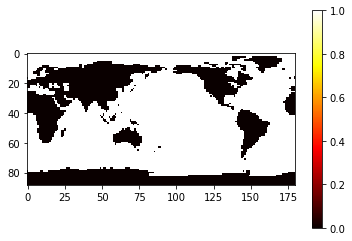


inputs shape (all input samples):  (1039, 89, 180)
train_input shape:  (831, 89, 180)
train_input_swap shape:  (831, 180, 89)
val_input shape:  (208, 89, 180)
val_input_swap shape:  (208, 180, 89)

NaN values removed:  True
train_input_flat shape:  (831, 1, 10988)
train_input_flat_small shape:  (831, 1, 2772)
val_input_flat shape:  (208, 1, 10988)
val_input_flat_small shape:  (208, 1, 2772)

targets shape (all targets):  (1039, 1)
train_target shape:  (831, 1)
train_target_bin shape:  (831, 1)
train_target_onehot shape:  (831, 2)
val_target shape:  (208, 1)
val_target_bin shape:  (208, 1)
val_target_onehot shape:  (208, 2)

abs. limit for capping:  2.5
train_inputs min:  -5.0
train_inputs max:  5.0

scaled train_inputs min:  -1.0
scaled train_inputs max:  1.0
scaled val_inputs min:  -1.0
scaled val_inputs max:  1.0

un-scaled train_target min:  -2.8181634
un-scaled train_target max:  2.4123752
un-scaled val_target min:  -1.7919745
un-scaled val_target max:  2.7960107

scaled train_tar

In [310]:
### Prepare inputs and targets from sst anomaly fields

## Set parameters upfront:

train_val_split = 0.8 # Set rel. amount of samples used for training.
scale_to = 'one_one' # Choose to scale inputs to [-1,1] ('one_one') or [0,1] ('zero_one'), or 'no' scaling.
remove_NaN = True # If True, gridoints of former NaN values (set to zero) are NOT included in vectorized inputs.

# Either set limits to quantile limits from former experiments: Here 0.005 and 0.995% quantile
#upper_cap_limit = 1.68 # Defines upper limit: sst anomaly values above this limit are set to limit.
#lower_cap_limit = -2.26 # Defines lower limit: sst anomaly values below this limit are set to limit.

# Or set arbitrary limits:
upper_cap_limit = 5
lower_cap_limit = -5

# Again start with raw sst fields as lat/lon grids in time, from 1880 to date:
sst_fields = (
    sst_dataset.sst
    .sel(time=slice('1880-01-01', '2021-11-01'))
)

# Compute monthly climatology (here 1980 - 2009) for whole world
sst_climatology_fields = (
    sst_dataset.sst
    .sel(time=slice('1980-01-01','2009-12-01'))
    .groupby("time.month")
    .mean("time")
)

# Get sst anomaly fields by subtracting monthly climatology from raw sst fields:
sst_anomaly_fields = sst_fields.groupby("time.month") - sst_climatology_fields

# Only keep sst anomaly fields connected either El Nino or La Nina event.
sst_anomaly_fields_NinoNina = sst_anomaly_fields[(sst_anomaly_norm.values > 0.5) | (sst_anomaly_norm.values < -0.5)]

# Extract sst anomaly fields' values as iputs:
inputs = np.copy(sst_anomaly_fields_NinoNina.values)

# Check how many NaN values we have, coming from landmasses, where we obviously don't have sst values:
temp_isnan = np.isnan(sst_anomaly_fields_NinoNina.values)
temp_isnan_rel = np.sum(temp_isnan) / np.size(temp_isnan)
print("rel. amount of NaN values in inputs: ", np.round(temp_isnan_rel,3))
print("NaN values in inputs BEFORE setting NaN to ZERO: ", np.sum(temp_isnan))

# Check for existing ZERO values in inputs BEFORE setting NaN to ZERO
print("ZERO values in inputs BEFORE setting NaN to ZERO: ", np.sum(inputs==0))

## Set NaN values to ZERO.
# It might be a problem to first set nan values to zero, then apply min/max scaling.
# After scaling former nan values are non-zero!
# On the other hand we cannot get necessary min/max values as long as we have nan values.
# Solution: Replace nan by zero. Apply min/max scaling. Then again set former nan values to zero.
inputs[temp_isnan] = 0
print("ZERO values in inputs AFTER setting NaN to ZERO: ", np.sum(inputs==0))

# Get targets from sst anomaly index:
targets = sst_anomaly_norm.values[(sst_anomaly_norm.values > 0.5) | (sst_anomaly_norm.values < -0.5)]

# Convert targets to binary targets (1 / 0) for El Nino / La Nina.
targets_bin = (targets > 0.5).astype(int)

# Reshape targets to (samples, 1):
targets = targets.reshape((len(targets), 1))
targets_bin = targets_bin.reshape((len(targets_bin), 1))

# Create one-hot targets for two unit output (El Nino / La Nina):
targets_onehot = np.concatenate([(targets_bin==1).astype(int),(targets_bin==0).astype(int)], axis=1)

## Take care of outliers in sst anomaly values:

# Copy inputs to provide un-capped version:
inputs_uncapped = np.copy(inputs)

# Set inputs with values outside specified limits to limit value:
inputs[inputs > upper_cap_limit] = upper_cap_limit
inputs[inputs < lower_cap_limit] = lower_cap_limit

## Split inputs and targets into train and validation data according to train_val_split.

# Get number of train samples:
n_train = int(len(inputs) * train_val_split)

## Optionally scale capped and uncapped inputs to [-1,1] or [0,1] 
## according to min/max obtained from only train inputs.

# Remenber min/max used for scaling.
train_min = np.min(inputs[:n_train])
train_max = np.max(inputs[:n_train])
train_min_uncapped = np.min(inputs_uncapped[:n_train])
train_max_uncapped = np.max(inputs_uncapped[:n_train])

# Scale inputs depending on desired scaling parameter:
if scale_to == 'one_one':
    # Scale inputs to [-1,1]:
    inputs = 2 * (inputs - train_min) / (train_max - train_min) - 1
    inputs_uncapped = 2 * (inputs_uncapped - train_min_uncapped) / (train_max_uncapped - train_min_uncapped) - 1
    
elif scale_to == 'zero_one':
    # Alternatively scale inputs to [0,1]
    inputs = (inputs - train_min) / (train_max - train_min)
    inputs_uncapped = (inputs_uncapped - train_min_uncapped) / (train_max_uncapped - train_min_uncapped)

# Again set former nan values to zero after scaling:
inputs[temp_isnan] = 0
inputs_uncapped[temp_isnan] = 0
    
## Create inputs with swapped lat <-> lon for feeding inputs column-wise into base ESN:
inputs_swap = np.swapaxes(inputs,1,2)
inputs_swap_uncapped = np.swapaxes(inputs_uncapped,1,2)

## Get valid gridpoints:
valid_gridpoints = (temp_isnan == False)
print("rel. amount of valid gridpoints: ",np.round(np.sum(valid_gridpoints) / np.size(valid_gridpoints),3))

# Plot valid gridpoints
plt.imshow(valid_gridpoints[0], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

## Create additional inputs with reduced resolution:
## Reduce inputs' dimension by a factor of 2 for both, lat and lon: Only take every second gridpoint into account.
inputs_small = inputs[:,np.arange(0,inputs.shape[1],2),:]
inputs_small = inputs_small[:,:,np.arange(0,inputs.shape[2],2)]
inputs_uncapped_small = inputs_uncapped[:,np.arange(0,inputs_uncapped.shape[1],2),:]
inputs_uncapped_small = inputs_uncapped_small[:,:,np.arange(0,inputs_uncapped.shape[2],2)]

# Now need valid gridpoints in reduced size by factor af 2 for both, lat and lon:
valid_gridpoints_small = valid_gridpoints[:,np.arange(0,valid_gridpoints.shape[1],2),:]
valid_gridpoints_small = valid_gridpoints_small[:,:,np.arange(0,valid_gridpoints.shape[2],2)]

## Create flattened inputs, optionally remove invalid gridoints:

# Now only keep valid inputs and flatten inputs, then restore first dimension as "samples" 
# and second dimension as "timestep" by reshaping:
if remove_NaN==True:
    inputs_flat = np.reshape(inputs[valid_gridpoints], (inputs.shape[0], 1, np.sum(valid_gridpoints[0].astype(int))))
    inputs_uncapped_flat = np.reshape(inputs_uncapped[valid_gridpoints], (inputs_uncapped.shape[0], 1, np.sum(valid_gridpoints[0].astype(int))))
    inputs_flat_small = np.reshape(inputs_small[valid_gridpoints_small], (inputs_small.shape[0], 1, np.sum(valid_gridpoints_small[0].astype(int))))
    inputs_uncapped_flat_small = np.reshape(inputs_uncapped_small[valid_gridpoints_small], (inputs_uncapped_small.shape[0], 1, np.sum(valid_gridpoints_small[0].astype(int))))

# Alternatively keep all inputs, but still flatten inputs, then restore first dimension as "samples" 
# and second dimension as "timestep" by reshaping:
elif remove_NaN==False:
    inputs_flat = np.reshape(inputs, (inputs.shape[0], 1, inputs.shape[1] * inputs.shape[2]))
    inputs_uncapped_flat = np.reshape(inputs_uncapped, (inputs.shape[0], 1, inputs.shape[1] * inputs.shape[2]))
    inputs_flat_small = np.reshape(inputs_small, (inputs_small.shape[0], 1, inputs_small.shape[1] * inputs_small.shape[2]))
    inputs_uncapped_flat_small = np.reshape(inputs_uncapped_small, (inputs_small.shape[0], 1, inputs_small.shape[1] * inputs_small.shape[2]))

## Split inputs and targets:
train_input = inputs[:n_train]
train_input_uncapped = inputs_uncapped[:n_train]
train_input_flat = inputs_flat[:n_train]
train_input_uncapped_flat = inputs_uncapped_flat[:n_train]
train_input_flat_small = inputs_flat_small[:n_train]
train_input_uncapped_flat_small = inputs_uncapped_flat_small[:n_train]
train_input_swap = inputs_swap[:n_train]
train_input_swap_uncapped = inputs_swap_uncapped[:n_train]
val_input = inputs[n_train:]
val_input_uncapped = inputs_uncapped[n_train:]
val_input_flat = inputs_flat[n_train:]
val_input_uncapped_flat = inputs_uncapped_flat[n_train:]
val_input_flat_small = inputs_flat_small[n_train:]
val_input_uncapped_flat_small = inputs_uncapped_flat_small[n_train:]
val_input_swap = inputs_swap[n_train:]
val_input_swap_uncapped = inputs_swap_uncapped[n_train:]
train_target = targets[:n_train]
train_target_bin = targets_bin[:n_train]
train_target_onehot = targets_onehot[:n_train]
val_target = targets[n_train:]
val_target_bin = targets_bin[n_train:]
val_target_onehot = targets_onehot[n_train:]

## Additionally scale targets to [-1,1] according to min/max obtained from only train targets.
# Remenber min/max used for scaling.
train_target_min = np.min(train_target)
train_target_max = np.max(train_target)
# Scale
train_target_scaled = 2 * (train_target - train_target_min) / (train_target_max - train_target_min) - 1
val_target_scaled = 2 * (val_target - train_target_min) / (train_target_max - train_target_min) - 1

# Dimensionality check:
print("\ninputs shape (all input samples): ", inputs.shape)
print("train_input shape: ", train_input.shape)
print("train_input_swap shape: ", train_input_swap.shape)
print("val_input shape: ", val_input.shape)
print("val_input_swap shape: ", val_input_swap.shape)
print("\nNaN values removed: ", remove_NaN)
print("train_input_flat shape: ", train_input_flat.shape)
print("train_input_flat_small shape: ", train_input_flat_small.shape)
print("val_input_flat shape: ", val_input_flat.shape)
print("val_input_flat_small shape: ", val_input_flat_small.shape)
print("\ntargets shape (all targets): ", targets.shape)
print("train_target shape: ", train_target.shape)
print("train_target_bin shape: ", train_target_bin.shape)
print("train_target_onehot shape: ", train_target_onehot.shape)
print("val_target shape: ", val_target.shape)
print("val_target_bin shape: ", val_target_bin.shape)
print("val_target_onehot shape: ", val_target_onehot.shape)
print("\nabs. limit for capping: ", cap_limit)
print("train_inputs min: ", train_min)
print("train_inputs max: ", train_max)
print("\nscaled train_inputs min: ", np.min(train_input))
print("scaled train_inputs max: ", np.max(train_input))
print("scaled val_inputs min: ", np.min(val_input))
print("scaled val_inputs max: ", np.max(val_input))
print("\nun-scaled train_target min: ", np.min(train_target))
print("un-scaled train_target max: ", np.max(train_target))
print("un-scaled val_target min: ", np.min(val_target))
print("un-scaled val_target max: ", np.max(val_target))
print("\nscaled train_target min: ", np.min(train_target_scaled))
print("scaled train_target max: ", np.max(train_target_scaled))
print("scaled val_target min: ", np.min(val_target_scaled))
print("scaled val_target max: ", np.max(val_target_scaled))



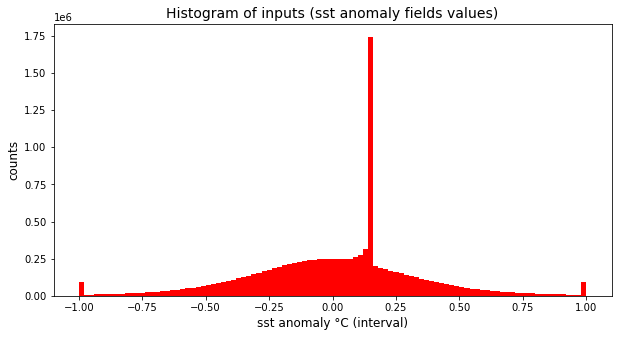

In [295]:
# Plot histogram of inputs, optionally capped and scaled:
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(inputs_flat.flatten(), nBins, color="red")
#axes.hist(inputs_flat_small.flatten(), nBins, color="red")
#axes.hist(inputs_uncapped_flat.flatten(), nBins, color="blue")
#axes.hist(inputs_uncapped_flat_small.flatten(), nBins, color="red")
#axes.hist(inputs.flatten(), nBins, color="red")
#axes.hist(inputs_uncapped.flatten(), nBins, color="blue")
#axes.hist(train_input_uncapped.flatten(), nBins, color="blue")
#axes.hist(train_input_swap.flatten(), nBins, color="blue")
axes.set_ylabel("counts", fontsize=12)
axes.set_xlabel("sst anomaly °C (interval)", fontsize=12)
axes.set_title("Histogram of inputs (sst anomaly fields values)", fontsize=14)
plt.show()

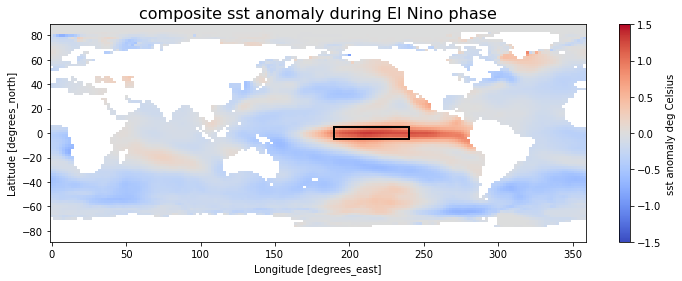

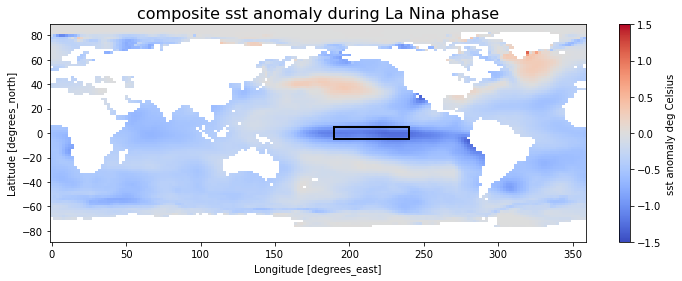

In [282]:
## Split sst anomaly fields related to El Nino or La Nina, respectively:

# El Nino
sst_anomaly_fields_ElNino = sst_anomaly_fields[(sst_anomaly_norm.values > 0.5)]

# La Nina
sst_anomaly_fields_LaNina = sst_anomaly_fields[(sst_anomaly_norm.values < -0.5)]

## Get mean sst anomaly field as composit of all sst fields belonging to either "El Nino" or "La Nina":

# El Nino
sst_anomaly_mean_ElNino = (
    sst_anomaly_fields_ElNino
    .mean("time")
)

# La Nina
sst_anomaly_mean_LaNina = (
    sst_anomaly_fields_LaNina
    .mean("time")
)

## Plot sst anomaly fields for the world, with bounding box arround Nino3.4 area

# El Nino
fig, ax = plt.subplots(figsize=(12, 4))
sst_anomaly_mean_ElNino.name = 'sst anomaly deg Celsius'
sst_anomaly_mean_ElNino.plot(ax=ax, cmap='coolwarm', vmax=1.5, vmin=-1.5)
plt.title('composite sst anomaly during El Nino phase', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# La Nina
fig, ax = plt.subplots(figsize=(12, 4))
sst_anomaly_mean_LaNina.name = 'sst anomaly deg Celsius'
sst_anomaly_mean_LaNina.plot(ax=ax, cmap='coolwarm', vmax=1.5, vmin=-1.5)
plt.title('composite sst anomaly during La Nina phase', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

Text(0.5, 1.0, 'Regression of sst anomaly index onto sst anomaly fields')

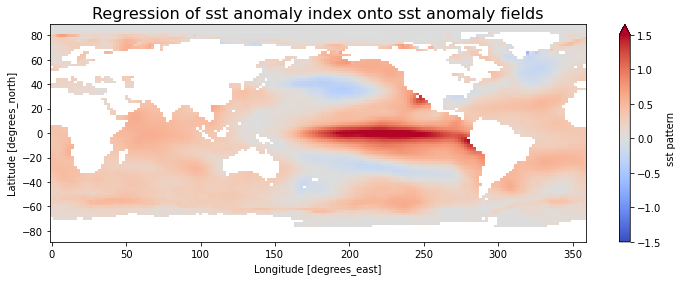

In [100]:
# Regression of sst anomaly index onto sst anomaly fields ("sst pattern")
sst_anomaly_index = sst_anomaly_norm[(sst_anomaly_norm.values > 0.5)| (sst_anomaly_norm.values < -0.5)]
sst_pattern = (sst_anomaly_index * sst_anomaly_fields_NinoNina).mean("time")

# Show sst pattern
fig, ax = plt.subplots(figsize=(12, 4))
sst_pattern.name = 'sst pattern'
sst_pattern.plot(ax=ax, cmap='coolwarm', vmax=1.5, vmin=-1.5)
plt.title('Regression of sst anomaly index onto sst anomaly fields', fontsize=16)

In [101]:
## Final check if samples are balanced, hence if we find equal number of EL Nino and La Nina events 
## in train and validation data:

print("ALL samples:")
print("rel. amount of El Nino samples: ", np.round(sum(targets_bin[:,0]==1)/len(targets),2))
print("rel. amount of La Nina samples: ", np.round(sum(targets_bin[:,0]==0)/len(targets),2))

print("\nTRAIN samples:")
print("rel. amount of El Nino samples: ", np.round(sum(train_target_bin[:,0]==1)/len(train_target),2))
print("rel. amount of La Nina samples: ", np.round(sum(train_target_bin[:,0]==0)/len(train_target),2))

print("\nVALIDATION samples:")
print("rel. amount of El Nino samples: ", np.round(sum(val_target_bin[:,0]==1)/len(val_target),2))
print("rel. amount of La Nina samples: ", np.round(sum(val_target_bin[:,0]==0)/len(val_target),2))

ALL samples:
rel. amount of El Nino samples:  0.28
rel. amount of La Nina samples:  0.72

TRAIN samples:
rel. amount of El Nino samples:  0.23
rel. amount of La Nina samples:  0.77

VALIDATION samples:
rel. amount of El Nino samples:  0.47
rel. amount of La Nina samples:  0.53


<function matplotlib.pyplot.show(close=None, block=None)>

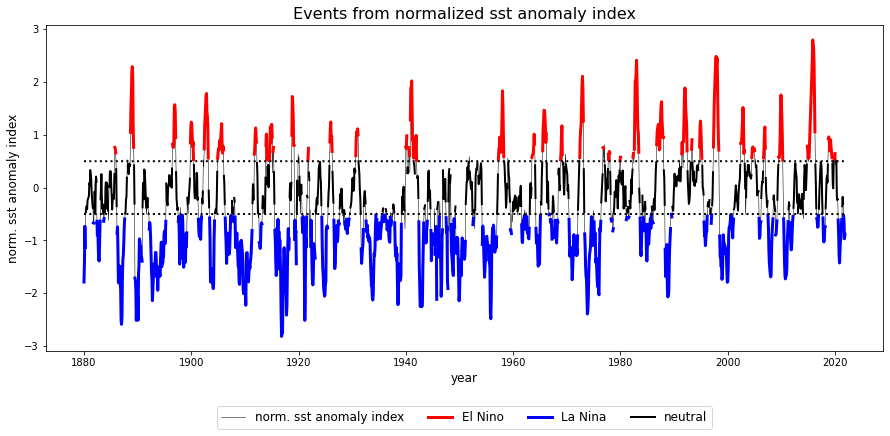

In [102]:
## Another way of highlighting distinct events:

# Mask events for plotting them in different colors
sst_ElNino = np.ma.masked_where(sst_anomaly_norm.values < 0.5, sst_anomaly_norm.values)
sst_LaNina = np.ma.masked_where(sst_anomaly_norm.values > -0.5, sst_anomaly_norm.values)
sst_neutral = np.ma.masked_where((sst_anomaly_norm.values >= 0.5) | (sst_anomaly_norm.values <= -0.5), sst_anomaly_norm.values)

# Focus on normalized ENSO index: Highlight events.
# > 0.5: EL Nino, < -0.5: La Nina, else: 'neutral'
fig, axes = plt.subplots(1, 1, figsize=(15,6))
axes.plot(sst_anomaly_norm.time, sst_anomaly_norm, label='norm. sst anomaly index', color='black', linewidth=0.5)
axes.plot(sst_anomaly_norm.time, sst_ElNino, label='El Nino', color='red', linewidth=3)
axes.plot(sst_anomaly_norm.time, sst_LaNina, label='La Nina', color='blue', linewidth=3)
axes.plot(sst_anomaly_norm.time, sst_neutral, label='neutral', color='black', linewidth=2)

axes.set_xlabel("year", fontsize=12)
axes.set_ylabel("norm. sst anomaly index", fontsize=12)
axes.set_title("Events from normalized sst anomaly index", fontsize=16)
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=4, fontsize=12)

# Add horizontal lines
axes.plot(sst_anomaly_norm.time,0.5 * np.ones(len(sst_anomaly_norm)),'k:', linewidth=2)
axes.plot(sst_anomaly_norm.time,-0.5 * np.ones(len(sst_anomaly_norm)),'k:', linewidth=2)

plt.show

### Discussion on samples' balance

We find class imbalance: Have a lot more La Nina samples than El Nino samples, at least in train data. This should not be a problem for ESN models if we work with one-hot targets and train output weights for each class in a closed-form manner. And this is obviously another advantage compared to *regular* ANN architectures!

If balance is required, we could think about **de-trending** sst anomaly index, but not done here.

### Classify sst anomaly fields (El Nino / La Nina) and try LRP

* Linear regression
* Multilayer perceptron
* baseESN: Feed inputs row- and column-wise
* Coupled baseESN

### Linear regression


Lin. Regression, accuracy on sst anomaly fields from whole world: Continuous targets

train_acc_ElNino 1.0
train_acc_LaNina 1.0

val_acc_ElNino 1.0
val_acc_LaNina 1.0


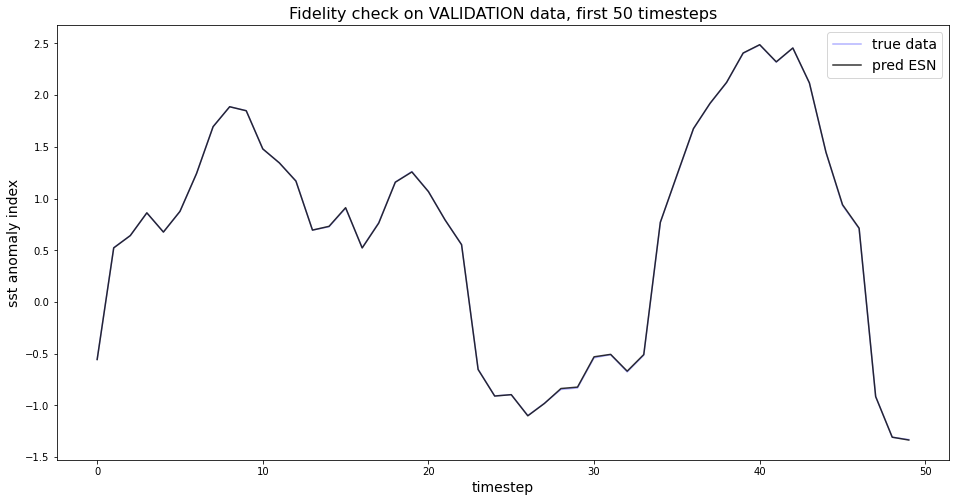

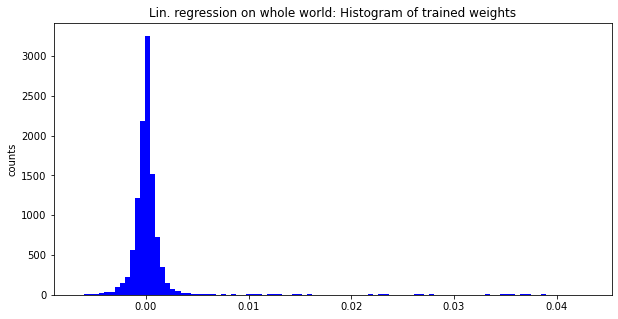

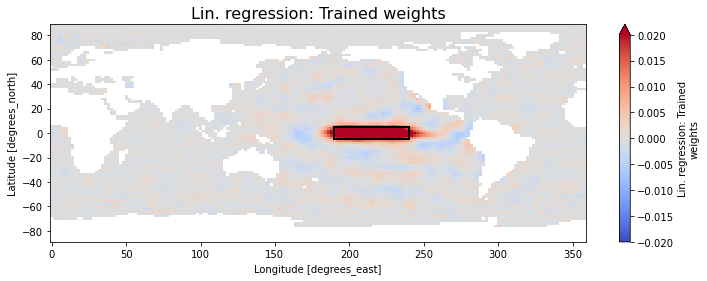

In [259]:
### Linear regression (CAPPED)

## Work with original size sst anomaly fields, CAPPED and scaled to [-1,1]. 
## Need flattened inputs, omit time dimension. BUT ONLY VALID GRIDPOINTS!
## Use unscaled continuous normalized sst anomaly index as target.

# Create vector of shape (samples, 1) containing ONEs to be added as additional column train and val inputs.
train_input_add = np.ones((train_input_flat.shape[0], 1))
val_input_add = np.ones((val_input_flat.shape[0], 1))

# Now add vector of ONEs as additional column to train and validation inputs, omit time dimension:
train_input_prime = np.concatenate((train_input_flat[:,0,:], train_input_add), axis=-1)
val_input_prime = np.concatenate((val_input_flat[:,0,:], val_input_add), axis=-1)

# Then need pseudo-inverse of train inputs in augmented notation
train_input_prime_inv = np.linalg.pinv(train_input_prime)

# Then get output weights, in augmented notation
W_prime = np.matmul(train_input_prime_inv, train_target)

# Get predictions on val and train data with trained weights:
val_pred = np.matmul(val_input_prime, W_prime)
train_pred = np.matmul(train_input_prime, W_prime)

## Get train and validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum(((val_pred>0.5)==(val_target>0.5)) & (val_target>0.5)) / sum((val_target>0.5))
val_acc_LaNina = sum(((val_pred<-0.5)==(val_target<-0.5)) & (val_target<-0.5)) / sum((val_target<-0.5))
train_acc_ElNino = sum(((train_pred>0.5)==(train_target>0.5)) & (train_target>0.5)) / sum((train_target>0.5))
train_acc_LaNina = sum(((train_pred<-0.5)==(train_target<-0.5)) & (train_target<-0.5)) / sum((train_target<-0.5))

# Print accuracies:
print("\nLin. Regression, accuracy on sst anomaly fields from whole world: Continuous targets")
print("\ntrain_acc_ElNino", np.round(train_acc_ElNino[0],2))
print("train_acc_LaNina", np.round(train_acc_LaNina[0],2))
print("\nval_acc_ElNino", np.round(val_acc_ElNino[0],2))
print("val_acc_LaNina", np.round(val_acc_LaNina[0],2))

# Fidelity check: Plot val_pred vs. val_targets, but only the first 50 timesteps
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target[:50])),val_target[:50],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred[:50])),val_pred[:50],'k',  alpha=0.8, label='pred ESN')
plt.title('Fidelity check on VALIDATION data, first 50 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('sst anomaly index', fontsize=14)
plt.legend(fontsize=14)
plt.show()


# Now split weights in augmented notation (W_prime) into trained weights W and  bias b.
W = W_prime[:-1,:]
b = W_prime[-1:,0]

# Plot histogram of trained weights
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(W[:,0], nBins, color="blue")
axes.set_ylabel("counts")
axes.set_title("Lin. regression on whole world: Histogram of trained weights")
plt.show()       

## Transform flattend vector of trained weights back to its original 2D lat x lon grid:

# Initialize storage, take original lat / lon shape from valid gridpoints' shape:
W_restored = np.zeros(valid_gridpoints[0].shape)

# If former NaN values (now set to zero) haven't been removed (remove_NaN=False), can just reshape flat W matrix:
if remove_NaN==False:
    W_restored = np.reshape(W, valid_gridpoints[0].shape)

elif remove_NaN==True:
    
    # count variable for running through flattened vector of valid values:
    k = 0

    # Loop over latitude
    for i in range(valid_gridpoints[0].shape[0]):
        # Loop over longitude
        for j in range(valid_gridpoints[0].shape[1]):
            if valid_gridpoints[0][i,j]==1:
                W_restored[i,j]=W[k,0]
                k += 1

# Set weights of former NaN values' gridpoints to -1, to highlight continents' shapes
W_restored[valid_gridpoints[0]==0] = float("nan")
                
# Copy some xarray as storage for reshaped trained weights with lat/lon grid:
W_xr = xr.DataArray.copy(sst_anomaly_mean_ElNino)
W_xr.values = W_restored

# Plot trained weights on lat/lon grid
fig, ax = plt.subplots(figsize=(12, 4))
W_xr.name = 'Lin. regression: Trained weights'
W_xr.plot(ax=ax, cmap='coolwarm', vmax=0.02, vmin=-0.02)
plt.title('Lin. regression: Trained weights', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

### Image Classification with MLP

As in [Toms et al, 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002002) paper "Physically Interpretable Neural Networks for the Geosciences: Applications to Earth System Variability", try to set up simple MLP for image classification of sst anomaly fields.

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 10988)]           0         
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 87912     
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 18        
Total params: 88,002
Trainable params: 88,002
Non-trainable params: 0
_________________________________________________________________


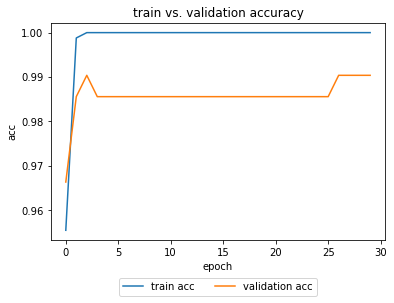

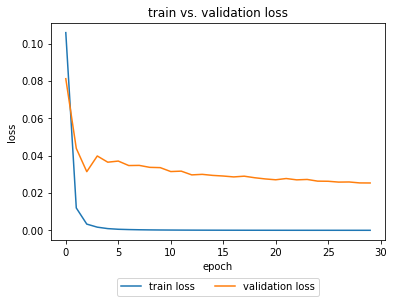

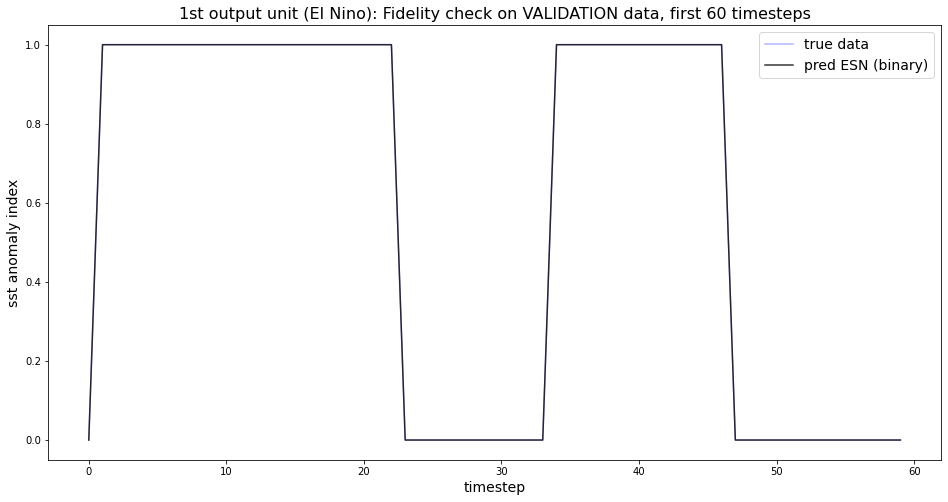

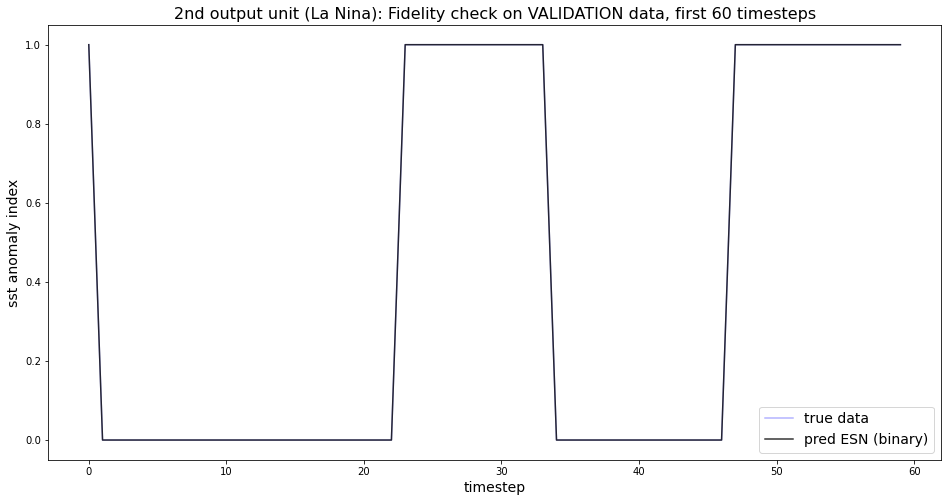


Validation accuracy:
El Nino:  1.0
La Nina:  0.98

Train accuracy:
El Nino:  1.0
La Nina:  1.0


In [313]:
### Multilayer perceptron

## Work with original size sst anomaly fields, capped or un-capped (to choose!) and scaled to [-1,1].
## Need flattened inputs, BUT ONLY FEED VALID GRIDPOINTS' values, omit time dimension.
## Use one-hot targets.

## Set parameters upfront:
lr = 0.0005 # Learning rate
epc = 30 # Number of epochs
batch_size = 10 # Batch size

# Set up layers:
inputs = Input(shape=(train_input_flat.shape[2]))
hidden_1 = Dense(8, activation='linear')(inputs)
hidden_2 = Dense(8, activation='linear')(hidden_1)
output = Dense(2, activation='softmax')(hidden_2)

# Define and compile model :
model = Model(inputs, output, name='MLP')
opt = Adam(lr=lr) #SGD(lr=lr)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
model.summary()

# plot model
plot_model(model, show_shapes=True, show_layer_names=True)

## train model

# Either with capped inputs:
history = model.fit(train_input_flat[:,0,:], train_target_onehot, epochs=epc, verbose=0,
                    batch_size=batch_size, validation_data=(val_input_flat[:,0,:], val_target_onehot))

# Or on uncapped inputs:
#history = model.fit(train_input_uncapped_flat[:,0,:], train_target_onehot, epochs=epc, verbose=0,
#                    batch_size=batch_size, validation_data=(val_input_uncapped_flat[:,0,:], val_target_onehot))




train_acc = history.history['acc']
val_acc = history.history['val_acc']

# evaluation
plt.plot(train_acc, label='train acc'), 
plt.plot(val_acc, label='validation acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# evaluation
plt.plot(history.history['loss'], label='train loss'), 
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('train vs. validation loss')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

## Check accuracy: How often is the correct label predicted?
## Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
## to have that same event.

## Get model predictions on train and validation data:

# Either with capped inputs:
train_pred = model.predict(train_input_flat[:,0,:])
val_pred = model.predict(val_input_flat[:,0,:])

# Or on uncapped inputs:
#train_pred = model.predict(train_input_uncapped_flat[:,0,:])
#val_pred = model.predict(val_input_uncapped_flat[:,0,:])

# Convert to binary prediction:
train_pred_bin = (train_pred > 0.5).astype(int)
val_pred_bin = (val_pred > 0.5).astype(int)

# Fidelity check for binary prediction and target for 1st output unit (El Nino).
# Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target_onehot[:60,0])),val_target_onehot[:60,0],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred_bin[:60,0])),val_pred_bin[:60,0],'k',  alpha=0.8, label='pred ESN (binary)')
plt.title('1st output unit (El Nino): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('sst anomaly index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

# Fidelity check for binary prediction and target for 2nd output unit (La Nina).
# Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target_onehot[:60,1])),val_target_onehot[:60,1],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred_bin[:60,1])),val_pred_bin[:60,1],'k',  alpha=0.8, label='pred ESN (binary)')
plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('sst anomaly index', fontsize=14)
plt.legend(fontsize=14)
plt.show()
    
# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum((val_pred_bin[:,0] == val_target_onehot[:,0]) & (val_target_onehot[:,0] == 1)) / sum(val_target_onehot[:,0] == 1)
val_acc_LaNina = sum((val_pred_bin[:,1] == val_target_onehot[:,1]) & (val_target_onehot[:,1] == 1)) / sum(val_target_onehot[:,1] == 1)

# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum((train_pred_bin[:,0] == train_target_onehot[:,0]) & (train_target_onehot[:,0] == 1)) / sum(train_target_onehot[:,0] == 1)
train_acc_LaNina = sum((train_pred_bin[:,1] == train_target_onehot[:,1]) & (train_target_onehot[:,1] == 1)) / sum(train_target_onehot[:,1] == 1)

print("\nValidation accuracy:")
print("El Nino: ", np.round(val_acc_ElNino,2))
print("La Nina: ", np.round(val_acc_LaNina,2))

print("\nTrain accuracy:")
print("El Nino: ", np.round(train_acc_ElNino,2))
print("La Nina: ", np.round(train_acc_LaNina,2))

### LRP with MLP

Sample dimensions and prediction:
raw sample shape (1, features):  (1, 10988)
number of input features in_feat:  10988
model prediction on sample, first output unit (El Nino):  1.0
model prediction on sample, second output unit (La Nina):  0.0

Model weights and biases, Dimensions:
input weights W_in (input features, hidden units):  (10988, 8)
input biases b_in (hidden units):  (8,)
hidden weights W_hidden (hidden units, hidden units):  (8, 8)
hidden biases b_hidden (hidden units):  (8,)
output weights W_out (hidden units, output units):  (8, 2)
output biases b_out (output units):  (2,)

Tensor shapes:
input tensor U (input features):  (10988,)
first hidden layer output (hidden units):   (8,)
second hidden layer output (hidden units):  (8,)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_878/4292258040.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


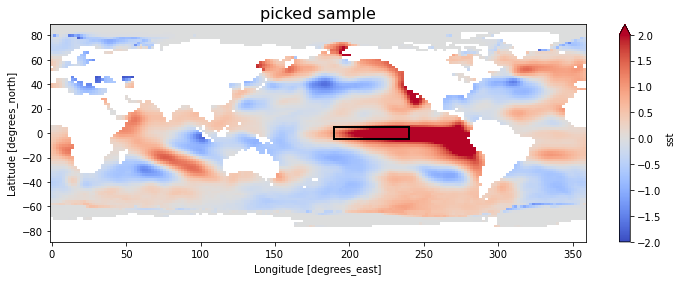

In [314]:
### Pick out ONE El Nino sample to be analysed, omit timestep (second dimension):
sample_id = 40 # number 40 of validation inputs --> El Nino sample
#sample_id = 52 # number 52 of validation inputs --> La Nina sample

## If model trained on uncapped inputs:
#sample = val_input_uncapped_flat[sample_id:sample_id+1,0,:]

## Or else, if model trained on capped inputs:
sample = val_input_flat[sample_id:sample_id+1,0,:]

# Plot sample input in its original size. Assume train_val_split=0.8, then have 831 input samples.
# Since we picked samples from validation data, need to add 831 to sample_id, to pick the correct
# sample from ALL samples.
fig, ax = plt.subplots(figsize=(12, 4))
sst_anomaly_fields_NinoNina[831+sample_id].name = 'sst anomaly deg Celsius'
sst_anomaly_fields_NinoNina[831+sample_id].plot(ax=ax, cmap='coolwarm', vmax=2, vmin=-2)
plt.title('picked sample', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Extract number of input features:
in_feat = sample.shape[1]

# Have trained model as pre-requisite. Get prediction on picked sample.
pred = model.predict(sample)

## Check dimensions and prediction:
print("Sample dimensions and prediction:")
print("=================================")
print("raw sample shape (1, features): ", sample.shape)
print("number of input features in_feat: ", in_feat)
print("model prediction on sample, first output unit (El Nino): ", np.round(pred[0,0],3))
print("model prediction on sample, second output unit (La Nina): ", np.round(pred[0,1],3))

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_hidden = model_weights[2]
b_hidden = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Check dimensions:
print("\nModel weights and biases, Dimensions:")
print("=====================================")
print("input weights W_in (input features, hidden units): ", W_in.shape)
print("input biases b_in (hidden units): ", b_in.shape)
print("hidden weights W_hidden (hidden units, hidden units): ", W_hidden.shape)
print("hidden biases b_hidden (hidden units): ", b_hidden.shape)
print("output weights W_out (hidden units, output units): ", W_out.shape)
print("output biases b_out (output units): ", b_out.shape)

## Get outputs from first and second hidden layer, X_1 and X_2, respectively:

# Define shortened models:
model_X1 = Model(inputs, hidden_1, name='model_X1')
model_X2 = Model(inputs, hidden_2, name='model_X2')

# Get outputs on selected sample (forward-pass) from trained short models:
X_1 = model_X1.predict(sample)[0]
X_2 = model_X2.predict(sample)[0]

# Get inputs U from raw input sample by just omitting first dimension (=sample number):
U = sample[0,:]

# Check dimensions:
print("\nTensor shapes:")
print("==============")
print("input tensor U (input features): ", U.shape)
print("first hidden layer output (hidden units):  ", X_1.shape)
print("second hidden layer output (hidden units): ", X_2.shape)

In [303]:
sample.shape

(1, 10988)

In [315]:
## Transform flattend sample back to its original 2D lat x lon grid:

# Initialize storage, take original lat / lon shape from valid gridpoints' shape:
sample_restored = np.zeros(valid_gridpoints[0].shape)

# count variable for running through flattened vector of valid values:
k = 0

# Loop over latitude
for i in range(valid_gridpoints[0].shape[0]):
    # Loop over longitude
    for j in range(valid_gridpoints[0].shape[1]):
        if valid_gridpoints[0][i,j]==1:
            sample_restored[i,j]=sample[0,k]
            k += 1
            
# Set weights of former NaN values' gridpoints to -1, to highlight continents' shapes
sample_restored[valid_gridpoints[0]==0] = -1

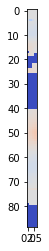

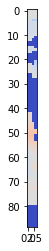

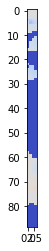

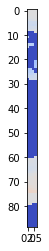

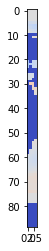

In [319]:
# Show "sliced" input sample, column by column:

for i in np.arange(0,20,4):
    plt.imshow(sample_restored[:,i:i+4], cmap='coolwarm', interpolation='nearest', vmax=1)
    plt.show()

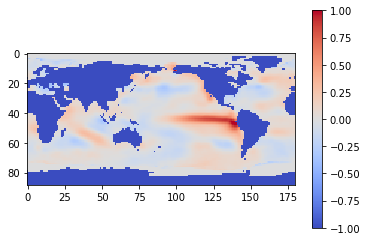

In [316]:
# Picked sample as heatmap, to see the effect of scaling input values:
plt.imshow(sample_restored, cmap='coolwarm', interpolation='nearest', vmax=1)
plt.colorbar()
plt.show()

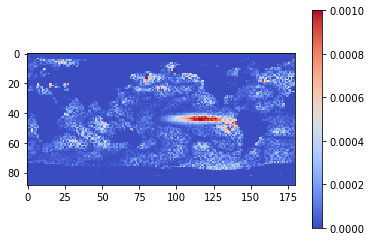

sum of relevance R_i:  1.0
sum of relevance R_j:  0.999
sum of relevance R_k:  0.999


In [266]:
### LRP on MLP: Only take positive contributions of pre-potential into account. Neglect bias terms.

## First output unit: EL NINO

## Start with connection of second HIDDEN layer (HID_2) to OUTPUT layer. 
## Only get relevance for first output unit here.

# Get pre-activations z_io for hidden units x_i of HID_2 connecting to first OUTPUT unit x_o.
# Note: Only consider positive pre-activations.
z_io = (np.multiply(X_2,W_out[:,0])>0)*np.multiply(X_2,W_out[:,0])

# Combine pre-activations z_io to get z_o.
z_o = sum(z_io)

# Get messages R_io for connections between OUTPUT with HID_2
R_io = z_io / z_o * pred[0,0]

# Get relevances R_i for hidden units x_i of HID_2.
# Note: No summation necessary for layer HID_2, since only connected to first OUTPUT unit x_o.
R_i = R_io

## Continue with connection of first HIDDEN layer (HID_1) to second HIDDEN layer (HID_2).

# Get relevance R_j for 8 units x_j of HID_1 connecting to x_i units of HID_2.
# Note: Need stabilizer (epsilon=0.01) to avoid division by zero.
R_j = np.sum((((X_1 * W_hidden)>0) * (X_1 * W_hidden)) /
             (np.sum((((X_1 * W_hidden)>0) * (X_1 * W_hidden)), axis=0)+0.01)
             * R_i, axis=1)    

## And then take care about connection of INPUT layer to first HIDDEN layer (HID_1).

# Get directly to relevances R_k for INPUT layer units x_k
R_k = np.sum(((np.multiply(np.reshape(U, (in_feat,1)),W_in)>0) * (np.multiply(np.reshape(U, (in_feat,1)),W_in))) /
             (np.sum(((np.multiply(np.reshape(U, (in_feat,1)),W_in)>0) * (np.multiply(np.reshape(U, (in_feat,1)),W_in))), axis=0))
             * R_j, axis=1)    

## Transform flattend relevance map back to its original 2D lat x lon grid:

# Initialize storage, take original lat / lon shape from valid gridpoints' shape:
R_k_restored = np.zeros(valid_gridpoints[0].shape)

# count variable for running through flattened vector of valid values:
k = 0

# Loop over latitude
for i in range(valid_gridpoints[0].shape[0]):
    # Loop over longitude
    for j in range(valid_gridpoints[0].shape[1]):
        if valid_gridpoints[0][i,j]==1:
            R_k_restored[i,j]=R_k[k]
            k += 1
            
# Relevance heatmap
plt.imshow(R_k_restored, cmap='coolwarm', interpolation='nearest', vmax=0.001)
plt.colorbar()
plt.show()

# Plausibility check, whether Layer relevance is conserved:
print("sum of relevance R_i: ", np.round(sum(R_i), 3))
print("sum of relevance R_j: ", np.round(sum(R_j), 3))
print("sum of relevance R_k: ", np.round(sum(R_k), 3))


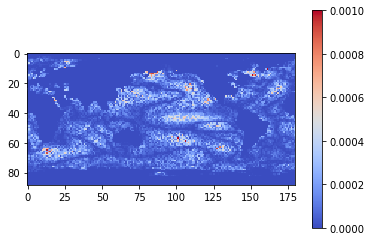

sum of relevance R_i:  1.0
sum of relevance R_j:  1.0
sum of relevance R_k:  1.0


In [154]:
### LRP on MLP: Only take positive contributions of pre-potential into account. Neglect bias terms.

## Second output unit: LA NINA

## Start with connection of second HIDDEN layer (HID_2) to OUTPUT layer. 
## Only get relevance for first output unit here.

# Get pre-activations z_io for hidden units x_i of HID_2 connecting to first OUTPUT unit x_o.
# Note: Only consider positive pre-activations.
z_io = (np.multiply(X_2,W_out[:,1])>0)*np.multiply(X_2,W_out[:,1])

# Combine pre-activations z_io to get z_o.
z_o = sum(z_io)

# Get messages R_io for connections between OUTPUT with HID_2
R_io = z_io / z_o * pred[0,1]

# Get relevances R_i for hidden units x_i of HID_2.
# Note: No summation necessary for layer HID_2, since only connected to first OUTPUT unit x_o.
R_i = R_io

## Continue with connection of first HIDDEN layer (HID_1) to second HIDDEN layer (HID_2).

# Get relevance R_j for 8 units x_j of HID_1 connecting to x_i units of HID_2.
# Note: Need stabilizer (epsilon=0.01) to avoid division by zero.
R_j = np.sum((((X_1 * W_hidden)>0) * (X_1 * W_hidden)) /
             (np.sum((((X_1 * W_hidden)>0) * (X_1 * W_hidden)), axis=0))
             * R_i, axis=1)    

## And then take care about connection of INPUT layer to first HIDDEN layer (HID_1).

# Get directly to relevances R_k for INPUT layer units x_k
R_k = np.sum(((np.multiply(np.reshape(U, (in_feat,1)),W_in)>0) * (np.multiply(np.reshape(U, (in_feat,1)),W_in))) /
             (np.sum(((np.multiply(np.reshape(U, (in_feat,1)),W_in)>0) * (np.multiply(np.reshape(U, (in_feat,1)),W_in))), axis=0))
             * R_j, axis=1)    

## Transform flattend relevance map back to its original 2D lat x lon grid:

# Initialize storage, take original lat / lon shape from valid gridpoints' shape:
R_k_restored = np.zeros(valid_gridpoints[0].shape)

# count variable for running through flattened vector of valid values:
k = 0

# Loop over latitude
for i in range(valid_gridpoints[0].shape[0]):
    # Loop over longitude
    for j in range(valid_gridpoints[0].shape[1]):
        if valid_gridpoints[0][i,j]==1:
            R_k_restored[i,j]=R_k[k]
            k += 1
            
# Relevance heatmap
plt.imshow(R_k_restored, cmap='coolwarm', interpolation='nearest', vmax=0.001)
plt.colorbar()
plt.show()

# Plausibility check, whether Layer relevance is conserved:
print("sum of relevance R_i: ", np.round(sum(R_i), 3))
print("sum of relevance R_j: ", np.round(sum(R_j), 3))
print("sum of relevance R_k: ", np.round(sum(R_k), 3))

### LRP with MLP: Get mean relevance maps for ALL El Nino / La Nina samples (from train inputs)

In [274]:
### LRP with MLP on ALL El Nino samples (from train inputs)

verbose=False

## Split train inputs into El Nino / La Nina samples, according to binary target:
samples_ElNino = train_input_flat[(train_target_bin==1)[:,0]]
#samples_ElNino = train_input_uncapped_flat[(train_target_bin==1)[:,0]]

## Split targets accordingly:
targets_ElNino = train_target[(train_target_bin==1)[:,0]]

if verbose:
    print("samples_ElNino shape: ", samples_ElNino.shape)

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_hidden = model_weights[2]
b_hidden = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

# Define shortened models:
model_X1 = Model(inputs, hidden_1, name='model_X1')
model_X2 = Model(inputs, hidden_2, name='model_X2')

# Initialize storage for mean relevance map
R_k_all = np.zeros(train_input_flat.shape[2])

#Loop over El Nino samples:
for sample_id in range(len(samples_ElNino)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_ElNino))
    
    # Get current sample:
    sample = samples_ElNino[sample_id:sample_id+1,0,:]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)
    
    ## Get outputs from first and second hidden layer, X_1 and X_2, respectively:

    # Get outputs on selected sample (forward-pass) from trained short models:
    X_1 = model_X1.predict(sample)[0]
    X_2 = model_X2.predict(sample)[0]

    # Get inputs U from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:]    
    
    ### LRP on MLP: Only take positive contributions of pre-potential into account. Neglect bias terms.

    ## First output unit: EL NINO

    ## Start with connection of second HIDDEN layer (HID_2) to OUTPUT layer. 
    ## Only get relevance for first output unit here.

    # Get pre-activations z_io for hidden units x_i of HID_2 connecting to first OUTPUT unit x_o.
    # Note: Only consider positive pre-activations.
    z_io = (np.multiply(X_2,W_out[:,0])>0)*np.multiply(X_2,W_out[:,0])

    # Combine pre-activations z_io to get z_o.
    z_o = sum(z_io)

    # Get messages R_io for connections between OUTPUT with HID_2
    R_io = z_io / z_o * pred[0,0]

    # Get relevances R_i for hidden units x_i of HID_2.
    # Note: No summation necessary for layer HID_2, since only connected to first OUTPUT unit x_o.
    R_i = R_io

    ## Continue with connection of first HIDDEN layer (HID_1) to second HIDDEN layer (HID_2).

    # Get relevance R_j for 8 units x_j of HID_1 connecting to x_i units of HID_2.
    # Note: Need stabilizer (epsilon=0.01) to avoid division by zero.
    R_j = np.sum((((X_1 * W_hidden)>0) * (X_1 * W_hidden)) /
                 (np.sum((((X_1 * W_hidden)>0) * (X_1 * W_hidden)), axis=0)+0.01)
                 * R_i, axis=1)    

    ## And then take care about connection of INPUT layer to first HIDDEN layer (HID_1).

    # Get directly to relevances R_k for INPUT layer units x_k
    R_k = np.sum(((np.multiply(np.reshape(U, (in_feat,1)),W_in)>0) * (np.multiply(np.reshape(U, (in_feat,1)),W_in))) /
                 (np.sum(((np.multiply(np.reshape(U, (in_feat,1)),W_in)>0) * (np.multiply(np.reshape(U, (in_feat,1)),W_in))), axis=0))
                 * R_j, axis=1)    

    ## Add relevance for current sample to storage for ALL samples:
    R_k_all += R_k
    
## Get mean relevance over ALL samples:
R_mean_nino = R_k_all / len(samples_ElNino)

## Transform flattend relevance map back to its original 2D lat x lon grid:

# Initialize storage, take original lat / lon shape from valid gridpoints' shape:
R_mean_nino_restored = np.zeros(valid_gridpoints[0].shape)

# count variable for running through flattened vector of valid values:
k = 0

# Loop over latitude
for i in range(valid_gridpoints[0].shape[0]):
    # Loop over longitude
    for j in range(valid_gridpoints[0].shape[1]):
        if valid_gridpoints[0][i,j]==1:
            R_mean_nino_restored[i,j]=R_mean_nino[k]
            k += 1

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_878/1696949724.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


sample:  1  from  195
sample:  2  from  195
sample:  3  from  195
sample:  4  from  195
sample:  5  from  195
sample:  6  from  195
sample:  7  from  195
sample:  8  from  195
sample:  9  from  195
sample:  10  from  195
sample:  11  from  195
sample:  12  from  195
sample:  13  from  195
sample:  14  from  195
sample:  15  from  195
sample:  16  from  195
sample:  17  from  195
sample:  18  from  195
sample:  19  from  195
sample:  20  from  195
sample:  21  from  195
sample:  22  from  195
sample:  23  from  195
sample:  24  from  195
sample:  25  from  195
sample:  26  from  195
sample:  27  from  195
sample:  28  from  195
sample:  29  from  195
sample:  30  from  195
sample:  31  from  195
sample:  32  from  195
sample:  33  from  195
sample:  34  from  195
sample:  35  from  195
sample:  36  from  195
sample:  37  from  195
sample:  38  from  195
sample:  39  from  195
sample:  40  from  195
sample:  41  from  195
sample:  42  from  195
sample:  43  from  195
sample:  44  from  1

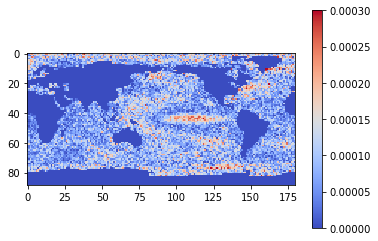

In [272]:
# Mean relevance heatmap El Nino, UN-CAPPED inputs, remove_NaN = True
plt.imshow(R_mean_nino_restored, cmap='coolwarm', interpolation='nearest', vmax=0.0003)
plt.colorbar()
plt.show()

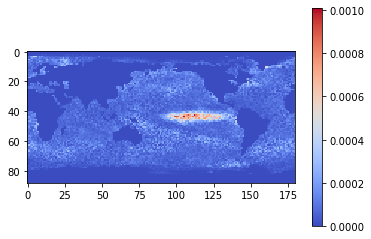

In [276]:
# Mean relevance heatmap El Nino, CAPPED inputs (cap_limit = 5), remove_NaN = True
plt.imshow(R_mean_nino_restored, cmap='coolwarm', interpolation='nearest')#, vmax=0.0005)
plt.colorbar()
plt.show()

In [277]:
### LRP with MLP on ALL La Nina samples (from train inputs)

verbose=False

## Split train inputs into El Nino / La Nina samples, according to binary target:
samples_LaNina = train_input_flat[(train_target_bin==0)[:,0]]

## Split targets accordingly:
targets_LaNina = train_target[(train_target_bin==0)[:,0]]

if verbose:
    print("samples_LaNina shape: ", samples_LaNina.shape)

# Initialize storage for mean relevance map
R_k_all = np.zeros(train_input_flat.shape[2])

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_hidden = model_weights[2]
b_hidden = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

# Define shortened models:
model_X1 = Model(inputs, hidden_1, name='model_X1')
model_X2 = Model(inputs, hidden_2, name='model_X2')
    
#Loop over El Nino samples:
for sample_id in range(len(samples_LaNina)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_LaNina))
    
    # Get current sample:
    sample = samples_LaNina[sample_id:sample_id+1,0,:]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)
    
    ## Get outputs from first and second hidden layer, X_1 and X_2, respectively:

    # Get outputs on selected sample (forward-pass) from trained short models:
    X_1 = model_X1.predict(sample)[0]
    X_2 = model_X2.predict(sample)[0]

    # Get inputs U from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:]    
    
    ### LRP on MLP: Only take positive contributions of pre-potential into account. Neglect bias terms.

    ## First output unit: EL NINO

    ## Start with connection of second HIDDEN layer (HID_2) to OUTPUT layer. 
    ## Only get relevance for first output unit here.

    # Get pre-activations z_io for hidden units x_i of HID_2 connecting to first OUTPUT unit x_o.
    # Note: Only consider positive pre-activations.
    z_io = (np.multiply(X_2,W_out[:,1])>0)*np.multiply(X_2,W_out[:,1])

    # Combine pre-activations z_io to get z_o.
    z_o = sum(z_io)

    # Get messages R_io for connections between OUTPUT with HID_2
    R_io = z_io / z_o * pred[0,1]

    # Get relevances R_i for hidden units x_i of HID_2.
    # Note: No summation necessary for layer HID_2, since only connected to first OUTPUT unit x_o.
    R_i = R_io

    ## Continue with connection of first HIDDEN layer (HID_1) to second HIDDEN layer (HID_2).

    # Get relevance R_j for 8 units x_j of HID_1 connecting to x_i units of HID_2.
    # Note: Need stabilizer (epsilon=0.01) to avoid division by zero.
    R_j = np.sum((((X_1 * W_hidden)>0) * (X_1 * W_hidden)) /
                 (np.sum((((X_1 * W_hidden)>0) * (X_1 * W_hidden)), axis=0)+0.01)
                 * R_i, axis=1)    

    ## And then take care about connection of INPUT layer to first HIDDEN layer (HID_1).

    # Get directly to relevances R_k for INPUT layer units x_k
    R_k = np.sum(((np.multiply(np.reshape(U, (in_feat,1)),W_in)>0) * (np.multiply(np.reshape(U, (in_feat,1)),W_in))) /
                 (np.sum(((np.multiply(np.reshape(U, (in_feat,1)),W_in)>0) * (np.multiply(np.reshape(U, (in_feat,1)),W_in))), axis=0))
                 * R_j, axis=1)    

    ## Add relevance for current sample to storage for ALL samples:
    R_k_all += R_k
    
## Get mean relevance over ALL samples:
R_mean_nina = R_k_all / len(samples_LaNina)

## Transform flattend relevance map back to its original 2D lat x lon grid:

# Initialize storage, take original lat / lon shape from valid gridpoints' shape:
R_mean_nina_restored = np.zeros(valid_gridpoints[0].shape)

# count variable for running through flattened vector of valid values:
k = 0

# Loop over latitude
for i in range(valid_gridpoints[0].shape[0]):
    # Loop over longitude
    for j in range(valid_gridpoints[0].shape[1]):
        if valid_gridpoints[0][i,j]==1:
            R_mean_nina_restored[i,j]=R_mean_nina[k]
            k += 1

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_878/3028011463.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


sample:  1  from  636
sample:  2  from  636
sample:  3  from  636
sample:  4  from  636
sample:  5  from  636
sample:  6  from  636
sample:  7  from  636
sample:  8  from  636
sample:  9  from  636
sample:  10  from  636
sample:  11  from  636
sample:  12  from  636
sample:  13  from  636
sample:  14  from  636
sample:  15  from  636
sample:  16  from  636
sample:  17  from  636
sample:  18  from  636
sample:  19  from  636
sample:  20  from  636
sample:  21  from  636
sample:  22  from  636
sample:  23  from  636
sample:  24  from  636
sample:  25  from  636
sample:  26  from  636
sample:  27  from  636
sample:  28  from  636
sample:  29  from  636
sample:  30  from  636
sample:  31  from  636
sample:  32  from  636
sample:  33  from  636
sample:  34  from  636
sample:  35  from  636
sample:  36  from  636
sample:  37  from  636
sample:  38  from  636
sample:  39  from  636
sample:  40  from  636
sample:  41  from  636
sample:  42  from  636
sample:  43  from  636
sample:  44  from  6

sample:  349  from  636
sample:  350  from  636
sample:  351  from  636
sample:  352  from  636
sample:  353  from  636
sample:  354  from  636
sample:  355  from  636
sample:  356  from  636
sample:  357  from  636
sample:  358  from  636
sample:  359  from  636
sample:  360  from  636
sample:  361  from  636
sample:  362  from  636
sample:  363  from  636
sample:  364  from  636
sample:  365  from  636
sample:  366  from  636
sample:  367  from  636
sample:  368  from  636
sample:  369  from  636
sample:  370  from  636
sample:  371  from  636
sample:  372  from  636
sample:  373  from  636
sample:  374  from  636
sample:  375  from  636
sample:  376  from  636
sample:  377  from  636
sample:  378  from  636
sample:  379  from  636
sample:  380  from  636
sample:  381  from  636
sample:  382  from  636
sample:  383  from  636
sample:  384  from  636
sample:  385  from  636
sample:  386  from  636
sample:  387  from  636
sample:  388  from  636
sample:  389  from  636
sample:  390  fr

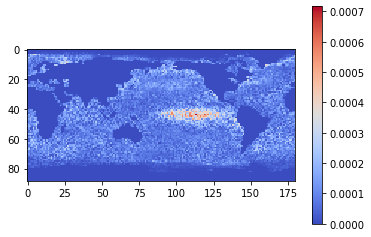

In [279]:
# Mean relevance heatmap La Nina, CAPPED inputs (cap_limit = 5), remove_NaN = True
plt.imshow(R_mean_nina_restored, cmap='coolwarm', interpolation='nearest')#, vmax=0.0004)
plt.colorbar()
plt.show()

### Classification with coupled base ESN

Inspired by [Woodward et al., 2011](https://www.sacral.c.u-tokyo.ac.jp/pdf/woodward_ivcnz_2011.pdf) paper "A Reservoir Computing approach to Image Classification using Coupled Echo State and Back-Propagation Neural Networks", we want to reproduce some of their results, but with baseESN models alone. The idea is to take a whole sst anomaly field as input for the first timestep and couple each gridpoint to exactly one reservoir unit. After that we let the reservoir swing for some timesteps without feeding additional inputs and try to use final reservoir states for image classification.

In [217]:
### Try classification of sst anomaly fields with coupled base ESN. Define parameters for ESN model upfront
verbose = True
input_length = 3 # Number of input timesteps. Note: Feed sst anomaly field as first input (t=1).
                 # For additional timesteps feed only zeros into ESN model.
                 # Need at least 2 timesteps to correctly set up ESN model with at least one recursion in reservoir.
n_layers = 1 # Number of ESN layers in the model.
n_res = train_input_flat_small.shape[2] # Number of reservoir units needs to equal number of input features (lat x lon).
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
               # Note: Not needed for coupled approach, since we manually modify input weights.
leak_rate = 1 # Leak rate used in transition function of reservoir states.
leak_rate_first_step_YN = False # If true, multiply with alpha already in calculating first timestes's res. states.
activation = 'tanh' # Desired activation function to be used in calculating reservoir state transition.
spec_radius = 0.8 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix.
sparsity = 0.3 # Sparsity of reservoir weight matrix.
in_features = train_input_flat_small.shape[2] # Number of input features, directly taken from inputs' shape.
out_features = 2 # E.g. 2 for classifying sst anomaly fields according to El Nino / La Nina events.

In [218]:
# Modify train and validation inputs by adding zeros for additional timesteps.
train_input_add = np.zeros((train_input_flat_small.shape[0], input_length - 1, train_input_flat_small.shape[2]))
val_input_add = np.zeros((val_input_flat_small.shape[0], input_length - 1, val_input_flat_small.shape[2]))

# Concat former train and validation inputs with additional zeros:

# CAPPED
train_input_adj = np.concatenate([train_input_flat_small, train_input_add], axis=1)
val_input_adj = np.concatenate([val_input_flat_small, val_input_add], axis=1)

print("train input adj. shape (samples, timesteps, features): ", train_input_adj.shape)
print("val input adj. shape (samples, timesteps, features): ", val_input_adj.shape)

train input adj. shape (samples, timesteps, features):  (831, 3, 2772)
val input adj. shape (samples, timesteps, features):  (208, 3, 2772)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1, 2772)]         0         
_________________________________________________________________
esn_6 (ESN)                  ((None, 1, 2772), (None,  7686756   
_________________________________________________________________
output (Dense)               (None, 2)                 5546      
Total params: 7,692,302
Trainable params: 7,692,302
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1, 2772)]         0         
_________________________________________________________________
esn_6 (ESN)                  ((None, 1, 2772), (None,  7686756   
Total params: 7,686,756
Traina

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_878/1169894942.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:791: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (831, 1, 2772)
shape of model output X_T (samples, n_res):  (831, 2772)

Final reservoir states in augmented notation, shape:  (831, 2773)

train_target shape (samples, output features):  (831, 2)

W_out shape:  (2772, 2)
b_out shape:  (2,)

output feature  0 , trained b_out:  [0.06942857]


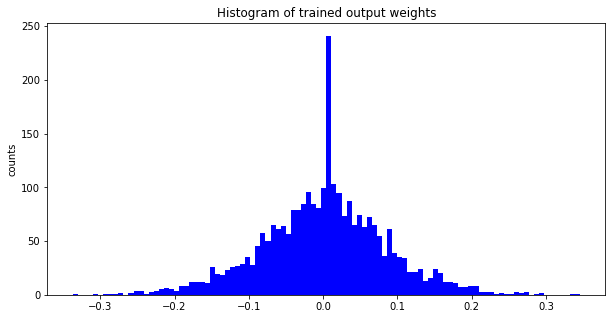


output feature  1 , trained b_out:  [0.09639918]


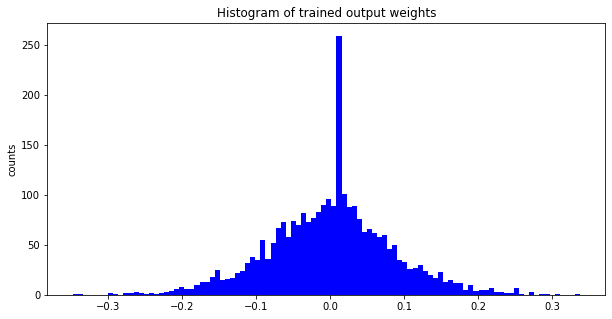


shape of val input (samples, timesteps, features):  (208, 1, 2772)
shape of train input (samples, timesteps, features):  (831, 1, 2772)

shape of model predictions on validation input (samples, 1):  (208, 2)
shape of val targets (samples, 1):  (208, 2)

train_mae:  0.0
val_mae:  0.3498

train_mse:  0.0
val_mse:  0.1815


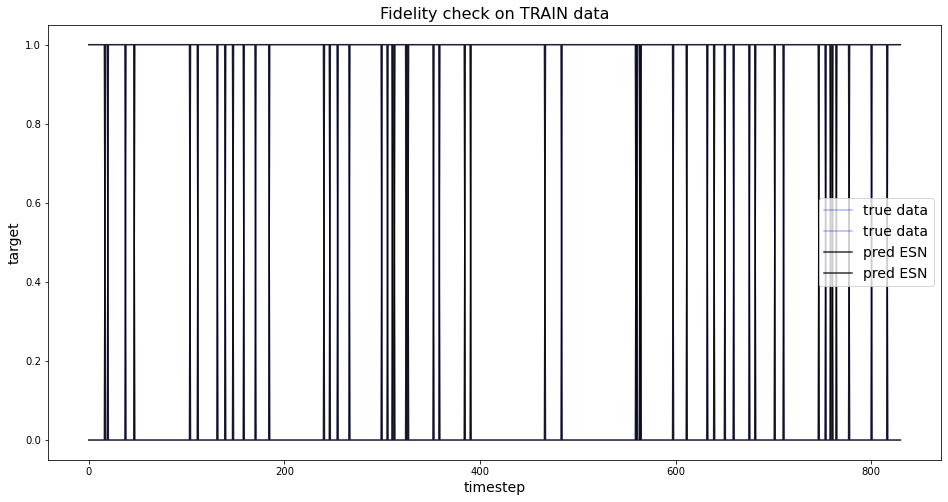

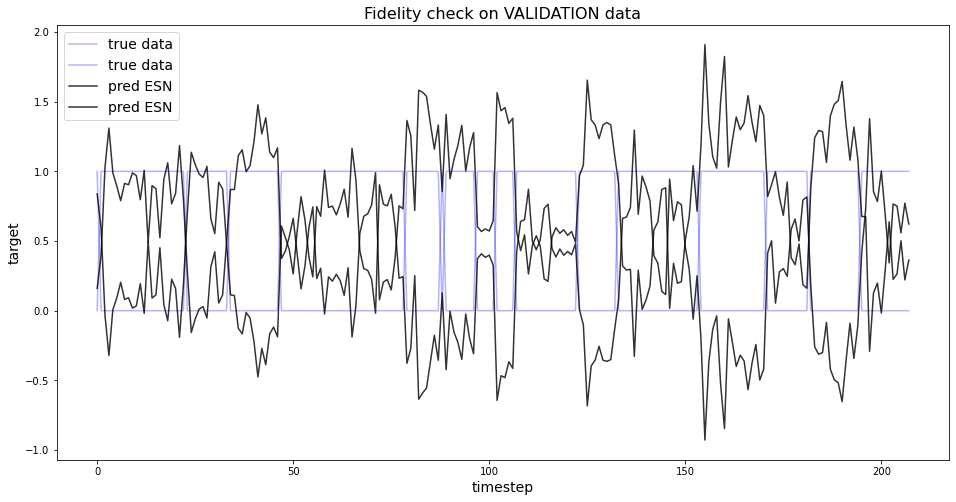

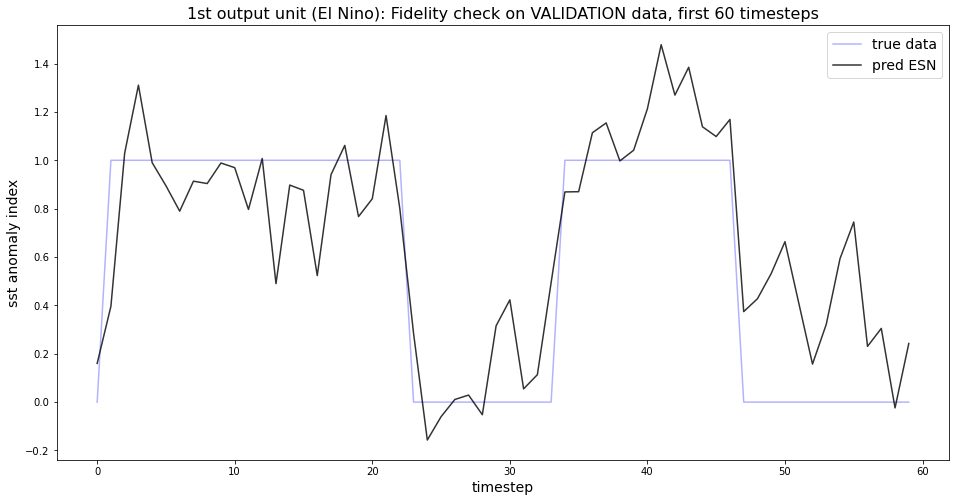

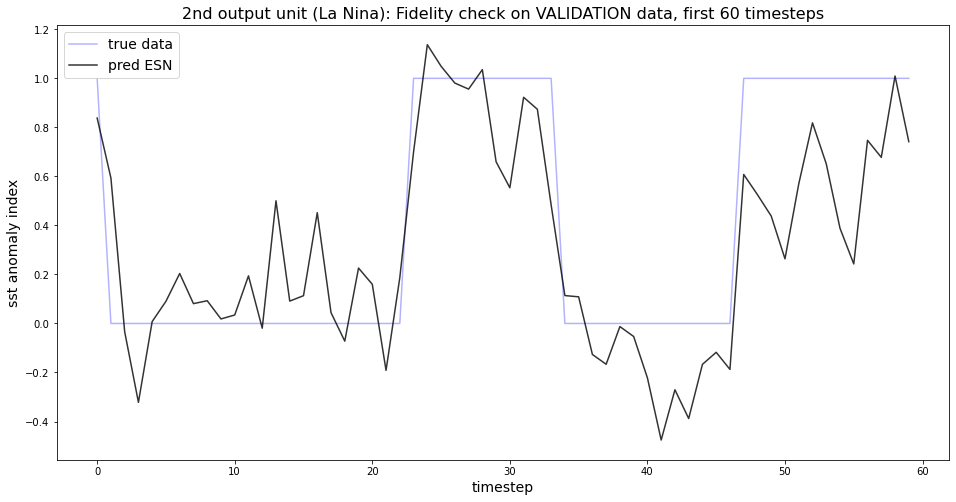

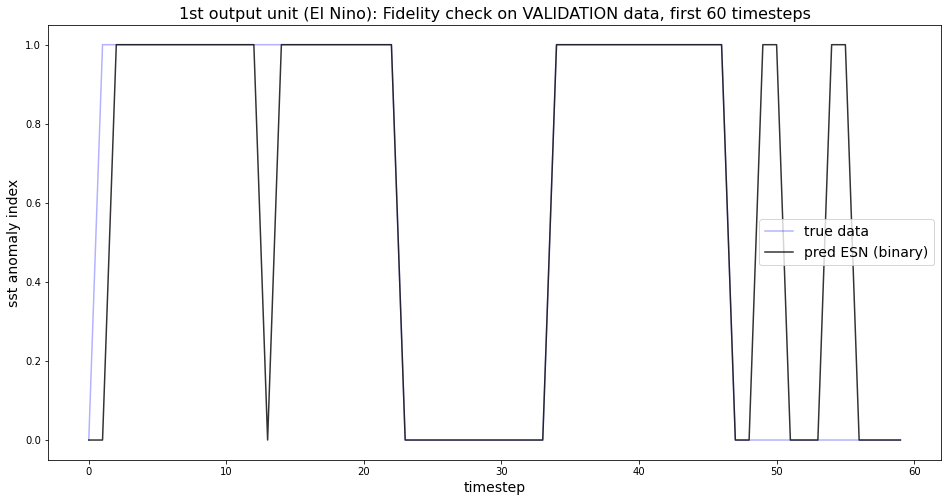

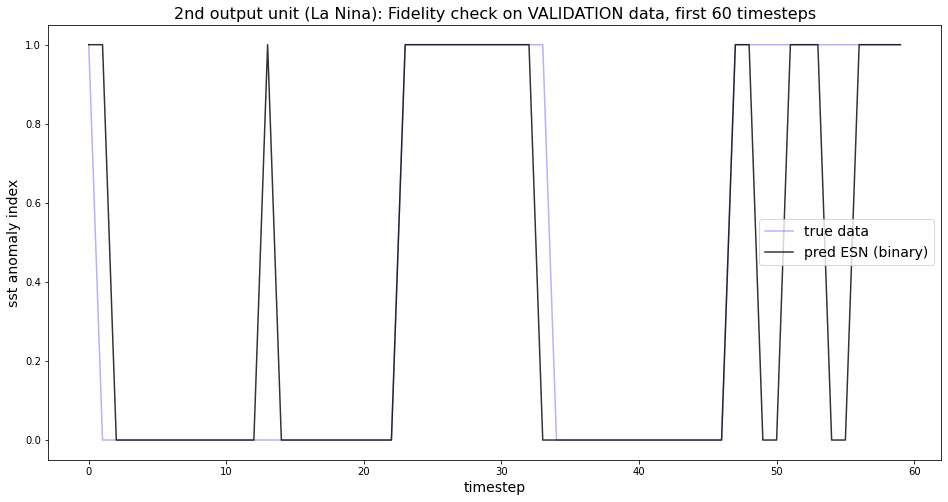


Validation accuracy:
El Nino:  0.98
La Nina:  0.6

Train accuracy:
El Nino:  1.0
La Nina:  1.0


In [216]:
#### Special case: input_length = 1

# In this case we just feed the input into our coupled base ESN and don't let the reservoir swing.
# Hence reservoir weights are not needed and cause trouble in function setESN.
# Avoid error message by setting up model manually, as follows:
   
## Set up model

# Input layer
model_inputs = Input(shape=(input_length, in_features)) # (timesteps, input features)

# Set up storage for layers' final reservoir state tensors:    
X_T_all = []

## Loop for setting up desired number of ESN layers:
for l in range(n_layers):

    # First ESN needs to be connected to model_inputs:
    if l == 0:

        # Use custom layer for setting up reservoir, returns ALL reservoir states X and FINAL reservoir states X_T.
        X, X_T = ESN(n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                     leak_rate_first_step_YN=leak_rate_first_step_YN,
                     activation=activation)(model_inputs)

        # Store resulting final reservoir states:            
        X_T_all.append(X_T)

    # Further ESN layers need to be connected to previous ESN layer:
    else:

        # Use new custom layer for setting up reservoir, again returns ALL reservoir states X and 
        # FINAL reservoir states X_T.
        X, X_T = ESN(n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                     leak_rate_first_step_YN=leak_rate_first_step_YN,
                     activation=activation)(X)

        # Store resulting final reservoir states:            
        X_T_all.append(X_T)

## Concatenate final reservoir states from ALL layers before passing result to output layer:

# In case we only have ONE layer, no concatenation is required:
if n_layers == 1:
    X_T_concat = X_T_all[0]

# Else concatenate stored final reservoir states using lambda-function:
else:
    X_T_concat = Lambda(lambda x: concatenate(x, axis=-1))(X_T_all)

# Output unit
output = Dense(units=out_features, activation=None, use_bias=True, 
               kernel_initializer=tfi.RandomUniform(minval=-W_in_lim, maxval=W_in_lim, seed=None),
               bias_initializer=tfi.RandomUniform(minval=-W_in_lim, maxval=W_in_lim, seed=None),
               name='output')(X_T_concat)

# Define complete model "model" plus short model "model_short" omitting the output layer, 
# for getting reservoir states for given inputs.
model = Model(model_inputs, output, name='model')
model_short = Model(model_inputs, X_T_concat, name='model_short')

# Define another shortened model "all_states" to get all reservoir states X from last ESN layer:
all_states = Model(model_inputs, X, name='all_states')    

# Optionally reveal model summaries
if verbose:

    # Print model summaries
    model.summary()
    model_short.summary()  
    
### Adjust input weights, set input and reservoir biases to zero.

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_out = model_weights[2]
b_out = model_weights[3]

## Check dimensions:
print("\nModel weights and biases, Dimensions:")
print("=====================================")
print("input weights W_in (input features, res. units): ", W_in.shape)
print("input biases b_in (res. units): ", b_in.shape)
print("output weights W_out (res. units, output features): ", W_out.shape)
print("output biases b_out (output features): ", b_out.shape)

## Prepare zero input biases:
b_in_zeros = np.zeros(b_in.shape)
model_weights[1] = b_in_zeros

## Prepare input weights having ONE on main diagonal and ZERO elsewhere:
W_in_diag = np.zeros((n_res,n_res))
for i in range(n_res):
    W_in_diag[i,i]=1
model_weights[0] = W_in_diag

# Get modified weights and biases back into the model
model.set_weights(model_weights)

# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input_adj, train_target_onehot, verbose=verbose)

# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input_adj, val_input_adj,
                                                                       train_target_onehot, val_target_onehot,
                                                                       verbose=verbose)

if verbose:   
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 60 timesteps for 1st output unit (El Nino)
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,0])),val_target_onehot[:60,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:60,0])),val_pred[:60,0],'k',  alpha=0.8, label='pred ESN')
    plt.title('1st output unit (El Nino): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 60 timesteps for 2nd output unit (La Nina)
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,1])),val_target_onehot[:60,1],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:60,1])),val_pred[:60,1],'k',  alpha=0.8, label='pred ESN')
    plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
# Convert to binary prediction:
train_pred_bin = (train_pred > 0.5)
val_pred_bin = (val_pred > 0.5)

if verbose:
    # Fidelity check for binary prediction and target for 1st output unit (El Nino).
    # Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,0])),val_target_onehot[:60,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:60,0])),val_pred_bin[:60,0],'k',  alpha=0.8, label='pred ESN (binary)')
    plt.title('1st output unit (El Nino): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check for binary prediction and target for 2nd output unit (La Nina).
    # Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,1])),val_target_onehot[:60,1],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:60,1])),val_pred_bin[:60,1],'k',  alpha=0.8, label='pred ESN (binary)')
    plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
## Check accuracy: How often is the correct label predicted?
## Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
## to have that same event.

# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum((val_pred_bin[:,0] == val_target_onehot[:,0]) & (val_target_onehot[:,0] == 1)) / sum(val_target_onehot[:,0] == 1)
val_acc_LaNina = sum((val_pred_bin[:,1] == val_target_onehot[:,1]) & (val_target_onehot[:,1] == 1)) / sum(val_target_onehot[:,1] == 1)


# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum((train_pred_bin[:,0] == train_target_onehot[:,0]) & (train_target_onehot[:,0] == 1)) / sum(train_target_onehot[:,0] == 1)
train_acc_LaNina = sum((train_pred_bin[:,1] == train_target_onehot[:,1]) & (train_target_onehot[:,1] == 1)) / sum(train_target_onehot[:,1] == 1)

if verbose:
    print("\nValidation accuracy:")
    print("El Nino: ", np.round(val_acc_ElNino,2))
    print("La Nina: ", np.round(val_acc_LaNina,2))

    print("\nTrain accuracy:")
    print("El Nino: ", np.round(train_acc_ElNino,2))
    print("La Nina: ", np.round(train_acc_LaNina,2))

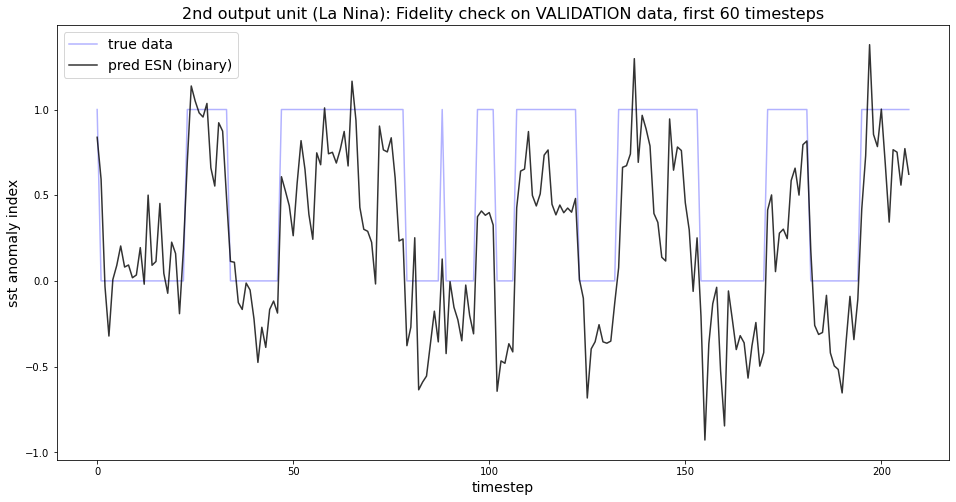

In [208]:
# Fidelity check for binary prediction and target for 2nd output unit (La Nina).
# Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target_onehot[:,1])),val_target_onehot[:,1],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred[:,1])),val_pred[:,1],'k',  alpha=0.8, label='pred ESN (binary)')
plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('sst anomaly index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [219]:
##### For input_length > 1:

# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
# and all_states (= another shortened model that gives reservoir states for ALL timesteps for all inputs).
model, model_short, all_states = setESN(input_length=input_length, in_features=in_features,
                                        out_features=out_features, n_layers=n_layers,
                                        n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                                        leak_rate_first_step_YN=leak_rate_first_step_YN,
                                        activation=activation, spec_radius=spec_radius,
                                        sparsity=sparsity, verbose=verbose)

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:712: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 3, 2772)]         0         
_________________________________________________________________
esn_7 (ESN)                  ((None, 3, 2772), (None,  15373512  
_________________________________________________________________
output (Dense)               (None, 2)                 5546      
Total params: 15,379,058
Trainable params: 15,379,058
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 3, 2772)]         0         
_________________________________________________________________
esn_7 (ESN)                  ((None, 3, 2772), (None,  15373512  
Total params: 15,373,512
Tra

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:751: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_878/1258116248.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



Model weights and biases, Dimensions:
input weights W_in (input features, res. units):  (2772, 2772)
input biases b_in (res. units):  (2772,)
reservoir weights W_res (res. units, res. units):  (2772, 2772)
reservoir biases b_res (res. units):  (2772,)
output weights W_out (res. units, output features):  (2772, 2)
output biases b_out (output features):  (2,)


/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:791: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (831, 3, 2772)
shape of model output X_T (samples, n_res):  (831, 2772)

Final reservoir states in augmented notation, shape:  (831, 2773)

train_target shape (samples, output features):  (831, 2)

W_out shape:  (2772, 2)
b_out shape:  (2,)

output feature  0 , trained b_out:  [0.49622978]


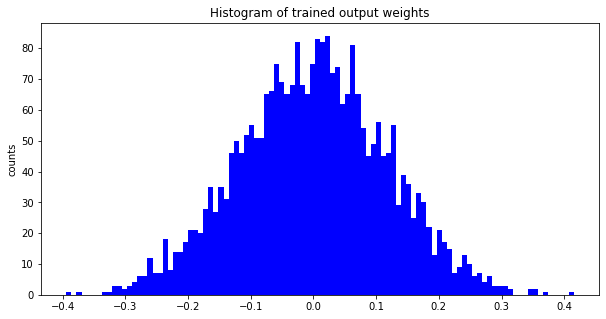


output feature  1 , trained b_out:  [0.06398901]


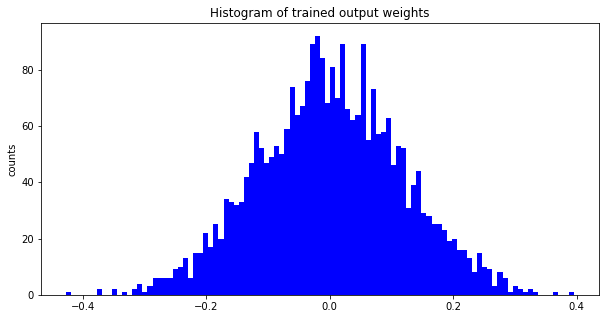


shape of val input (samples, timesteps, features):  (208, 3, 2772)
shape of train input (samples, timesteps, features):  (831, 3, 2772)

shape of model predictions on validation input (samples, 1):  (208, 2)
shape of val targets (samples, 1):  (208, 2)

train_mae:  0.0
val_mae:  0.2174

train_mse:  0.0
val_mse:  0.0783


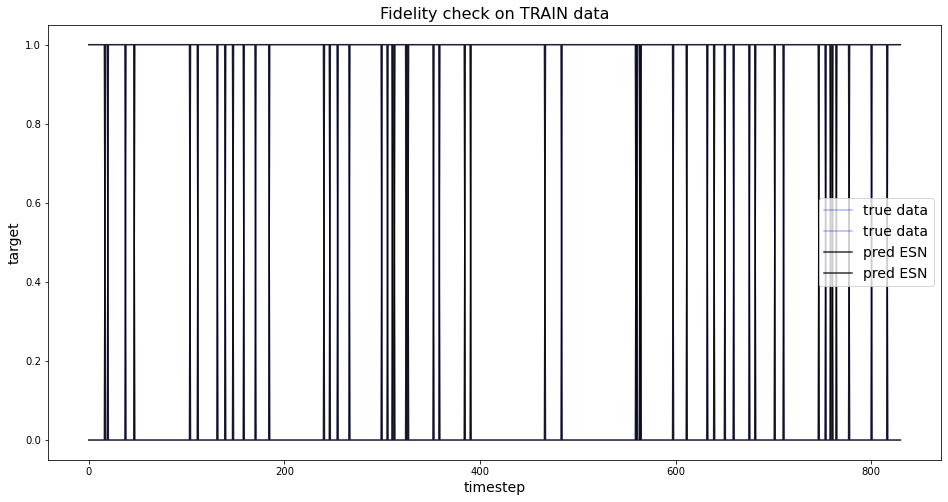

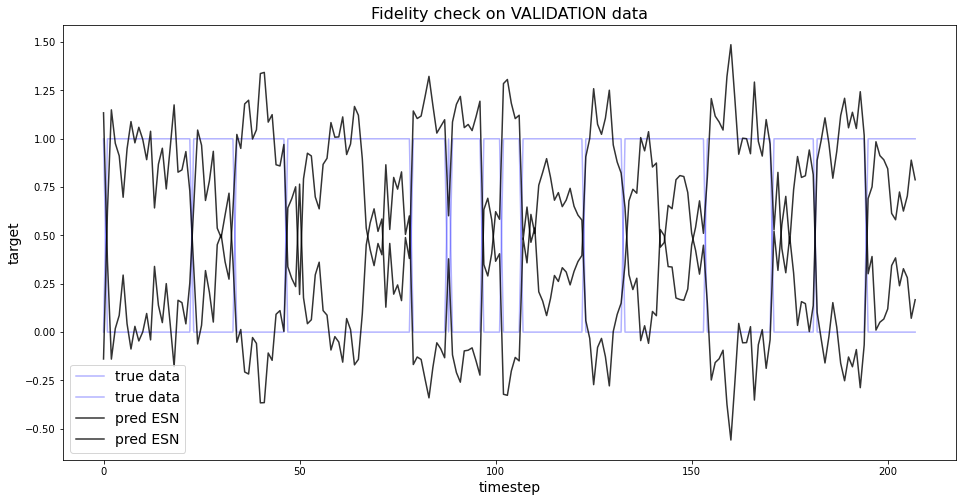

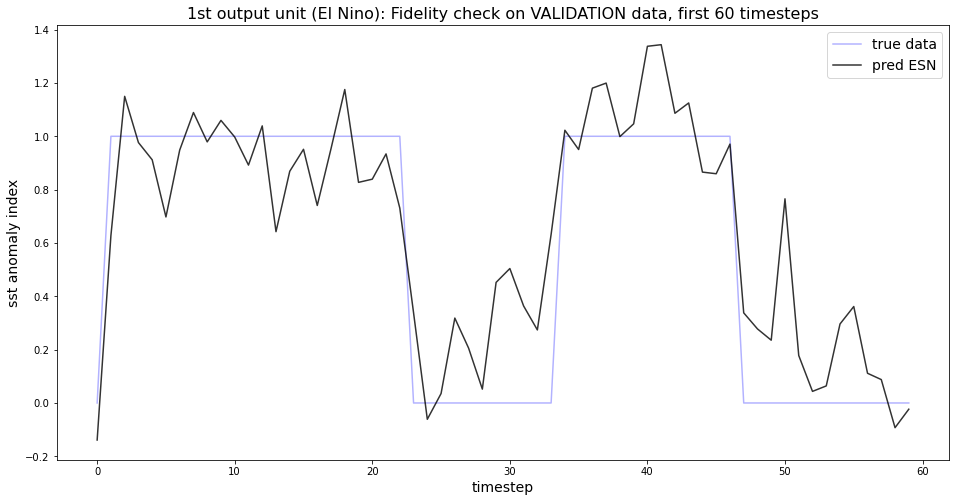

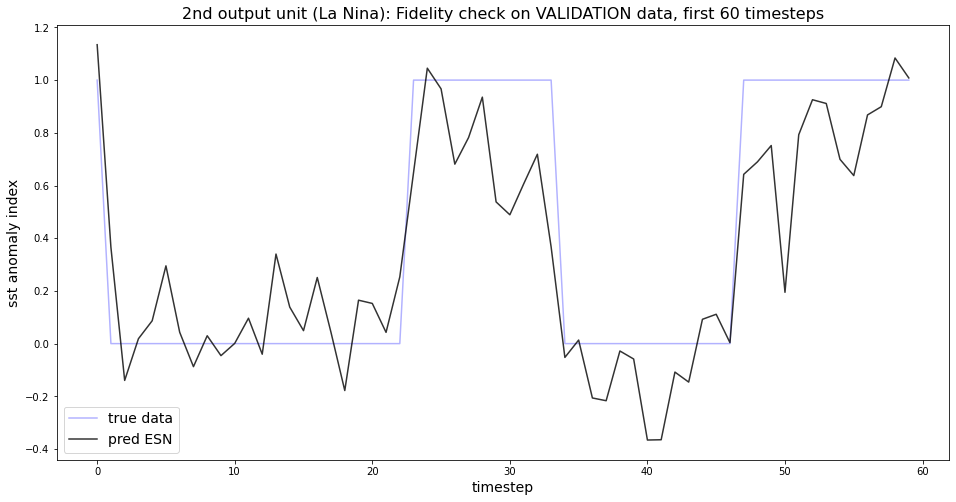

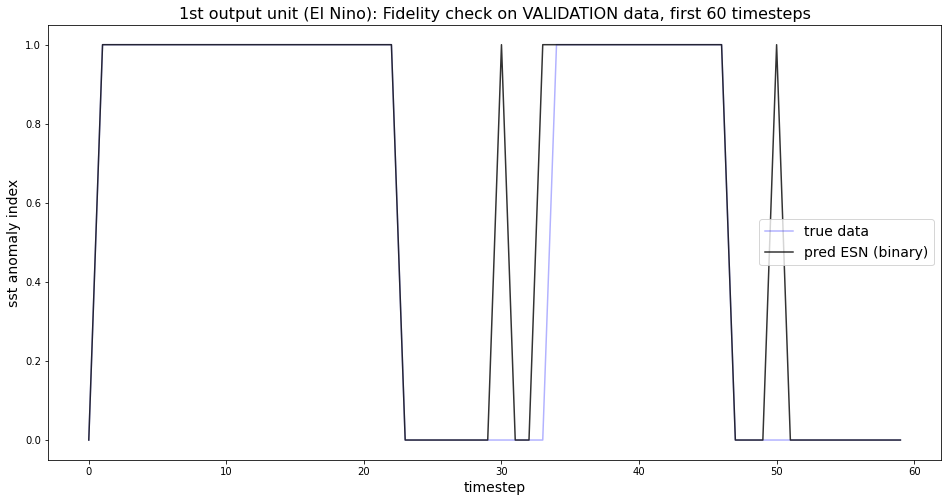

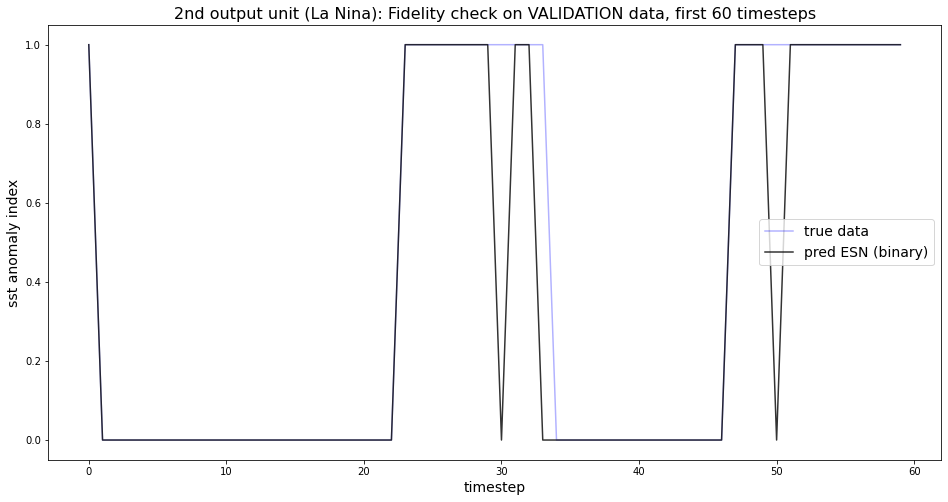


Validation accuracy:
El Nino:  1.0
La Nina:  0.82

Train accuracy:
El Nino:  1.0
La Nina:  1.0


In [220]:
### Adjust input weights, set input and reservoir biases to zero.

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Check dimensions:
print("\nModel weights and biases, Dimensions:")
print("=====================================")
print("input weights W_in (input features, res. units): ", W_in.shape)
print("input biases b_in (res. units): ", b_in.shape)
print("reservoir weights W_res (res. units, res. units): ", W_res.shape)
print("reservoir biases b_res (res. units): ", b_res.shape)
print("output weights W_out (res. units, output features): ", W_out.shape)
print("output biases b_out (output features): ", b_out.shape)

## Prepare zero input and reservoir biases:
b_in_zeros = np.zeros(b_in.shape)
b_res_zeros = np.zeros(b_res.shape)
model_weights[1] = b_in_zeros
model_weights[3] = b_res_zeros

## Prepare input weights having ONE on main diagonal and ZERO elsewhere:
W_in_diag = np.zeros((n_res,n_res))
for i in range(n_res):
    W_in_diag[i,i]=1
model_weights[0] = W_in_diag

# Get modified weights and biases back into the model
model.set_weights(model_weights)

# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input_adj, train_target_onehot, verbose=verbose)

# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input_adj, val_input_adj,
                                                                       train_target_onehot, val_target_onehot,
                                                                       verbose=verbose)

if verbose:   
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 60 timesteps for 1st output unit (El Nino)
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,0])),val_target_onehot[:60,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:60,0])),val_pred[:60,0],'k',  alpha=0.8, label='pred ESN')
    plt.title('1st output unit (El Nino): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 60 timesteps for 2nd output unit (La Nina)
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,1])),val_target_onehot[:60,1],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:60,1])),val_pred[:60,1],'k',  alpha=0.8, label='pred ESN')
    plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
# Convert to binary prediction:
train_pred_bin = (train_pred > 0.5)
val_pred_bin = (val_pred > 0.5)

if verbose:
    # Fidelity check for binary prediction and target for 1st output unit (El Nino).
    # Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,0])),val_target_onehot[:60,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:60,0])),val_pred_bin[:60,0],'k',  alpha=0.8, label='pred ESN (binary)')
    plt.title('1st output unit (El Nino): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check for binary prediction and target for 2nd output unit (La Nina).
    # Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,1])),val_target_onehot[:60,1],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:60,1])),val_pred_bin[:60,1],'k',  alpha=0.8, label='pred ESN (binary)')
    plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
## Check accuracy: How often is the correct label predicted?
## Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
## to have that same event.

# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum((val_pred_bin[:,0] == val_target_onehot[:,0]) & (val_target_onehot[:,0] == 1)) / sum(val_target_onehot[:,0] == 1)
val_acc_LaNina = sum((val_pred_bin[:,1] == val_target_onehot[:,1]) & (val_target_onehot[:,1] == 1)) / sum(val_target_onehot[:,1] == 1)


# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum((train_pred_bin[:,0] == train_target_onehot[:,0]) & (train_target_onehot[:,0] == 1)) / sum(train_target_onehot[:,0] == 1)
train_acc_LaNina = sum((train_pred_bin[:,1] == train_target_onehot[:,1]) & (train_target_onehot[:,1] == 1)) / sum(train_target_onehot[:,1] == 1)

if verbose:
    print("\nValidation accuracy:")
    print("El Nino: ", np.round(val_acc_ElNino,2))
    print("La Nina: ", np.round(val_acc_LaNina,2))

    print("\nTrain accuracy:")
    print("El Nino: ", np.round(train_acc_ElNino,2))
    print("La Nina: ", np.round(train_acc_LaNina,2))

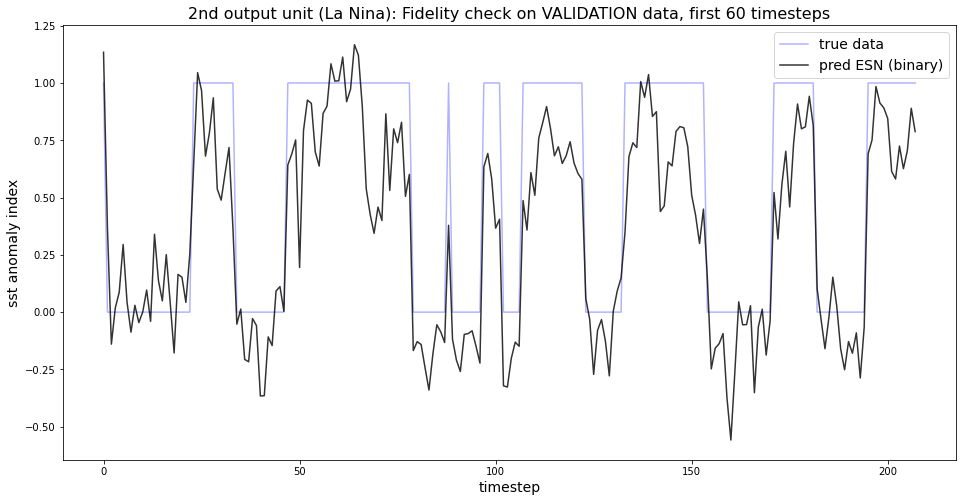

In [221]:
# Fidelity check for binary prediction and target for 2nd output unit (La Nina).
# Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target_onehot[:,1])),val_target_onehot[:,1],'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred[:,1])),val_pred[:,1],'k',  alpha=0.8, label='pred ESN (binary)')
plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('sst anomaly index', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### LRP on coupled baseESN

Nevertheless we are interested in relevance maps from our coupled baseESN. So stick to $T=3$ timesteps and try LRP. In our setup we worked with leak_rate $\alpha=1$ to simplify reservoir state transition to:

$$x(t=1) = act[u(t=1)W_{in}]$$ and $$x(t>1) = act[x(t-1)W_{res}]$$

since we also set input and reservoir biases to zero. Have **one-hot** targets. Compute relevance separately for both output units, hence for El Nino / La Nina samples separately. From third part of this experiment (**--> ESN_exp08_LRP_part3.ipynb**) we know to use the following propagation rule to pass information backward from layer $j$ to previous layer $i$:

$$R_i = \sum_j \frac{z_{ij}^+}{\sum_i z_{ij}^+}R_j$$

Here we only take positive contributions of pre-activations $z_{ij}^+ = (a_i w_{ij})^+$ into account. Aim to find some nice and reasonable structure in relevance map, **highlighting Nino region**,.

Sample dimensions and prediction:
raw sample shape (1, timesteps, features):  (1, 3, 2772)
number of timesteps:  3
number of input features in_feat:  2772
number of res. units n_res:  2772
leak rate alpha:  1
model prediction on sample, 1st output unit (El Nino):  0.044
model prediction on sample, 2nd output unit (La Nina):  0.925

Model weights and biases, Dimensions:
input weights W_in (input features, res. units):  (2772, 2772)
input biases b_in (res. units):  (2772,)
reservoir weights W_res (res. units, res. units):  (2772, 2772)
reservoir biases b_res (res. units):  (2772,)
output weights W_out (res. units, output features):  (2772, 2)
output biases b_out (output features):  (2,)

Tensor shapes:
input tensor U (timesteps, input features):  (3, 2772)
all res. states X (timesteps, res. units):  (3, 2772)
activations ACT (timesteps, res. units):  (3, 2772)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_878/186622245.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


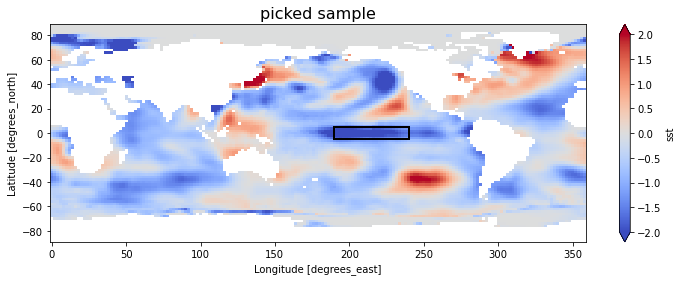

In [234]:
### Pick out ONE El Nino sample to be analysed:
#sample_id = 40 # number 40 of validation inputs --> El Nino sample
sample_id = 52 # number 52 of validation inputs --> La Nina sample
sample = val_input_adj[sample_id:sample_id+1,:,:]

## If feeding the sample column-wise is desired, need to swap lat <-> lon for input sample:
#sample = np.swapaxes(sample, 1, 2)

# Plot sample input in its original size
fig, ax = plt.subplots(figsize=(12, 4))
sst_anomaly_fields_NinoNina[sample_id].name = 'sst anomaly deg Celsius'
sst_anomaly_fields_NinoNina[sample_id].plot(ax=ax, cmap='coolwarm', vmax=2, vmin=-2)
plt.title('picked sample', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = sample.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = sample.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

# Have trained model as pre-requisite. For BOTH output units (El Nino / La Nina) check prediction on picked sample:
pred = model.predict(sample)

## Check dimensions and prediction:
print("Sample dimensions and prediction:")
print("=================================")
print("raw sample shape (1, timesteps, features): ", sample.shape)
print("number of timesteps: ", timesteps)
print("number of input features in_feat: ", in_feat)
print("number of res. units n_res: ", n_res)
print("leak rate alpha: ", a)
print("model prediction on sample, 1st output unit (El Nino): ", np.round(pred[0,0],3))
print("model prediction on sample, 2nd output unit (La Nina): ", np.round(pred[0,1],3))

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

### Extract input / reservoir / output weights and bias(es):

## Note: Have reservoir weights only in case of input_length > 1, here T > 0.

if T > 0:
    W_in = model_weights[0]
    b_in = model_weights[1]
    W_res = model_weights[2]
    b_res = model_weights[3]
    W_out = model_weights[4]
    b_out = model_weights[5]
    
    ## Check dimensions:
    print("\nModel weights and biases, Dimensions:")
    print("=====================================")
    print("input weights W_in (input features, res. units): ", W_in.shape)
    print("input biases b_in (res. units): ", b_in.shape)
    print("reservoir weights W_res (res. units, res. units): ", W_res.shape)
    print("reservoir biases b_res (res. units): ", b_res.shape)
    print("output weights W_out (res. units, output features): ", W_out.shape)
    print("output biases b_out (output features): ", b_out.shape)

else:
    W_in = model_weights[0]
    b_in = model_weights[1]
    W_out = model_weights[2]
    b_out = model_weights[3]

    ## Check dimensions:
    print("\nModel weights and biases, Dimensions:")
    print("=====================================")
    print("input weights W_in (input features, res. units): ", W_in.shape)
    print("input biases b_in (res. units): ", b_in.shape)
    print("output weights W_out (res. units, output features): ", W_out.shape)
    print("output biases b_out (output features): ", b_out.shape)

## Set tensors for inputs U, activation layer ACT and all reservoir states X:

# Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
U = sample[0,:,:]

# Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
X = all_states.predict(sample)[0,:,:]

# Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

# Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
ACT = (X - (1 - a) * X_prime) / a

# Check dimensions:
print("\nTensor shapes:")
print("==============")
print("input tensor U (timesteps, input features): ", U.shape)
print("all res. states X (timesteps, res. units): ", X.shape)
print("activations ACT (timesteps, res. units): ", ACT.shape)

In [235]:
sample.shape

(1, 3, 2772)

In [236]:
## Transform flattend sample back to its original 2D lat x lon grid:

# Initialize storage, take original lat / lon shape from valid gridpoints' shape:
sample_restored = np.zeros(valid_gridpoints_small[0].shape)

# count variable for running through flattened vector of valid values:
k = 0

# Loop over latitude
for i in range(valid_gridpoints_small[0].shape[0]):
    # Loop over longitude
    for j in range(valid_gridpoints_small[0].shape[1]):
        if valid_gridpoints_small[0][i,j]==1:
            sample_restored[i,j]=sample[0,0,k]
            k += 1
            
# Set weights of former NaN values' gridpoints to -1, to highlight continents' shapes
sample_restored[valid_gridpoints_small[0]==0] = -1

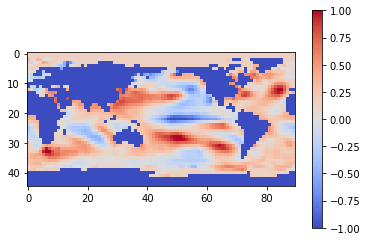

In [237]:
# Plot sample in reduced size:
plt.imshow(sample_restored, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

In [232]:
### LRP on coupled baseESN: Only take positive contributions of pre-potential into account.
### First output unit: EL NINO

## NOTE: Use first output units prediction!

## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to first OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
       sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
         / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])

### Only in case of input_lenght > 1, hence T > 0:
if T > 0:    
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)


    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    # Store other relevances for plausibility check:
    R_i_sum = []
    R_j_sum = []
    R_k_sum = []
    R_j_1_sum = []
    R_j_2_sum = []
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.
    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        # Store other relevances for plausibility check:
        R_i_sum.append(sum(R_i))
        R_j_sum.append(sum(R_j))
        R_k_sum.append(sum(R_k))
        R_j_1_sum.append(sum(R_j_1))
        R_j_2_sum.append(sum(R_j_2))

    ## Now take care of first timestep: In this step we only feed the inputs into the model. There is no recursion
    ## of reservoir states, since X(0) doesn't exist.

    # Get relevances R_i for n_res units x_i of ACT(1). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j

    # Get relevances R_k for in_feat input units x_k of U(1). Note: Each input is only connected to a
    # single corresponding value of ACT(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_k = R_i

### In case of of input_length = 1: 
else:    

    # Get relevances R_k for in_feat input units x_k of U(1). Note: Each input is only connected to a
    # single corresponding value of ACT(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_k = R_i

    # Store other relevances for plausibility check:
    R_i_sum = []
    R_k_sum = []
    R_i_sum.append(sum(R_i))
    R_k_sum.append(sum(R_k))
    
## Transform flattend relevance map back to its original 2D lat x lon grid:

# Initialize storage, take original lat / lon shape from valid gridpoints' shape:
R_k_restored = np.zeros(valid_gridpoints_small[0].shape)

# count variable for running through flattened vector of valid values:
k = 0

# Loop over latitude
for i in range(valid_gridpoints_small[0].shape[0]):
    # Loop over longitude
    for j in range(valid_gridpoints_small[0].shape[1]):
        if valid_gridpoints_small[0][i,j]==1:
            R_k_restored[i,j]=R_k[k]
            k += 1
            
# Plausibility check, whether Layer relevance is conserved:
print("sum of relevance R_i: ", np.round(sum(R_i), 3))
print("sum of relevance R_j: ", np.round(sum(R_j), 3))
print("sum of relevance R_k: ", np.round(sum(R_k), 3))

sum of relevance R_i:  1.337
sum of relevance R_j:  1.337
sum of relevance R_k:  1.337


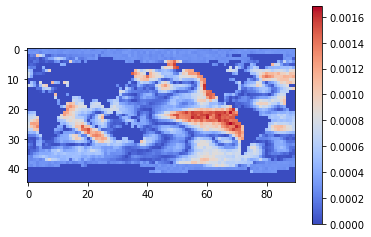

In [233]:
# Relevance heatmap
plt.imshow(R_k_restored, cmap='coolwarm', interpolation='nearest')#, vmax=0.001)
plt.colorbar()
plt.show()

In [238]:
### LRP on coupled baseESN: Only take positive contributions of pre-potential into account.
### Second output unit: LA NINA

## NOTE: Use second output units prediction!

## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to first OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1]) /
       sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred[0,1])
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])
         / sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred[0,1])

### Only in case of input_lenght > 1, hence T > 0:
if T > 0:  
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)


    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    # Store other relevances for plausibility check:
    R_i_sum = []
    R_j_sum = []
    R_k_sum = []
    R_j_1_sum = []
    R_j_2_sum = []
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.
    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        # Store other relevances for plausibility check:
        R_i_sum.append(sum(R_i))
        R_j_sum.append(sum(R_j))
        R_k_sum.append(sum(R_k))
        R_j_1_sum.append(sum(R_j_1))
        R_j_2_sum.append(sum(R_j_2))

    ## Now take care of first timestep: In this step we only feed the inputs into the model. There is no recursion
    ## of reservoir states, since X(0) doesn't exist.

    # Get relevances R_i for n_res units x_i of ACT(1). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j

    # Get relevances R_k for in_feat input units x_k of U(1). Note: Each input is only connected to a
    # single corresponding value of ACT(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_k = R_i
    
### In case of of input_length = 1: 
else:    

    # Get relevances R_k for in_feat input units x_k of U(1). Note: Each input is only connected to a
    # single corresponding value of ACT(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_k = R_i

    # Store other relevances for plausibility check:
    R_i_sum = []
    R_k_sum = []
    R_i_sum.append(sum(R_i))
    R_k_sum.append(sum(R_k))
    
## Transform flattend relevance map back to its original 2D lat x lon grid:

# Initialize storage, take original lat / lon shape from valid gridpoints' shape:
R_k_restored = np.zeros(valid_gridpoints_small[0].shape)

# count variable for running through flattened vector of valid values:
k = 0

# Loop over latitude
for i in range(valid_gridpoints_small[0].shape[0]):
    # Loop over longitude
    for j in range(valid_gridpoints_small[0].shape[1]):
        if valid_gridpoints_small[0][i,j]==1:
            R_k_restored[i,j]=R_k[k]
            k += 1
            
# Plausibility check, whether Layer relevance is conserved:
print("sum of relevance R_i: ", np.round(sum(R_i), 3))
print("sum of relevance R_j: ", np.round(sum(R_j), 3))
print("sum of relevance R_k: ", np.round(sum(R_k), 3))

sum of relevance R_i:  0.925
sum of relevance R_j:  0.925
sum of relevance R_k:  0.925


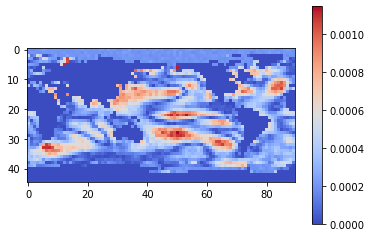

In [239]:
# Plot relevance map
plt.imshow(R_k_restored, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

### Discussion: LRP with coupled baseESN on onehot targets

Considering **positive pre-activations** for backpropagating relevance yields nice structure in resulting relevance maps for both El Nino and La Nina samples. 

**capping** sst anomaly fields' values to only work with values inside some specified quantile limits **is essentiel**, to enable reasonable scaling of inputs!

#### Artefacts / stripes in relevance map

Don't see any artefacts in terms of stripes, as in other approach with feeding input samples column- or row-wise into base ESN model. But find some coarse grain resolution, as seen for plain vanilla linear regression or MLP.
**--> Could try to work with original resolution of input samples**, but need to find more efficient way to compute eigenvalues of reservoir weights, before. Or switch to HPC!

#### Relevance for La Nina samples

Need to compute relevance maps separately for both output units, hence for El Nino (1st unit) and La Nina (2nd unit) samples.

### Coupled baseESN: Get mean relevance maps for ALL El Nino / La Nina samples (from train inputs)

In [241]:
### LRP with coupled baseESN on ALL El Nino samples (from train inputs)

verbose=False

## Split train inputs into El Nino / La Nina samples, according to binary target:
samples_ElNino = train_input_adj[(train_target_bin==1)[:,0]]

## Split targets accordingly:
targets_ElNino = train_target[(train_target_bin==1)[:,0]]

if verbose:
    print("samples_ElNino shape: ", samples_ElNino.shape)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = samples_ElNino.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = samples_ElNino.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Initialize storage for mean relevance over all ElNino samples.
R_all_mean = np.zeros(in_feat)
    
#Loop over El Nino samples:
for sample_id in range(len(samples_ElNino)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_ElNino))
    
    # Get current sample:
    sample = samples_ElNino[sample_id:sample_id+1]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)
    
    ## Set tensors for inputs U, activation layer ACT and all reservoir states X:

    # Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:,:]

    # Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
    X = all_states.predict(sample)[0,:,:]

    # Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
    X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

    # Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
    ACT = (X - (1 - a) * X_prime) / a
    
    ### LRP on baseESN: Second attempt, only consider positive contributions of pre-potential into account.

    ## Start with layer T

    # Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
    # connecting to first OUTPUT unit x_o:
    R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
           sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])
    R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
             / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])

    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)


    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    # Store other relevances for plausibility check:
    R_i_sum = []
    R_j_sum = []
    R_k_sum = []
    R_j_1_sum = []
    R_j_2_sum = []
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.
    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        # Store other relevances for plausibility check:
        R_i_sum.append(sum(R_i))
        R_j_sum.append(sum(R_j))
        R_k_sum.append(sum(R_k))
        R_j_1_sum.append(sum(R_j_1))
        R_j_2_sum.append(sum(R_j_2))

    ## Now take care of first timestep: In this step we only feed the inputs into the model. There is no recursion
    ## of reservoir states, since X(0) doesn't exist.

    # Get relevances R_i for n_res units x_i of ACT(1). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j

    # Get relevances R_k for in_feat input units x_k of U(1). Note: Each input is only connected to a
    # single corresponding value of ACT(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_k = R_i
        
    ## Add relevance for current sample to storage for ALL samples:
    R_all_mean += R_k

## Get mean relevance over ALL samples:
R_all_mean_nino = R_all_mean / len(samples_ElNino)

## Transform flattend relevance map back to its original 2D lat x lon grid:

# Initialize storage, take original lat / lon shape from valid gridpoints' shape:
R_mean_nino_restored = np.zeros(valid_gridpoints_small[0].shape)

# count variable for running through flattened vector of valid values:
k = 0

# Loop over latitude
for i in range(valid_gridpoints_small[0].shape[0]):
    # Loop over longitude
    for j in range(valid_gridpoints_small[0].shape[1]):
        if valid_gridpoints_small[0][i,j]==1:
            R_mean_nino_restored[i,j]=R_all_mean_nino[k]
            k += 1
            

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_878/277808877.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


sample:  1  from  195
sample:  2  from  195
sample:  3  from  195
sample:  4  from  195
sample:  5  from  195
sample:  6  from  195
sample:  7  from  195
sample:  8  from  195
sample:  9  from  195
sample:  10  from  195
sample:  11  from  195
sample:  12  from  195
sample:  13  from  195
sample:  14  from  195
sample:  15  from  195
sample:  16  from  195
sample:  17  from  195
sample:  18  from  195
sample:  19  from  195
sample:  20  from  195
sample:  21  from  195
sample:  22  from  195
sample:  23  from  195
sample:  24  from  195
sample:  25  from  195
sample:  26  from  195
sample:  27  from  195
sample:  28  from  195
sample:  29  from  195
sample:  30  from  195
sample:  31  from  195
sample:  32  from  195
sample:  33  from  195
sample:  34  from  195
sample:  35  from  195
sample:  36  from  195
sample:  37  from  195
sample:  38  from  195
sample:  39  from  195
sample:  40  from  195
sample:  41  from  195
sample:  42  from  195
sample:  43  from  195
sample:  44  from  1

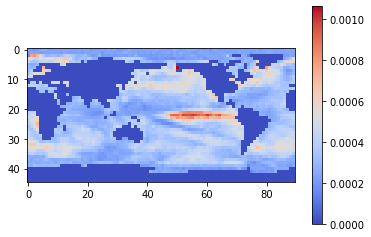

In [248]:
# Coupled baseESN, tanh activation, T=3
# Mean relevance heatmap El Nino, CAPPED inputs (cap_limits = [-2.26, 1.68]), scaled to [-1,1], remove_NaN = True
plt.imshow(R_mean_nino_restored, cmap='coolwarm', interpolation='nearest')#, vmax=0.0005)
plt.colorbar()
plt.show()

In [249]:
### LRP with coupled baseESN on ALL La Nina samples (from train inputs)

verbose=False

## Split train inputs into El Nino / La Nina samples, according to binary target:
samples_LaNina = train_input_adj[(train_target_bin==0)[:,0]]

## Split targets accordingly:
targets_LaNina = train_target[(train_target_bin==0)[:,0]]

if verbose:
    print("samples_LaNina shape: ", samples_LaNina.shape)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = samples_LaNina.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = samples_LaNina.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Initialize storage for mean relevance over all ElNino samples.
R_all_mean = np.zeros(in_feat)
    
#Loop over El Nino samples:
for sample_id in range(len(samples_LaNina)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_LaNina))
    
    # Get current sample:
    sample = samples_LaNina[sample_id:sample_id+1]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)
    
    ## Set tensors for inputs U, activation layer ACT and all reservoir states X:

    # Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:,:]

    # Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
    X = all_states.predict(sample)[0,:,:]

    # Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
    X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

    # Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
    ACT = (X - (1 - a) * X_prime) / a
    
    ### LRP on baseESN: Second attempt, only consider positive contributions of pre-potential into account.

    ## Start with layer T

    # Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
    # connecting to first OUTPUT unit x_o:
    R_i = (a * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1]) /
           sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred[0,1])
    R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])
             / sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred[0,1])

    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)


    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    # Store other relevances for plausibility check:
    R_i_sum = []
    R_j_sum = []
    R_k_sum = []
    R_j_1_sum = []
    R_j_2_sum = []
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.
    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        # Store other relevances for plausibility check:
        R_i_sum.append(sum(R_i))
        R_j_sum.append(sum(R_j))
        R_k_sum.append(sum(R_k))
        R_j_1_sum.append(sum(R_j_1))
        R_j_2_sum.append(sum(R_j_2))

    ## Now take care of first timestep: In this step we only feed the inputs into the model. There is no recursion
    ## of reservoir states, since X(0) doesn't exist.

    # Get relevances R_i for n_res units x_i of ACT(1). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j

    # Get relevances R_k for in_feat input units x_k of U(1). Note: Each input is only connected to a
    # single corresponding value of ACT(1), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_k = R_i
        
    ## Add relevance for current sample to storage for ALL samples:
    R_all_mean += R_k

## Get mean relevance over ALL samples:
R_all_mean_nina = R_all_mean / len(samples_LaNina)

## Transform flattend relevance map back to its original 2D lat x lon grid:

# Initialize storage, take original lat / lon shape from valid gridpoints' shape:
R_mean_nina_restored = np.zeros(valid_gridpoints_small[0].shape)

# count variable for running through flattened vector of valid values:
k = 0

# Loop over latitude
for i in range(valid_gridpoints_small[0].shape[0]):
    # Loop over longitude
    for j in range(valid_gridpoints_small[0].shape[1]):
        if valid_gridpoints_small[0][i,j]==1:
            R_mean_nina_restored[i,j]=R_all_mean_nina[k]
            k += 1
            

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_878/3658711110.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


sample:  1  from  636
sample:  2  from  636
sample:  3  from  636
sample:  4  from  636
sample:  5  from  636
sample:  6  from  636
sample:  7  from  636
sample:  8  from  636
sample:  9  from  636
sample:  10  from  636
sample:  11  from  636
sample:  12  from  636
sample:  13  from  636
sample:  14  from  636
sample:  15  from  636
sample:  16  from  636
sample:  17  from  636
sample:  18  from  636
sample:  19  from  636
sample:  20  from  636
sample:  21  from  636
sample:  22  from  636
sample:  23  from  636
sample:  24  from  636
sample:  25  from  636
sample:  26  from  636
sample:  27  from  636
sample:  28  from  636
sample:  29  from  636
sample:  30  from  636
sample:  31  from  636
sample:  32  from  636
sample:  33  from  636
sample:  34  from  636
sample:  35  from  636
sample:  36  from  636
sample:  37  from  636
sample:  38  from  636
sample:  39  from  636
sample:  40  from  636
sample:  41  from  636
sample:  42  from  636
sample:  43  from  636
sample:  44  from  6

sample:  347  from  636
sample:  348  from  636
sample:  349  from  636
sample:  350  from  636
sample:  351  from  636
sample:  352  from  636
sample:  353  from  636
sample:  354  from  636
sample:  355  from  636
sample:  356  from  636
sample:  357  from  636
sample:  358  from  636
sample:  359  from  636
sample:  360  from  636
sample:  361  from  636
sample:  362  from  636
sample:  363  from  636
sample:  364  from  636
sample:  365  from  636
sample:  366  from  636
sample:  367  from  636
sample:  368  from  636
sample:  369  from  636
sample:  370  from  636
sample:  371  from  636
sample:  372  from  636
sample:  373  from  636
sample:  374  from  636
sample:  375  from  636
sample:  376  from  636
sample:  377  from  636
sample:  378  from  636
sample:  379  from  636
sample:  380  from  636
sample:  381  from  636
sample:  382  from  636
sample:  383  from  636
sample:  384  from  636
sample:  385  from  636
sample:  386  from  636
sample:  387  from  636
sample:  388  fr

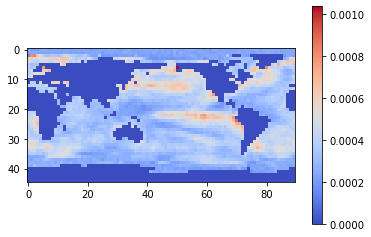

In [251]:
# Coupled baseESN, tanh activation, T=3
# Mean relevance heatmap El Nino, CAPPED inputs (cap_limits = [-2.26, 1.68]), scaled to [-1,1], remove_NaN = True
plt.imshow(R_mean_nina_restored, cmap='coolwarm', interpolation='nearest')#, vmax=0.0005)
plt.colorbar()
plt.show()

### Classification with baseESN (column-wise) on onehot targets


#### Base parameter setup

* n_res = 300
* W_in_lim = 0.1
* leak_rate = 0.005
* spec_radius = 0.8
* sparsity = 0.3

Use these parameters on normalmized sst anomaly fields, **swapped longitude and latitude** and **scaled to [-1,1]** as inputs and **one-hot targets**, together with **tanh** activation. Multiplication with $\alpha$ is omitted in calculating first timestes's reservoir states (*leak_rate_first_step_YN = False*).

In [285]:
# Try base ESN (column-wise) with scaling to [-1,1]. Have swapped inputs only scaled to [0,1], by default.
# Overwrite scaling from upfront input preparation:
train_input_swap = np.swapaxes(train_input, 1, 2)
val_input_swap = np.swapaxes(val_input, 1, 2)

In [286]:
### Try classification of sst anomaly fields with base ESN. Define parameters for ESN model upfront
verbose = True
input_length = train_input_swap.shape[1] # Number of input timesteps, directly taken from inputs' shape.
n_layers = 1 # Number of ESN layers in the model.
n_res = 300 # Number of reservoir units.
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.005 # Leak rate used in transition function of reservoir states.
leak_rate_first_step_YN = False # If true, multiply with alpha already in calculating first timestes's res. states.
activation = 'tanh' # Desired activation function to be used in calculating reservoir state transition.
spec_radius = 0.8 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix.
sparsity = 0.3 # Sparsity of reservoir weight matrix.
in_features = train_input_swap.shape[2] # Number of input features, directly taken from inputs' shape.
out_features = 2 # E.g. 2 for classifying sst anomaly fields according to El Nino / La Nina events.

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:712: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:751: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 180, 89)]         0         
_________________________________________________________________
esn_8 (ESN)                  ((None, 180, 300), (None, 117300    
_________________________________________________________________
output (Dense)               (None, 2)                 602       
Total params: 117,902
Trainable params: 117,902
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 180, 89)]         0         
_________________________________________________________________
esn_8 (ESN)                  ((None, 180, 300), (None, 117300    
Total params: 117,300
Trainable pa

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:791: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (831, 180, 89)
shape of model output X_T (samples, n_res):  (831, 300)

Final reservoir states in augmented notation, shape:  (831, 301)

train_target shape (samples, output features):  (831, 2)

W_out shape:  (300, 2)
b_out shape:  (2,)

output feature  0 , trained b_out:  [6.28051108]


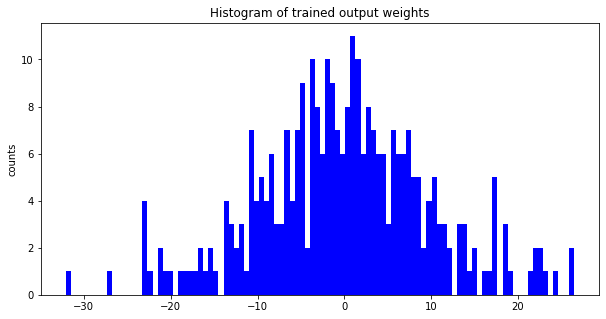


output feature  1 , trained b_out:  [-5.28051108]


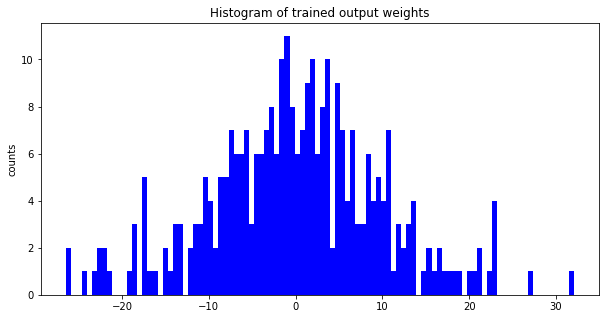


shape of val input (samples, timesteps, features):  (208, 180, 89)
shape of train input (samples, timesteps, features):  (831, 180, 89)

shape of model predictions on validation input (samples, 1):  (208, 2)
shape of val targets (samples, 1):  (208, 2)

train_mae:  0.0896
val_mae:  0.3169

train_mse:  0.0127
val_mse:  0.1649


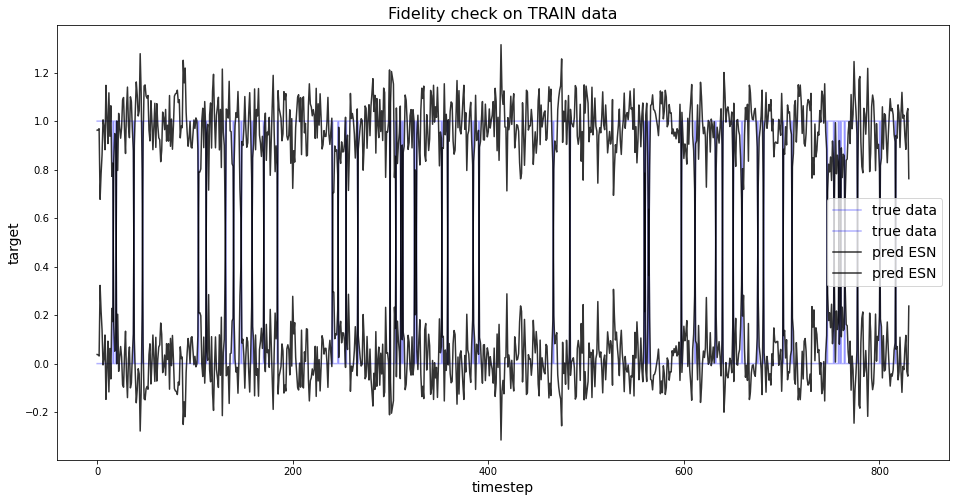

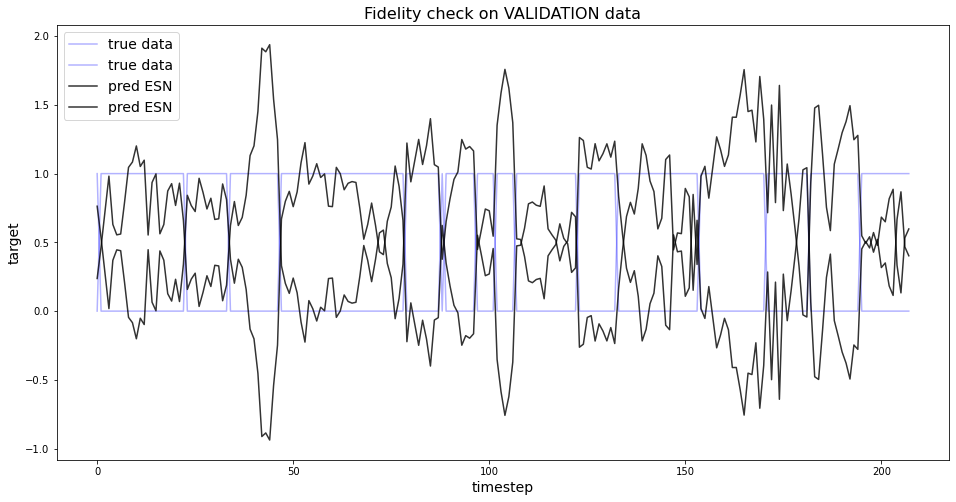

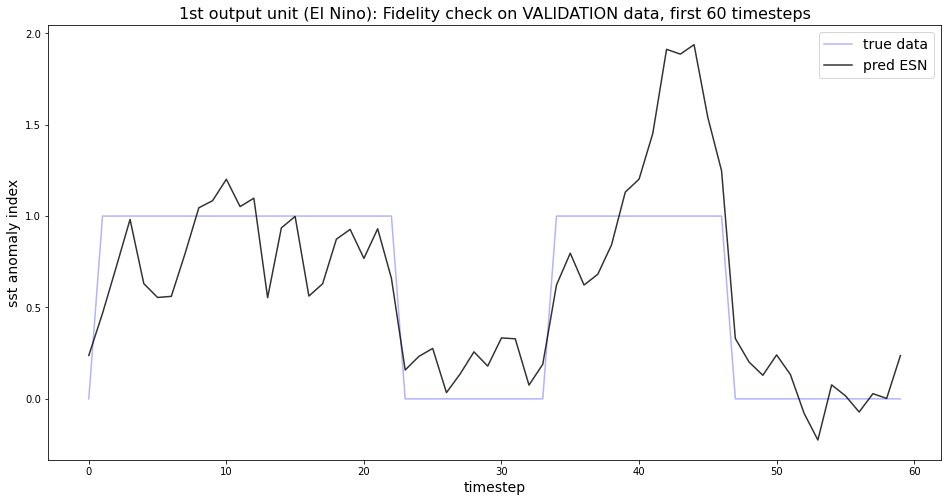

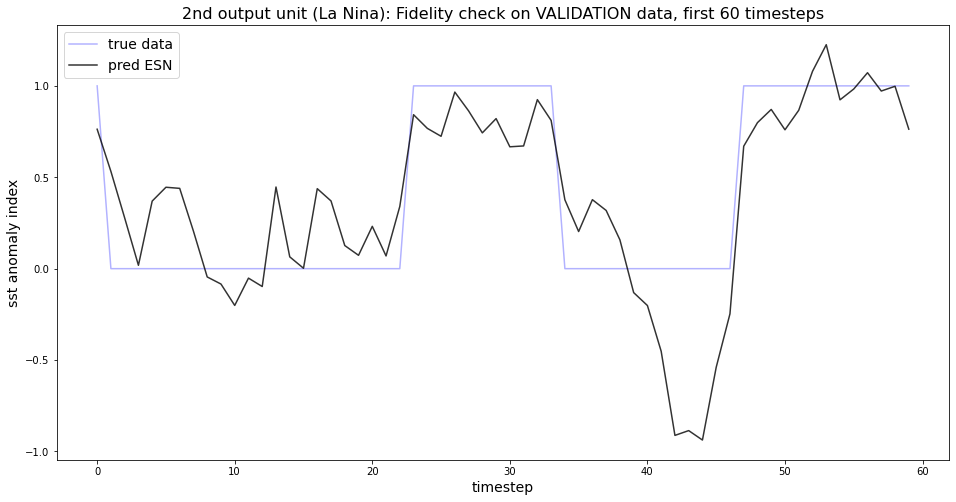

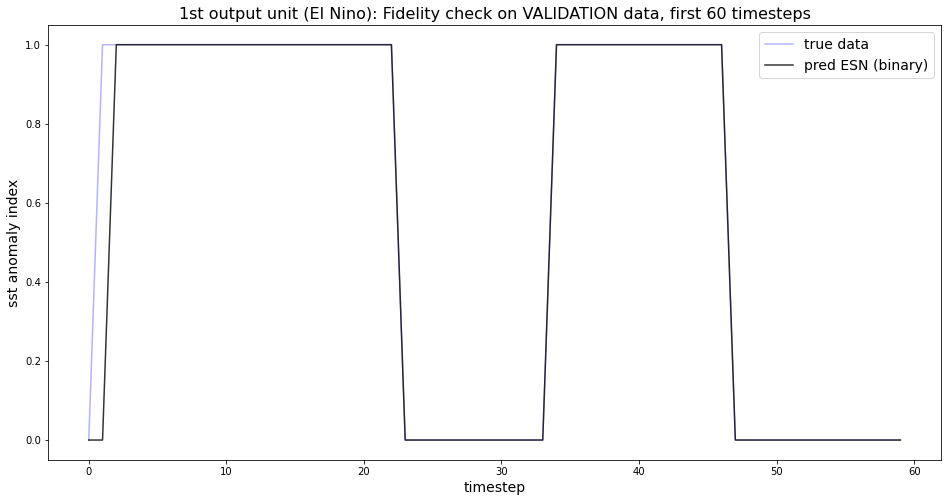

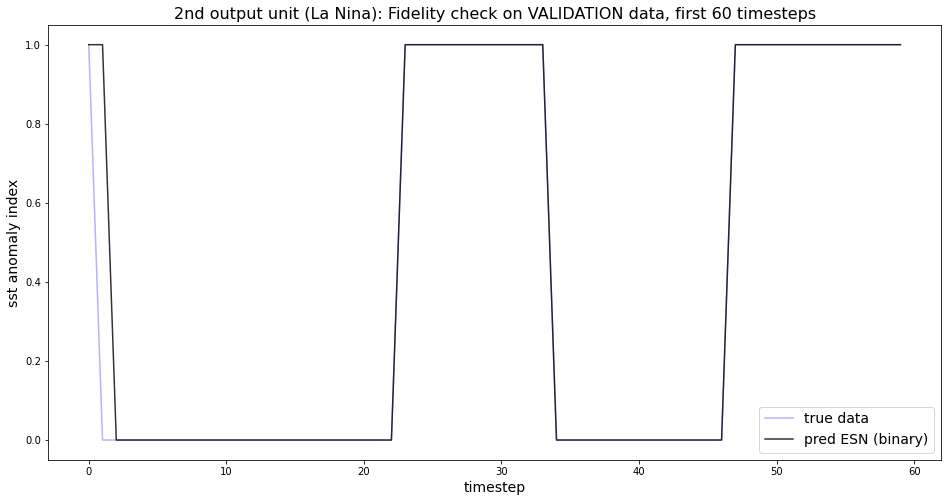


Validation accuracy:
El Nino:  0.99
La Nina:  0.76

Train accuracy:
El Nino:  1.0
La Nina:  1.0


In [287]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
# and all_states (= another shortened model that gives reservoir states for ALL timesteps for all inputs).
model, model_short, all_states = setESN(input_length=input_length, in_features=in_features,
                                        out_features=out_features, n_layers=n_layers,
                                        n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                                        leak_rate_first_step_YN=leak_rate_first_step_YN,
                                        activation=activation, spec_radius=spec_radius,
                                        sparsity=sparsity, verbose=verbose)

# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input_swap, train_target_onehot, verbose=verbose)

# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input_swap, val_input_swap,
                                                                       train_target_onehot, val_target_onehot,
                                                                       verbose=verbose)

if verbose:   
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 60 timesteps for 1st output unit (El Nino)
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,0])),val_target_onehot[:60,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:60,0])),val_pred[:60,0],'k',  alpha=0.8, label='pred ESN')
    plt.title('1st output unit (El Nino): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 60 timesteps for 2nd output unit (La Nina)
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,1])),val_target_onehot[:60,1],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:60,1])),val_pred[:60,1],'k',  alpha=0.8, label='pred ESN')
    plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
# Convert to binary prediction:
train_pred_bin = (train_pred > 0.5).astype(int)
val_pred_bin = (val_pred > 0.5).astype(int)

if verbose:
    # Fidelity check for binary prediction and target for 1st output unit (El Nino).
    # Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,0])),val_target_onehot[:60,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:60,0])),val_pred_bin[:60,0],'k',  alpha=0.8, label='pred ESN (binary)')
    plt.title('1st output unit (El Nino): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check for binary prediction and target for 2nd output unit (La Nina).
    # Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,1])),val_target_onehot[:60,1],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:60,1])),val_pred_bin[:60,1],'k',  alpha=0.8, label='pred ESN (binary)')
    plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
## Check accuracy: How often is the correct label predicted?
## Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
## to have that same event.

# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum((val_pred_bin[:,0] == val_target_onehot[:,0]) & (val_target_onehot[:,0] == 1)) / sum(val_target_onehot[:,0] == 1)
val_acc_LaNina = sum((val_pred_bin[:,1] == val_target_onehot[:,1]) & (val_target_onehot[:,1] == 1)) / sum(val_target_onehot[:,1] == 1)


# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum((train_pred_bin[:,0] == train_target_onehot[:,0]) & (train_target_onehot[:,0] == 1)) / sum(train_target_onehot[:,0] == 1)
train_acc_LaNina = sum((train_pred_bin[:,1] == train_target_onehot[:,1]) & (train_target_onehot[:,1] == 1)) / sum(train_target_onehot[:,1] == 1)

if verbose:
    print("\nValidation accuracy:")
    print("El Nino: ", np.round(val_acc_ElNino,2))
    print("La Nina: ", np.round(val_acc_LaNina,2))

    print("\nTrain accuracy:")
    print("El Nino: ", np.round(train_acc_ElNino,2))
    print("La Nina: ", np.round(train_acc_LaNina,2))

Sample dimensions and prediction:
raw sample shape (1, timesteps, features):  (1, 180, 89)
number of timesteps:  180
number of input features in_feat:  89
number of res. units n_res:  300
leak rate alpha:  0.005
model prediction on sample, 1st output unit (El Nino):  1.202
model prediction on sample, 2nd output unit (La Nina):  -0.202

Model weights and biases, Dimensions:
input weights W_in (input features, res. units):  (89, 300)
input biases b_in (res. units):  (300,)
reservoir weights W_res (res. units, res. units):  (300, 300)
reservoir biases b_res (res. units):  (300,)
output weights W_out (res. units, output features):  (300, 2)
output biases b_out (output features):  (2,)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_878/2384652750.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



Tensor shapes:
input tensor U (timesteps, input features):  (180, 89)
all res. states X (timesteps, res. units):  (180, 300)
activations ACT (timesteps, res. units):  (180, 300)


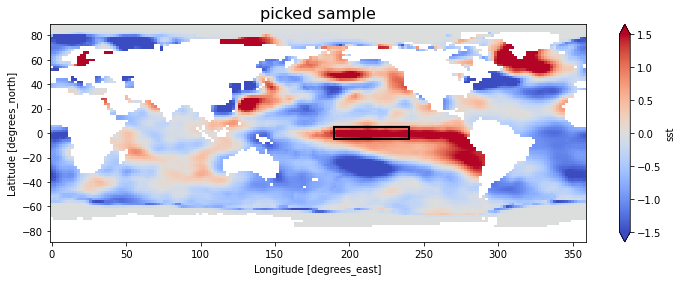

In [288]:
### Pick out ONE El Nino sample to be analysed:
sample_id = 40 # number 40 of validation inputs --> El Nino sample
#sample_id = 52 # number 52 of validation inputs --> La Nina sample
sample = val_input_swap[sample_id:sample_id+1,:,:]

## If feeding the sample column-wise is desired, need to swap lat <-> lon for input sample:
#sample = np.swapaxes(sample, 1, 2)

# Plot sample input
fig, ax = plt.subplots(figsize=(12, 4))
sst_anomaly_fields_NinoNina[sample_id].name = 'sst anomaly deg Celsius'
sst_anomaly_fields_NinoNina[sample_id].plot(ax=ax, cmap='coolwarm', vmax=1.5, vmin=-1.5)
plt.title('picked sample', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = sample.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = sample.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

# Have trained model as pre-requisite. For BOTH output units (El Nino / La Nina) check prediction on picked sample:
pred = model.predict(sample)

## Check dimensions and prediction:
print("Sample dimensions and prediction:")
print("=================================")
print("raw sample shape (1, timesteps, features): ", sample.shape)
print("number of timesteps: ", timesteps)
print("number of input features in_feat: ", in_feat)
print("number of res. units n_res: ", n_res)
print("leak rate alpha: ", a)
print("model prediction on sample, 1st output unit (El Nino): ", np.round(pred[0,0],3))
print("model prediction on sample, 2nd output unit (La Nina): ", np.round(pred[0,1],3))

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Check dimensions:
print("\nModel weights and biases, Dimensions:")
print("=====================================")
print("input weights W_in (input features, res. units): ", W_in.shape)
print("input biases b_in (res. units): ", b_in.shape)
print("reservoir weights W_res (res. units, res. units): ", W_res.shape)
print("reservoir biases b_res (res. units): ", b_res.shape)
print("output weights W_out (res. units, output features): ", W_out.shape)
print("output biases b_out (output features): ", b_out.shape)

## Set tensors for inputs U, activation layer ACT and all reservoir states X:

# Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
U = sample[0,:,:]

# Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
X = all_states.predict(sample)[0,:,:]

# Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

# Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
ACT = (X - (1 - a) * X_prime) / a

# Check dimensions:
print("\nTensor shapes:")
print("==============")
print("input tensor U (timesteps, input features): ", U.shape)
print("all res. states X (timesteps, res. units): ", X.shape)
print("activations ACT (timesteps, res. units): ", ACT.shape)

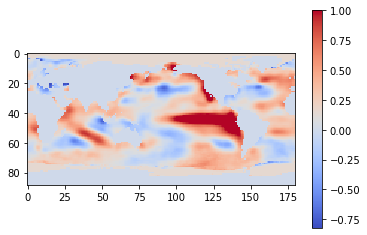

In [289]:
# Plot sample in reduced size:
plt.imshow(np.swapaxes(sample[0,:,:], 0,1), cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

In [290]:
### LRP on baseESN: Only take positive contributions of pre-potential into account.
### First output unit: EL NINO

## NOTE: Use first output units prediction!

## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to first OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
       sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
         / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])

# Get relevances R_k for in_feat input units x_k of U(T)
R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
             / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
/ (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
R_j = R_j_1 + R_j_2

## Store relevance for input layer U for current timestep.
R_all = np.reshape(R_k,(1,len(R_k)))

# Store other relevances for plausibility check:
R_i_sum = []
R_j_sum = []
R_k_sum = []
R_j_1_sum = []
R_j_2_sum = []
R_i_sum.append(sum(R_i))
R_j_sum.append(sum(R_j))
R_k_sum.append(sum(R_k))
R_j_1_sum.append(sum(R_j_1))
R_j_2_sum.append(sum(R_j_2))

### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
### special treatment.


for t in np.flip(np.arange(1,T)):
    
    # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(t), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j
    
    # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
    # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
    R_j_1 = (1 - a) * R_j
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)
    
    # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
    
    # Store other relevances for plausibility check:
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))
    
## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_1pos = np.swapaxes(R_all, 0, 1)

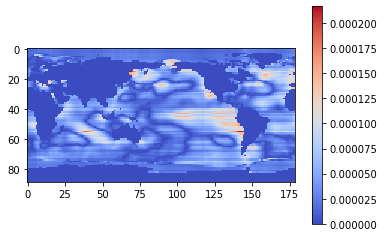

In [13]:
## Scaled to [-1,1] with tanh activation, alpha=0.005, 2nd run
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

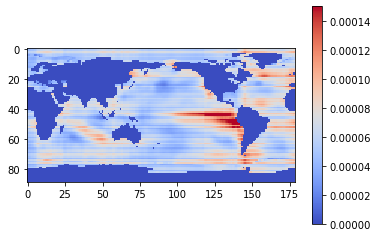

In [60]:
## Scaled to [-1,1] with tanh activation, un-capped inputs
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=0.00015)
plt.colorbar()
plt.show()

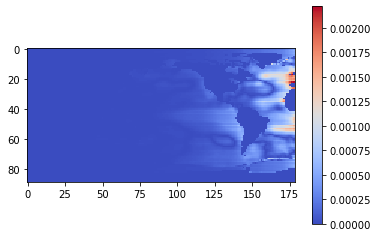

In [21]:
## Scaled to [-1,1] with tanh activation, alpha=0.1
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

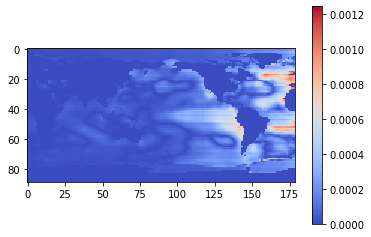

In [15]:
## Scaled to [-1,1] with tanh activation, alpha=0.05
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

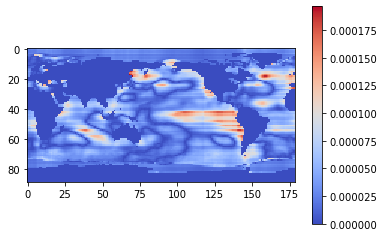

In [97]:
## Scaled to [-1,1] with tanh activation, alpha=0.005
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

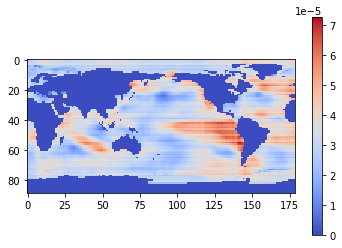

In [100]:
## Scaled to [0,1] with sigmoid activation
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

In [63]:
### LRP on baseESN: Only take positive contributions of pre-potential into account.
### Second output unit: LA NINA

## NOTE: Use second output units prediction!
## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to first OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1]) /
       sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred[0,1])
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])
         / sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred[0,1])

# Get relevances R_k for in_feat input units x_k of U(T)
R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
             / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
/ (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
R_j = R_j_1 + R_j_2

## Store relevance for input layer U for current timestep.
R_all = np.reshape(R_k,(1,len(R_k)))

# Store other relevances for plausibility check:
R_i_sum = []
R_j_sum = []
R_k_sum = []
R_j_1_sum = []
R_j_2_sum = []
R_i_sum.append(sum(R_i))
R_j_sum.append(sum(R_j))
R_k_sum.append(sum(R_k))
R_j_1_sum.append(sum(R_j_1))
R_j_2_sum.append(sum(R_j_2))

### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
### special treatment.


for t in np.flip(np.arange(1,T)):
    
    # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(t), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j
    
    # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
    # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
    R_j_1 = (1 - a) * R_j
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)
    
    # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
    
    # Store other relevances for plausibility check:
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))
    
## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_2pos = np.swapaxes(R_all, 0, 1)

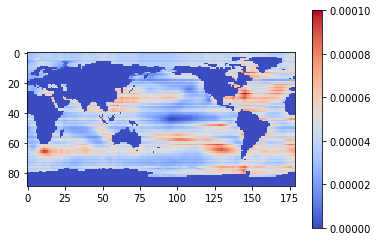

In [65]:
## Scaled to [-1,1] with tanh activation, un-capped inputs
plt.imshow(R_all_2pos, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=0.0001)
plt.colorbar()
plt.show()

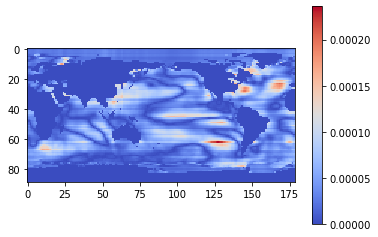

In [101]:
## Scaled to [-1,1] with tanh activation
plt.imshow(R_all_2pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

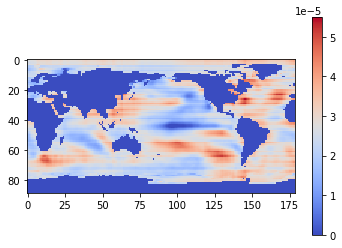

In [104]:
## Scaled to [0,1] with sigmoid activation
plt.imshow(R_all_2pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

### baseESN (column-wise): Get mean relevance maps for ALL El Nino / La Nina samples (from train inputs)

In [14]:
## Reminder: Check scaling of swapped inputs:
np.min(train_input_swap)

-1.0

In [292]:
### LRP with baseESN on ALL El Nino / La Nina samples (from train inputs)

verbose=False

## Split train inputs into El Nino / La Nina samples, according to binary target:
samples_ElNino = train_input_swap[(train_target_bin==1)[:,0]]
samples_LaNina = train_input_swap[(train_target_bin==0)[:,0]]

## Split targets accordingly:
targets_ElNino = train_target[(train_target_bin==1)[:,0]]

if verbose:
    print("samples_ElNino shape: ", samples_ElNino.shape)
    print("samples_LaNina shape: ", samples_LaNina.shape)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = samples_ElNino.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = samples_ElNino.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Initialize storage for mean relevance over all ElNino samples.
## Note: First timestep is still missing in algorithm.
R_all_mean = np.zeros((T, in_feat))
    
#Loop over El Nino samples:
for sample_id in range(len(samples_ElNino)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_ElNino))
    
    # Get current sample:
    sample = samples_ElNino[sample_id:sample_id+1]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)[0,0]
    
    ## Set tensors for inputs U, activation layer ACT and all reservoir states X:

    # Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:,:]

    # Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
    X = all_states.predict(sample)[0,:,:]

    # Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
    X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

    # Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
    ACT = (X - (1 - a) * X_prime) / a
    
    ### LRP on baseESN: Second attempt, only consider positive contributions of pre-potential into account.

    ## Start with layer T

    # Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
    # connecting to single OUTPUT unit x_o:
    R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
           sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)
    R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
             / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)

    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.reshape(R_k,(1,len(R_k)))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.


    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        ## Store relevance for input layer U for current timestep.
        R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
        
    ## Add relevance for current sample to storage for ALL samples:
    R_all_mean += R_all

## Get mean relevance over ALL samples:
R_all_mean = R_all_mean / len(samples_ElNino)

## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_mean_nino = np.swapaxes(R_all_mean, 0, 1)

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_878/601689665.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


sample:  1  from  195
sample:  2  from  195
sample:  3  from  195
sample:  4  from  195
sample:  5  from  195
sample:  6  from  195
sample:  7  from  195
sample:  8  from  195
sample:  9  from  195
sample:  10  from  195
sample:  11  from  195
sample:  12  from  195
sample:  13  from  195
sample:  14  from  195
sample:  15  from  195
sample:  16  from  195
sample:  17  from  195
sample:  18  from  195
sample:  19  from  195
sample:  20  from  195
sample:  21  from  195
sample:  22  from  195
sample:  23  from  195
sample:  24  from  195
sample:  25  from  195
sample:  26  from  195
sample:  27  from  195
sample:  28  from  195
sample:  29  from  195
sample:  30  from  195
sample:  31  from  195
sample:  32  from  195
sample:  33  from  195
sample:  34  from  195
sample:  35  from  195
sample:  36  from  195
sample:  37  from  195
sample:  38  from  195
sample:  39  from  195
sample:  40  from  195
sample:  41  from  195
sample:  42  from  195
sample:  43  from  195
sample:  44  from  1

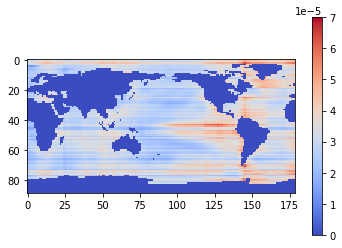

In [71]:
## Scaled to [-1,1] with tanh activation, un-capped inputs
plt.imshow(R_all_mean_nino, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=0.00007)
plt.colorbar()
plt.show()

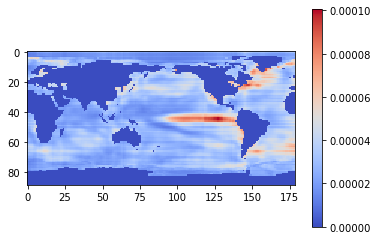

In [293]:
## Scaled to [-1,1] with tanh activation, 3rd run
plt.imshow(R_all_mean_nino, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.000045)
plt.colorbar()
plt.show()

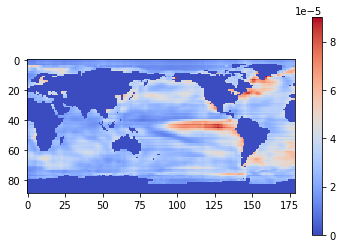

In [16]:
## Scaled to [-1,1] with tanh activation, 2nd run
plt.imshow(R_all_mean_nino, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.000045)
plt.colorbar()
plt.show()

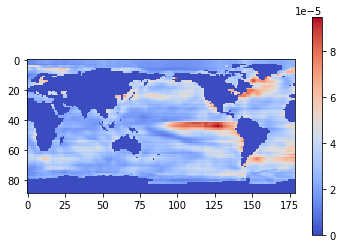

In [105]:
## Scaled to [-1,1] with tanh activation
plt.imshow(R_all_mean_nino, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.000045)
plt.colorbar()
plt.show()

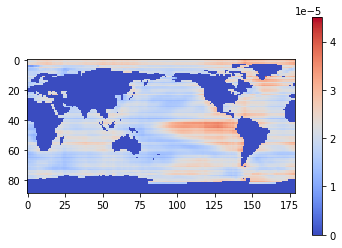

In [106]:
## Scaled to [0,1] with sigmoid activation
plt.imshow(R_all_mean_nino, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=0.000045)
plt.colorbar()
plt.show()

In [17]:
## Initialize storage for mean relevance over all LaNina samples.
## Note: First timestep is still missing in algorithm.
R_all_mean = np.zeros((T, in_feat))
    
#Loop over El Nino samples:
for sample_id in range(len(samples_LaNina)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_LaNina))
    
    # Get current sample:
    sample = samples_LaNina[sample_id:sample_id+1]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)[0,1]
    print(pred)
    
    ## Set tensors for inputs U, activation layer ACT and all reservoir states X:

    # Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:,:]

    # Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
    X = all_states.predict(sample)[0,:,:]

    # Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
    X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

    # Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
    ACT = (X - (1 - a) * X_prime) / a
    
    ### LRP on baseESN: Second attempt, only consider positive contributions of pre-potential into account.

    ## Start with layer T

    # Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
    # connecting to single OUTPUT unit x_o:
    R_i = (a * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1]) /
           sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred)
    R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])
             / sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred)

    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.reshape(R_k,(1,len(R_k)))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.


    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        ## Store relevance for input layer U for current timestep.
        R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
        
    ## Add relevance for current sample to storage for ALL samples:
    R_all_mean += R_all

## Get mean relevance over ALL samples:
R_all_mean = R_all_mean / len(samples_LaNina)

## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_mean_nina = np.swapaxes(R_all_mean, 0, 1)

sample:  1  from  636
0.8664398
sample:  2  from  636
0.8959842
sample:  3  from  636
0.879364
sample:  4  from  636
0.9445262
sample:  5  from  636
0.76662683
sample:  6  from  636
0.83040047
sample:  7  from  636
0.9258652
sample:  8  from  636
0.9965229
sample:  9  from  636
1.0342951
sample:  10  from  636
1.1054854
sample:  11  from  636
0.97912455
sample:  12  from  636
0.96401787
sample:  13  from  636
1.0457325
sample:  14  from  636
0.8685217
sample:  15  from  636
0.8561945
sample:  16  from  636
0.7172785
sample:  17  from  636
0.8619814
sample:  18  from  636
0.89228153
sample:  19  from  636
0.82598495
sample:  20  from  636
0.9374008
sample:  21  from  636
1.0216761
sample:  22  from  636
1.0698042
sample:  23  from  636
1.0122828
sample:  24  from  636
1.1500235
sample:  25  from  636
1.102458
sample:  26  from  636
1.0431843
sample:  27  from  636
0.9196429
sample:  28  from  636
1.0403609
sample:  29  from  636
1.0307326
sample:  30  from  636
1.038456
sample:  31  fro

0.95447063
sample:  246  from  636
0.85225964
sample:  247  from  636
0.86649656
sample:  248  from  636
0.92538166
sample:  249  from  636
0.8096485
sample:  250  from  636
0.83402205
sample:  251  from  636
1.0083399
sample:  252  from  636
1.041089
sample:  253  from  636
1.0617919
sample:  254  from  636
0.97373295
sample:  255  from  636
0.8220625
sample:  256  from  636
0.9438276
sample:  257  from  636
1.2519655
sample:  258  from  636
0.81824017
sample:  259  from  636
0.97269535
sample:  260  from  636
0.94906044
sample:  261  from  636
1.0365114
sample:  262  from  636
0.9977441
sample:  263  from  636
1.0880375
sample:  264  from  636
1.0390434
sample:  265  from  636
0.8905268
sample:  266  from  636
1.0860691
sample:  267  from  636
0.933692
sample:  268  from  636
1.0879283
sample:  269  from  636
1.0007849
sample:  270  from  636
1.0107121
sample:  271  from  636
0.9934006
sample:  272  from  636
0.8029709
sample:  273  from  636
0.95296717
sample:  274  from  636
1.0016

sample:  487  from  636
0.87837553
sample:  488  from  636
0.9809184
sample:  489  from  636
0.9469876
sample:  490  from  636
0.7691798
sample:  491  from  636
0.9717865
sample:  492  from  636
1.0512991
sample:  493  from  636
1.0158162
sample:  494  from  636
1.0994868
sample:  495  from  636
0.9206066
sample:  496  from  636
0.81846666
sample:  497  from  636
0.74286556
sample:  498  from  636
0.74305105
sample:  499  from  636
0.99552727
sample:  500  from  636
1.1932163
sample:  501  from  636
1.0205903
sample:  502  from  636
1.0080609
sample:  503  from  636
0.91772795
sample:  504  from  636
0.8236847
sample:  505  from  636
0.884809
sample:  506  from  636
0.964128
sample:  507  from  636
0.8788223
sample:  508  from  636
0.94278145
sample:  509  from  636
1.142477
sample:  510  from  636
1.1394277
sample:  511  from  636
1.024446
sample:  512  from  636
1.0308967
sample:  513  from  636
1.0301805
sample:  514  from  636
0.9751253
sample:  515  from  636
0.89396
sample:  516 

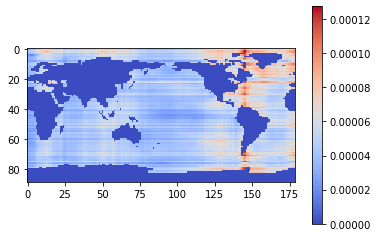

In [152]:
## Scaled to [-1,1] with tanh activation, un-capped inputs
plt.imshow(R_all_mean_nina, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.000018)
plt.colorbar()
plt.show()

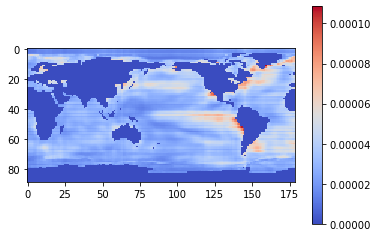

In [18]:
## Scaled to [-1,1] with tanh activation, 2nd run
plt.imshow(R_all_mean_nina, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.000018)
plt.colorbar()
plt.show()

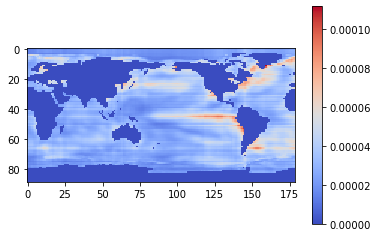

In [107]:
## Scaled to [-1,1] with tanh activation
plt.imshow(R_all_mean_nina, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.000018)
plt.colorbar()
plt.show()

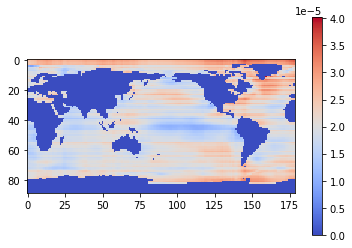

In [108]:
## Scaled to [0,1] with sigmoid activation
plt.imshow(R_all_mean_nina, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.000018)
plt.colorbar()
plt.show()

### Classification with baseESN (row-wise) on onehot targets


#### Base parameter setup

* n_res = 300
* W_in_lim = 0.1
* leak_rate = 0.01
* spec_radius = 0.8
* sparsity = 0.3

Use these parameters on normalmized sst anomaly fields, **scaled to [-1,1]** as inputs and **one-hot targets**, together with **tanh** activation. Multiplication with $\alpha$ is omitted in calculating first timestes's reservoir states (*leak_rate_first_step_YN = False*).

In [99]:
### Try classification of sst anomaly fields with base ESN. Define parameters for ESN model upfront
verbose = True
input_length = train_input.shape[1] # Number of input timesteps, directly taken from inputs' shape.
n_layers = 1 # Number of ESN layers in the model.
n_res = 300 # Number of reservoir units.
W_in_lim = 0.1 # Initialize input weights from random uniform distribution in [- W_in_lim, + W_in_lim]
leak_rate = 0.01 # Leak rate used in transition function of reservoir states.
leak_rate_first_step_YN = False # If true, multiply with alpha already in calculating first timestes's res. states.
activation = 'tanh' # Desired activation function to be used in calculating reservoir state transition.
spec_radius = 0.8 # Spectral radius, becomes largest Eigenvalue of reservoir weight matrix.
sparsity = 0.3 # Sparsity of reservoir weight matrix.
in_features = train_input.shape[2] # Number of input features, directly taken from inputs' shape.
out_features = 2 # E.g. 2 for classifying sst anomaly fields according to El Nino / La Nina events.

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:712: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())
/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:751: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 89, 180)]         0         
_________________________________________________________________
esn_10 (ESN)                 ((None, 89, 300), (None,  144600    
_________________________________________________________________
output (Dense)               (None, 2)                 602       
Total params: 145,202
Trainable params: 145,202
Non-trainable params: 0
_________________________________________________________________
Model: "model_short"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 89, 180)]         0         
_________________________________________________________________
esn_10 (ESN)                 ((None, 89, 300), (None,  144600    
Total params: 144,600
Trainable pa

/Users/mlandt-hayen/MarDATA/Python/EchoStateNetworks/notebooks/ESN_functions_v05.py:791: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())



shape of train input (samples, timesteps, input features):  (831, 89, 180)
shape of model output X_T (samples, n_res):  (831, 300)

Final reservoir states in augmented notation, shape:  (831, 301)

train_target shape (samples, output features):  (831, 2)

W_out shape:  (300, 2)
b_out shape:  (2,)

output feature  0 , trained b_out:  [-1121.78989874]


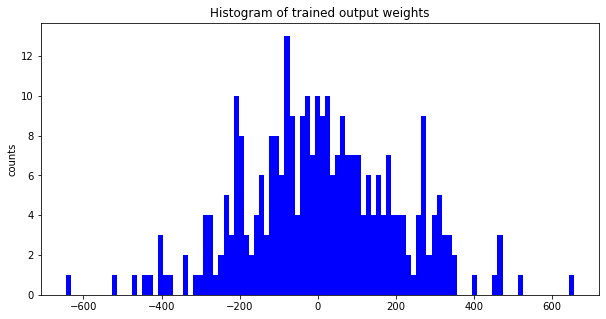


output feature  1 , trained b_out:  [1122.78989874]


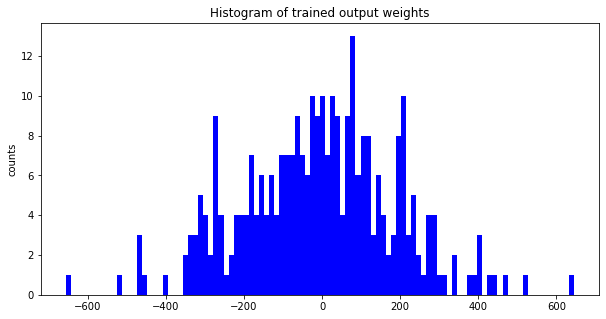


shape of val input (samples, timesteps, features):  (208, 89, 180)
shape of train input (samples, timesteps, features):  (831, 89, 180)

shape of model predictions on validation input (samples, 1):  (208, 2)
shape of val targets (samples, 1):  (208, 2)

train_mae:  0.0839
val_mae:  0.2275

train_mse:  0.0116
val_mse:  0.08


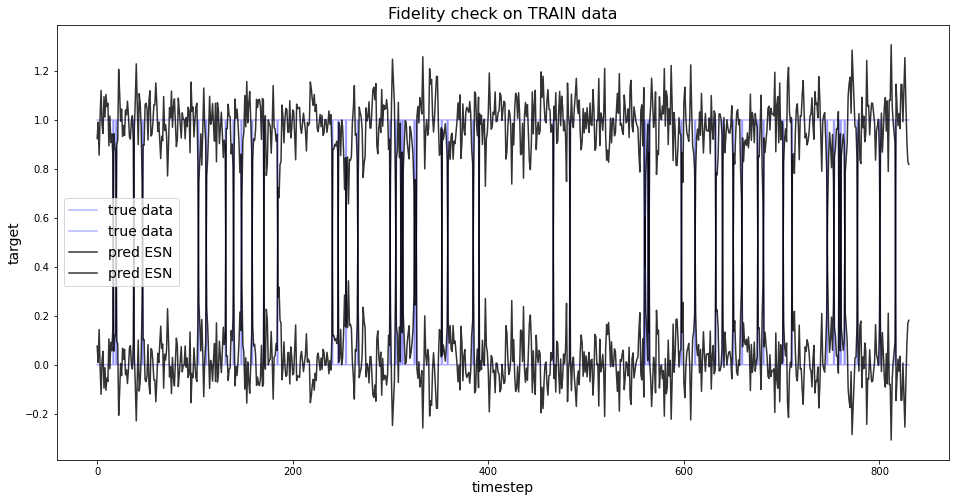

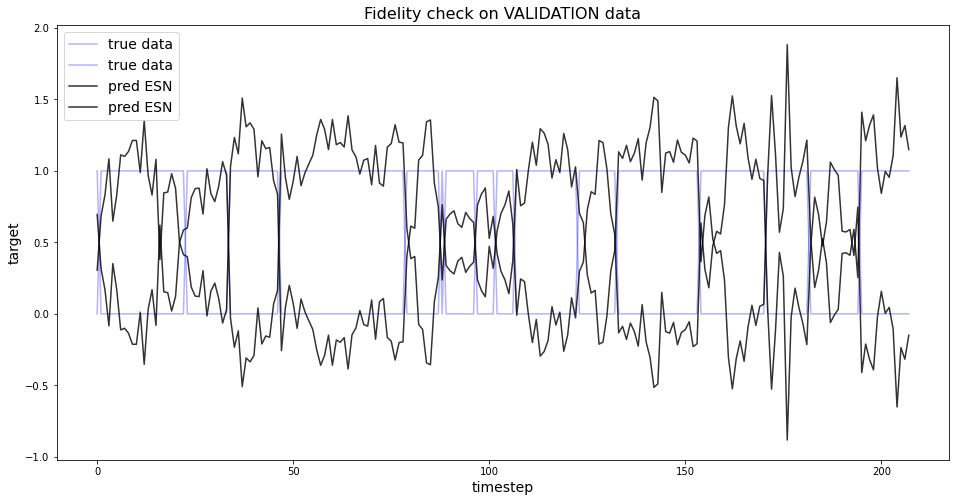

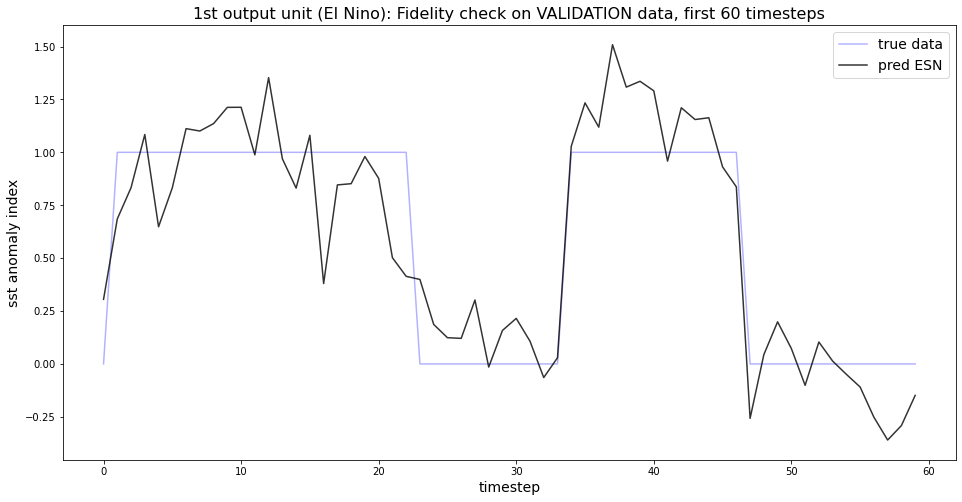

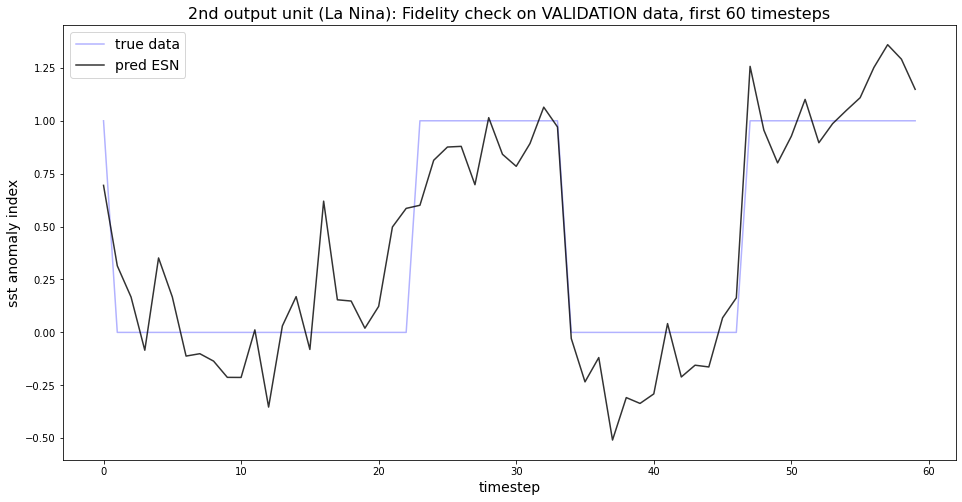

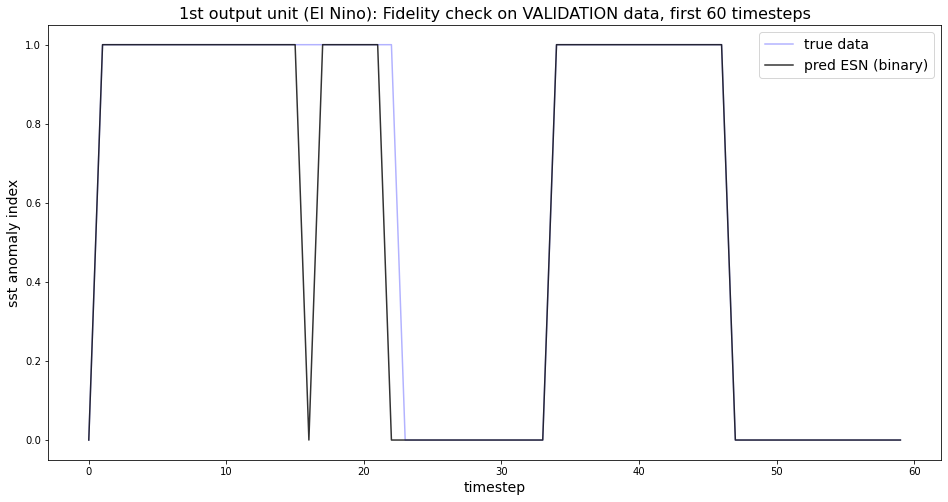

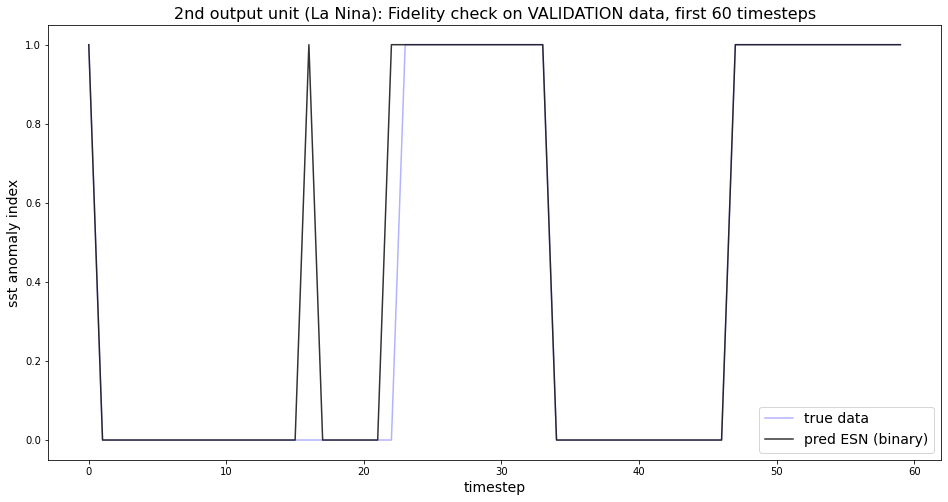


Validation accuracy:
El Nino:  0.89
La Nina:  1.0

Train accuracy:
El Nino:  1.0
La Nina:  1.0


In [100]:
# Get complete model (output = target prediction) plus short model (output final reservoir states from all layers)
# and all_states (= another shortened model that gives reservoir states for ALL timesteps for all inputs).
model, model_short, all_states = setESN(input_length=input_length, in_features=in_features,
                                        out_features=out_features, n_layers=n_layers,
                                        n_res=n_res, W_in_lim=W_in_lim, leak_rate=leak_rate,
                                        leak_rate_first_step_YN=leak_rate_first_step_YN,
                                        activation=activation, spec_radius=spec_radius,
                                        sparsity=sparsity, verbose=verbose)

# Train ESN model's output weights and bias
model = trainESN(model, model_short, train_input, train_target_onehot, verbose=verbose)

# Get predictions from trained ESN model and evaluation metrics on model performance:
train_pred, val_pred, train_mae, val_mae, train_mse, val_mse = predESN(model, train_input, val_input,
                                                                       train_target_onehot, val_target_onehot,
                                                                       verbose=verbose)

if verbose:   
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 60 timesteps for 1st output unit (El Nino)
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,0])),val_target_onehot[:60,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:60,0])),val_pred[:60,0],'k',  alpha=0.8, label='pred ESN')
    plt.title('1st output unit (El Nino): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check: Plot val_pred vs. val_targets, but only the first 60 timesteps for 2nd output unit (La Nina)
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,1])),val_target_onehot[:60,1],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred[:60,1])),val_pred[:60,1],'k',  alpha=0.8, label='pred ESN')
    plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
# Convert to binary prediction:
train_pred_bin = (train_pred > 0.5).astype(int)
val_pred_bin = (val_pred > 0.5).astype(int)

if verbose:
    # Fidelity check for binary prediction and target for 1st output unit (El Nino).
    # Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,0])),val_target_onehot[:60,0],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:60,0])),val_pred_bin[:60,0],'k',  alpha=0.8, label='pred ESN (binary)')
    plt.title('1st output unit (El Nino): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
    # Fidelity check for binary prediction and target for 2nd output unit (La Nina).
    # Plot val_pred_bin vs. val_targets, but only the first 60 timesteps
    plt.figure(figsize=(16,8))
    plt.plot(range(len(val_target_onehot[:60,1])),val_target_onehot[:60,1],'b',label="true data", alpha=0.3)
    plt.plot(range(len(val_pred_bin[:60,1])),val_pred_bin[:60,1],'k',  alpha=0.8, label='pred ESN (binary)')
    plt.title('2nd output unit (La Nina): Fidelity check on VALIDATION data, first 60 timesteps', fontsize=16)
    plt.xlabel('timestep', fontsize=14)
    plt.ylabel('sst anomaly index', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
## Check accuracy: How often is the correct label predicted?
## Note: Accurate prediction means having a certain event (e.g. El Nino) and correctly predicting 
## to have that same event.

# Get validation accuracy: Rel. amount of correctly predicted events.
val_acc_ElNino = sum((val_pred_bin[:,0] == val_target_onehot[:,0]) & (val_target_onehot[:,0] == 1)) / sum(val_target_onehot[:,0] == 1)
val_acc_LaNina = sum((val_pred_bin[:,1] == val_target_onehot[:,1]) & (val_target_onehot[:,1] == 1)) / sum(val_target_onehot[:,1] == 1)


# Get train accuracy: Rel. amount of correctly predicted events.
train_acc_ElNino = sum((train_pred_bin[:,0] == train_target_onehot[:,0]) & (train_target_onehot[:,0] == 1)) / sum(train_target_onehot[:,0] == 1)
train_acc_LaNina = sum((train_pred_bin[:,1] == train_target_onehot[:,1]) & (train_target_onehot[:,1] == 1)) / sum(train_target_onehot[:,1] == 1)

if verbose:
    print("\nValidation accuracy:")
    print("El Nino: ", np.round(val_acc_ElNino,2))
    print("La Nina: ", np.round(val_acc_LaNina,2))

    print("\nTrain accuracy:")
    print("El Nino: ", np.round(train_acc_ElNino,2))
    print("La Nina: ", np.round(train_acc_LaNina,2))

Sample dimensions and prediction:
raw sample shape (1, timesteps, features):  (1, 89, 180)
number of timesteps:  89
number of input features in_feat:  180
number of res. units n_res:  300
leak rate alpha:  0.01
model prediction on sample, 1st output unit (El Nino):  8.635
model prediction on sample, 2nd output unit (La Nina):  -7.635

Model weights and biases, Dimensions:
input weights W_in (input features, res. units):  (180, 300)
input biases b_in (res. units):  (300,)
reservoir weights W_res (res. units, res. units):  (300, 300)
reservoir biases b_res (res. units):  (300,)
output weights W_out (res. units, output features):  (300, 2)
output biases b_out (output features):  (2,)

Tensor shapes:
input tensor U (timesteps, input features):  (89, 180)
all res. states X (timesteps, res. units):  (89, 300)
activations ACT (timesteps, res. units):  (89, 300)


/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1108/250178779.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


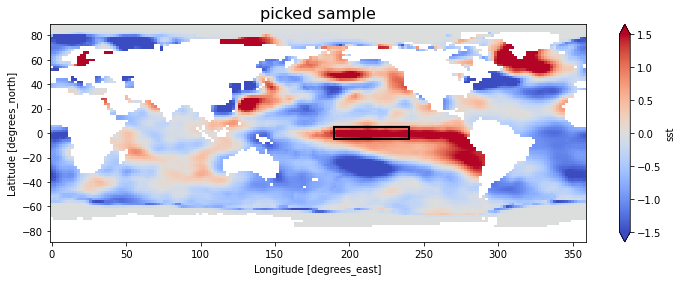

In [116]:
### Pick out ONE El Nino sample to be analysed:
sample_id = 40 # number 40 of validation inputs --> El Nino sample
#sample_id = 52 # number 52 of validation inputs --> La Nina sample
sample = val_input[sample_id:sample_id+1,:,:]

## If feeding the sample column-wise is desired, need to swap lat <-> lon for input sample:
#sample = np.swapaxes(sample, 1, 2)

# Plot sample input
fig, ax = plt.subplots(figsize=(12, 4))
sst_anomaly_fields_NinoNina[sample_id].name = 'sst anomaly deg Celsius'
sst_anomaly_fields_NinoNina[sample_id].plot(ax=ax, cmap='coolwarm', vmax=1.5, vmin=-1.5)
plt.title('picked sample', fontsize=16)

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = sample.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = sample.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

# Have trained model as pre-requisite. For BOTH output units (El Nino / La Nina) check prediction on picked sample:
pred = model.predict(sample)

## Check dimensions and prediction:
print("Sample dimensions and prediction:")
print("=================================")
print("raw sample shape (1, timesteps, features): ", sample.shape)
print("number of timesteps: ", timesteps)
print("number of input features in_feat: ", in_feat)
print("number of res. units n_res: ", n_res)
print("leak rate alpha: ", a)
print("model prediction on sample, 1st output unit (El Nino): ", np.round(pred[0,0],3))
print("model prediction on sample, 2nd output unit (La Nina): ", np.round(pred[0,1],3))

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Check dimensions:
print("\nModel weights and biases, Dimensions:")
print("=====================================")
print("input weights W_in (input features, res. units): ", W_in.shape)
print("input biases b_in (res. units): ", b_in.shape)
print("reservoir weights W_res (res. units, res. units): ", W_res.shape)
print("reservoir biases b_res (res. units): ", b_res.shape)
print("output weights W_out (res. units, output features): ", W_out.shape)
print("output biases b_out (output features): ", b_out.shape)

## Set tensors for inputs U, activation layer ACT and all reservoir states X:

# Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
U = sample[0,:,:]

# Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
X = all_states.predict(sample)[0,:,:]

# Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

# Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
ACT = (X - (1 - a) * X_prime) / a

# Check dimensions:
print("\nTensor shapes:")
print("==============")
print("input tensor U (timesteps, input features): ", U.shape)
print("all res. states X (timesteps, res. units): ", X.shape)
print("activations ACT (timesteps, res. units): ", ACT.shape)

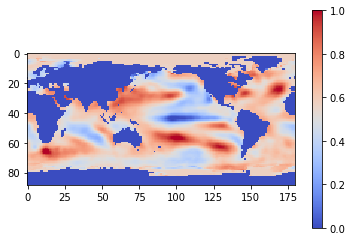

In [107]:
# Plot sample in reduced size:
plt.imshow(sample[0,:,:], cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00005)
plt.colorbar()
plt.show()

In [103]:
### LRP on baseESN: Only take positive contributions of pre-potential into account.
### First output unit: EL NINO

## NOTE: Use first output units prediction!

## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to first OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
       sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
         / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred[0,0])

# Get relevances R_k for in_feat input units x_k of U(T)
R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
             / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
/ (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
R_j = R_j_1 + R_j_2

## Store relevance for input layer U for current timestep.
R_all = np.reshape(R_k,(1,len(R_k)))

# Store other relevances for plausibility check:
R_i_sum = []
R_j_sum = []
R_k_sum = []
R_j_1_sum = []
R_j_2_sum = []
R_i_sum.append(sum(R_i))
R_j_sum.append(sum(R_j))
R_k_sum.append(sum(R_k))
R_j_1_sum.append(sum(R_j_1))
R_j_2_sum.append(sum(R_j_2))

### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
### special treatment.


for t in np.flip(np.arange(1,T)):
    
    # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(t), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j
    
    # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
    # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
    R_j_1 = (1 - a) * R_j
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)
    
    # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
    
    # Store other relevances for plausibility check:
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))
    
## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_1pos = R_all

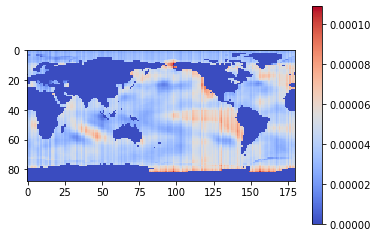

In [105]:
## Scaled to [0,1] with sigmoid activation
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.0002)
plt.colorbar()
plt.show()

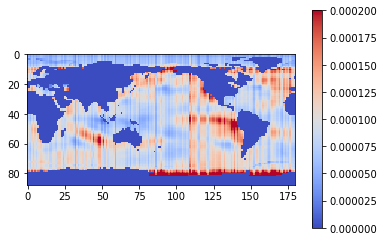

In [96]:
## Scaled to [-1,1] with tanh activation, alpha=0.01, uncapped inputs
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=0.0002)
plt.colorbar()
plt.show()

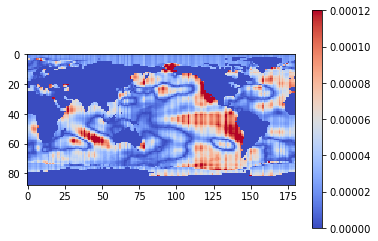

In [36]:
## Scaled to [-1,1] with tanh activation
plt.imshow(R_all_1pos, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=0.00012)
plt.colorbar()
plt.show()

In [108]:
### LRP on baseESN: Only take positive contributions of pre-potential into account.
### Second output unit: LA NINA

## NOTE: Use second output units prediction!
## Start with layer T

# Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
# connecting to first OUTPUT unit x_o:
R_i = (a * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1]) /
       sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred[0,1])
R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])
         / sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred[0,1])

# Get relevances R_k for in_feat input units x_k of U(T)
R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
             / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
/ (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

# Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
R_j = R_j_1 + R_j_2

## Store relevance for input layer U for current timestep.
R_all = np.reshape(R_k,(1,len(R_k)))

# Store other relevances for plausibility check:
R_i_sum = []
R_j_sum = []
R_k_sum = []
R_j_1_sum = []
R_j_2_sum = []
R_i_sum.append(sum(R_i))
R_j_sum.append(sum(R_j))
R_k_sum.append(sum(R_k))
R_j_1_sum.append(sum(R_j_1))
R_j_2_sum.append(sum(R_j_2))

### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
### special treatment.


for t in np.flip(np.arange(1,T)):
    
    # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
    # single corresponding unit x_m of X(t), multiplied by alpha. 
    # No additional weights and bias in this connection, hence w=1 and b=0.
    R_i = a * R_j
    
    # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
    # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
    R_j_1 = (1 - a) * R_j
    
    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)
    
    # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
    
    # Store other relevances for plausibility check:
    R_i_sum.append(sum(R_i))
    R_j_sum.append(sum(R_j))
    R_k_sum.append(sum(R_k))
    R_j_1_sum.append(sum(R_j_1))
    R_j_2_sum.append(sum(R_j_2))
    
## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_2pos = R_all

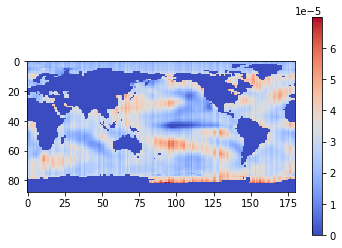

In [110]:
## Scaled to [0,1] with sigmoid activation
plt.imshow(R_all_2pos, cmap='coolwarm', interpolation='nearest')#, vmin=0, vmax=0.00015)
plt.colorbar()
plt.show()

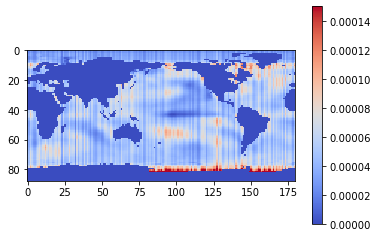

In [89]:
## Scaled to [-1,1] with tanh activation, un-capped inputs
plt.imshow(R_all_2pos, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=0.00015)
plt.colorbar()
plt.show()

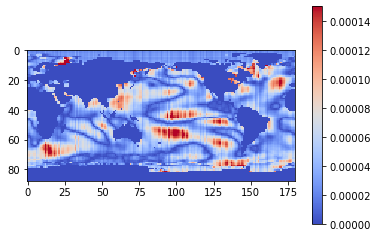

In [42]:
## Scaled to [-1,1] with tanh activation
plt.imshow(R_all_2pos, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=0.00015)
plt.colorbar()
plt.show()

### baseESN (row-wise): Get mean relevance maps for ALL El Nino / La Nina samples (from train inputs)

In [43]:
### LRP with baseESN on ALL El Nino / La Nina samples (from train inputs)

verbose=False

## Split train inputs into El Nino / La Nina samples, according to binary target:
samples_ElNino = train_input[(train_target_bin==1)[:,0]]
samples_LaNina = train_input[(train_target_bin==0)[:,0]]

## Split targets accordingly:
targets_ElNino = train_target[(train_target_bin==1)[:,0]]

if verbose:
    print("samples_ElNino shape: ", samples_ElNino.shape)
    print("samples_LaNina shape: ", samples_LaNina.shape)

# Extract number of timesteps (timesteps) and variable T to loop over.
# Note: Subtract 1 from absolute number of timesteps to get T, since loops start at 0.
timesteps = samples_ElNino.shape[1]
T = timesteps - 1

# Extract number of input features:
in_feat = samples_ElNino.shape[2]

# Rename leak_rate to 'a' for convenience and readability of LRP algorithm:
a = leak_rate

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model.get_weights())

## Set input / reservoir / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_res = model_weights[2]
b_res = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Initialize storage for mean relevance over all ElNino samples.
## Note: First timestep is still missing in algorithm.
R_all_mean = np.zeros((T, in_feat))
    
#Loop over El Nino samples:
for sample_id in range(len(samples_ElNino)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_ElNino))
    
    # Get current sample:
    sample = samples_ElNino[sample_id:sample_id+1]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)[0,0]
    
    ## Set tensors for inputs U, activation layer ACT and all reservoir states X:

    # Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:,:]

    # Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
    X = all_states.predict(sample)[0,:,:]

    # Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
    X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

    # Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
    ACT = (X - (1 - a) * X_prime) / a
    
    ### LRP on baseESN: Second attempt, only consider positive contributions of pre-potential into account.

    ## Start with layer T

    # Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
    # connecting to single OUTPUT unit x_o:
    R_i = (a * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0]) /
           sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)
    R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])
             / sum((np.multiply(ACT[T,:],W_out[:,0])>0) * np.multiply(ACT[T,:],W_out[:,0])) * pred)

    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.reshape(R_k,(1,len(R_k)))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.


    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        ## Store relevance for input layer U for current timestep.
        R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
        
    ## Add relevance for current sample to storage for ALL samples:
    R_all_mean += R_all

## Get mean relevance over ALL samples:
R_all_mean = R_all_mean / len(samples_ElNino)

## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_mean_nino = R_all_mean

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1108/1858459789.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model.get_weights())


sample:  1  from  195
sample:  2  from  195
sample:  3  from  195
sample:  4  from  195
sample:  5  from  195
sample:  6  from  195
sample:  7  from  195
sample:  8  from  195
sample:  9  from  195
sample:  10  from  195
sample:  11  from  195
sample:  12  from  195
sample:  13  from  195
sample:  14  from  195
sample:  15  from  195
sample:  16  from  195
sample:  17  from  195
sample:  18  from  195
sample:  19  from  195
sample:  20  from  195
sample:  21  from  195
sample:  22  from  195
sample:  23  from  195
sample:  24  from  195
sample:  25  from  195
sample:  26  from  195
sample:  27  from  195
sample:  28  from  195
sample:  29  from  195
sample:  30  from  195
sample:  31  from  195
sample:  32  from  195
sample:  33  from  195
sample:  34  from  195
sample:  35  from  195
sample:  36  from  195
sample:  37  from  195
sample:  38  from  195
sample:  39  from  195
sample:  40  from  195
sample:  41  from  195
sample:  42  from  195
sample:  43  from  195
sample:  44  from  1

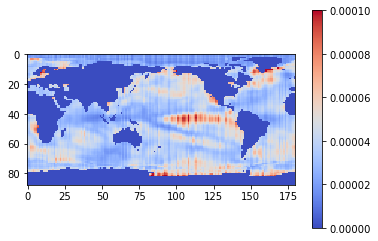

In [46]:
## Scaled to [-1,1] with tanh activation
plt.imshow(R_all_mean_nino, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=0.00010)
plt.colorbar()
plt.show()

In [47]:
## Initialize storage for mean relevance over all LaNina samples.
## Note: First timestep is still missing in algorithm.
R_all_mean = np.zeros((T, in_feat))
    
#Loop over El Nino samples:
for sample_id in range(len(samples_LaNina)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_LaNina))
    
    # Get current sample:
    sample = samples_LaNina[sample_id:sample_id+1]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model.predict(sample)[0,1]
    print(pred)
    
    ## Set tensors for inputs U, activation layer ACT and all reservoir states X:

    # Get inputs U for all timesteps from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:,:]

    # Get all reservoir states for all timesteps X on picked sample, omit first dimension (=sample number):
    X = all_states.predict(sample)[0,:,:]

    # Get X' from all reservoir states X, shifted by one timestep and adding ZEROs as first row:
    X_prime = np.concatenate([np.zeros((1,n_res)),X[:-1,:]], axis=0)

    # Get activation layer ACT from relation: X = (1 - alpha) * X_prime + alpha * ACT
    ACT = (X - (1 - a) * X_prime) / a
    
    ### LRP on baseESN: Second attempt, only consider positive contributions of pre-potential into account.

    ## Start with layer T

    # Get relevances R_i and first part of R_j for n_res units x_i in ACT(T) and x_j in X(T-1), respectively,
    # connecting to single OUTPUT unit x_o:
    R_i = (a * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1]) /
           sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred)
    R_j_1 = ((1 - a) * (np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])
             / sum((np.multiply(ACT[T,:],W_out[:,1])>0) * np.multiply(ACT[T,:],W_out[:,1])) * pred)

    # Get relevances R_k for in_feat input units x_k of U(T)
    R_k = np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)
                 / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
    R_j_2 = np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)
    / (np.sum((np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[T,:],(in_feat,1)),W_in), axis=0)
                    + np.sum((np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[T-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

    # Combine both contributions for relevance R_j, for n_res units x_j of X(T-1):
    R_j = R_j_1 + R_j_2

    ## Store relevance for input layer U for current timestep.
    R_all = np.reshape(R_k,(1,len(R_k)))

    ### Now loop over remaining T-1 layers in decreasing order. Start with T-1, stop at first layer, since that needs
    ### special treatment.


    for t in np.flip(np.arange(1,T)):

        # Get relevances R_i for n_res units x_i of ACT(t). Note: Each unit x_i is only connected to a
        # single corresponding unit x_m of X(t), multiplied by alpha. 
        # No additional weights and bias in this connection, hence w=1 and b=0.
        R_i = a * R_j

        # The same holds true for first part of relevances R_j_1 for n_res units x_j of X(t-1) connecting to
        # n_res units x_m of X(t), multiplied by (1-alpha), no weights and bias.
        R_j_1 = (1 - a) * R_j

        # Get relevances R_k for in_feat input units x_k of U(T)
        R_k = np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)
                     / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Get second contribution R_j_2 for relevance R_j for n_res units x_j of X(T-1) connecting to x_i units of ACT(T).
        R_j_2 = np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)
        / (np.sum((np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in)>0) * np.multiply(np.reshape(U[t,:],(in_feat,1)),W_in), axis=0)
                        + np.sum((np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res)>0) * np.multiply(np.reshape(X[t-1,:],(n_res, 1)),W_res), axis=0)) * R_i, axis=1)

        # Combine both contributions for relevance R_j, for n_res units x_j of X(t-1):
        R_j = R_j_1 + R_j_2

        ## Store relevance for input layer U for current timestep.
        R_all = np.concatenate([np.reshape(R_k,(1,len(R_k))), R_all], axis=0)
        
    ## Add relevance for current sample to storage for ALL samples:
    R_all_mean += R_all

## Get mean relevance over ALL samples:
R_all_mean = R_all_mean / len(samples_LaNina)

## Since we worked with swapped sample (lat <-> lon), reverse swapping:
R_all_mean_nina = R_all_mean

sample:  1  from  636
1.1205049
sample:  2  from  636
0.9893513
sample:  3  from  636
1.1725116
sample:  4  from  636
0.99599457
sample:  5  from  636
1.0660491
sample:  6  from  636
0.9397769
sample:  7  from  636
0.9761176
sample:  8  from  636
0.89452505
sample:  9  from  636
1.1527948
sample:  10  from  636
1.1302285
sample:  11  from  636
0.9518323
sample:  12  from  636
0.93386936
sample:  13  from  636
0.87446547
sample:  14  from  636
1.1299815
sample:  15  from  636
0.9173932
sample:  16  from  636
0.9471402
sample:  17  from  636
0.70798874
sample:  18  from  636
0.84968853
sample:  19  from  636
0.91081333
sample:  20  from  636
1.0090203
sample:  21  from  636
0.9775648
sample:  22  from  636
1.0300946
sample:  23  from  636
1.0696044
sample:  24  from  636
1.0069194
sample:  25  from  636
0.99233055
sample:  26  from  636
0.9153285
sample:  27  from  636
1.0037689
sample:  28  from  636
0.9974427
sample:  29  from  636
1.1406207
sample:  30  from  636
1.0573826
sample:  31

sample:  246  from  636
0.8034096
sample:  247  from  636
0.94812775
sample:  248  from  636
0.90711737
sample:  249  from  636
0.9347615
sample:  250  from  636
0.86146784
sample:  251  from  636
0.95223904
sample:  252  from  636
1.0841966
sample:  253  from  636
1.1299758
sample:  254  from  636
1.1269364
sample:  255  from  636
0.81181
sample:  256  from  636
1.0343118
sample:  257  from  636
1.1322064
sample:  258  from  636
0.9250326
sample:  259  from  636
1.0400472
sample:  260  from  636
1.1459408
sample:  261  from  636
1.1676807
sample:  262  from  636
1.0873427
sample:  263  from  636
1.0435724
sample:  264  from  636
1.0903282
sample:  265  from  636
1.0442452
sample:  266  from  636
1.0033722
sample:  267  from  636
1.1549768
sample:  268  from  636
1.091567
sample:  269  from  636
0.88090086
sample:  270  from  636
0.8728652
sample:  271  from  636
0.82740355
sample:  272  from  636
0.93607855
sample:  273  from  636
0.9256191
sample:  274  from  636
0.9020114
sample:  2

sample:  487  from  636
0.7827072
sample:  488  from  636
1.0691452
sample:  489  from  636
0.8771367
sample:  490  from  636
0.8286629
sample:  491  from  636
1.0344558
sample:  492  from  636
0.80092764
sample:  493  from  636
0.9530406
sample:  494  from  636
0.9502988
sample:  495  from  636
0.9958129
sample:  496  from  636
0.94732237
sample:  497  from  636
0.8459935
sample:  498  from  636
0.89404345
sample:  499  from  636
1.1164641
sample:  500  from  636
1.0491433
sample:  501  from  636
1.1932206
sample:  502  from  636
0.8224549
sample:  503  from  636
0.9589925
sample:  504  from  636
0.96593046
sample:  505  from  636
0.84614754
sample:  506  from  636
1.0444527
sample:  507  from  636
0.88009644
sample:  508  from  636
0.7661433
sample:  509  from  636
1.0507789
sample:  510  from  636
0.9772763
sample:  511  from  636
0.8333802
sample:  512  from  636
0.94774485
sample:  513  from  636
1.0485735
sample:  514  from  636
0.8301678
sample:  515  from  636
1.0061979
sample:

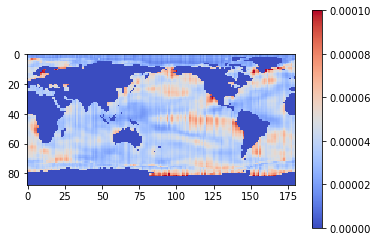

In [50]:
## Scaled to [-1,1] with tanh activation
plt.imshow(R_all_mean_nina, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=0.0001)
plt.colorbar()
plt.show()

### Discussion on Classification and LRP

#### Disclaimer on samples' balance

We find class imbalance: Have a lot more La Nina samples than El Nino samples, at least in train data. This should not be a problem for ESN models if we work with one-hot targets and train output weights for each class in a closed-form manner. And this is obviously another advantage compared to *regular* ANN architectures!

If balance is required, we could think about **de-trending** sst anomaly index, but not done here. Or **shift climatology period**.

#### 1a. Linear regression: Classification

Best performance is found for the following setup:

* Feed **whole world's** sst anomaly fields as input
* Only consider **„valid“ gridpoints** (remove NaN values)
* **flattened** (vectorized)
* **capped** with “hard“ limits [-5°C, 5°C]
* **scaled** to [-1,1]
* **unscaled continuous** normalized sst anomaly index as **target**.

Find accuracy train and validation accuracy to be 100% for both, El Nino and La Nina samples. Fidelity is close to perfect, predictions on train and validation data accurately match continuous target values.

#### 1b. Linear regression: LRP

Plotting trained weights can be viewed as *relevance map* for linear regression. And it reveals that linear regression has a strong focus on Nino 3.4 box. That makes sense, since we defined target (sst anomaly index) from sst anomalies within Nino 3.4 box.

#### 2a. Multilayer perceptron: Classification

In general, MLP can handle **un-capped** sst anomaly fields as input, but with lower prediction accuracy compared to **capped** inputs, as expected.

Best performance is found for the following setup:

* Feed **whole world's** sst anomaly fields as input
* Only consider **„valid“ gridpoints** (remove NaN values)
* **flattened** (vectorized)
* **capped** with “hard“ limits [-5°C, 5°C]
* **scaled** to [-1,1]
* **one-hot** targets (needed for LRP)

For this setup on **capped** inputs with “hard“ limits [-5°C, 5°C] we achieve 100% accuracy for train data on both, El Nino and La Nina samples and validation accuracy of arround 100% / 98% for El Nino and La Nina samples, almost perfect performance, as for linear regression.

#### 2b. Multilayer perceptron: LRP

Opposed to [Toms et al, 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002002) paper "Physically Interpretable Neural Networks for the Geosciences: Applications to Earth System Variability", we decided to use **linear** activation in hidden units, instead of **ReLU**.

This allows to consider **positive pre-potentials** for backpropagating relevance in a more stable manner:
Considering **positive pre-potentials** in connection with **ReLU** activation used in hidden layer activations, we get problems when we try to pass information from second  to first hidden layer in terms of division by zero. Need to introduce some stabilizer $\epsilon=0.01$. With that stabilizer we get some very nice relevance maps, clearly highlighting only Nino region and close to zero elsewhere. The price to pay is, that we don't conserve total relevance when we use a stabilizer, but the effect is negligible. **Note:** In rare cases we also need stabilizer when training model with **linear** activation.

In any case neglect bias terms. 

Have **one-hot** targets. Compute relevance separately for both output units, hence for El Nino / La Nina samples separately. Use the following propagation rule to pass information backward from layer $j$ to previous layer $i$:

$$R_i = \sum_j \frac{z_{ij}^+}{\sum_i z_{ij}^+}R_j$$

Here we only take positive contributions of pre-activations $z_{ij}^+ = (a_i w_{ij})^+$ into account. 


Although we find higher accuracy if model is trained on **capped** inputs, we could still prefer to work with **uncapped** inputs: This leeds to very nice relevance maps for El Nino samples and also some nice contrast in relevance maps for La Nina samples.

But also get some nice mean relevance maps for MLP trained on capped inputs for both, El Nino and La Nina samples.

#### 3a. Coupled baseESN: Classification

Best performance is found for the following setup:

* Feed **whole world's** sst anomaly fields as input
* Only consider **„valid“ gridpoints** (remove NaN values)
* **reduced in size** by factor of 4,  **flattened** (vectorized)
* **flattened** (vectorized)
* **capped** with “hard“ limits according to quantile limits [0.005%, 0.995%] from former experiments
* **scaled** to [-1,1]
* **one-hot** targets (needed for LRP)
* **tanh** activation

**Additional setup for coupled baseESN:**

* Since we want to couple each gridpoint of sst anomaly fields to exactly one reservoir unit, hence **n_res = lat x lon gridpoints**.
* **Input weights** $W_{in}$ are manually adjusted and take the form of a diagonal matrix with *ones* on the main diagonal and *zeros* everywhere else.
* Set **input and reservoir biases** to *zero*, to avoid the need to consider weights in backpropagation of relevance (optionally).
* **leak_rate** is set to one in first attempt, to keep recursion as simple as possible.
* spec_radius = 0.8
* sparsity = 0.3

**Note:** Working with **one-hot** targets doesn't make much sense for ESN models, since **output weights** and biases are trained in closed-form, find output weights and bias for first and second output unit to be **inverse**, as expected. However, having two output units makes computing relevance maps separately for El Nino / La Nina samples very convenient, hence leave it like this: Have only **positive activations**, thus take positive contributions $z_{ij}^+ = (a_i w_{ij})^+$ either for first or second output unit to get relevance maps for El Nino and La Nina sample, respectively.

**Note:** We have **reduced input dimension by a factor of 4** by only taking every second gridpoint (in lat and lon) into account. This step is necessary to avoid runtime explosion during model setup, which requires computing eigenvalues of reservoir weight matrix and runtime scales with $n_{res}^2$.

**Multiplication with $\alpha$** is omitted in calculating first timestes's reservoir states (*leak_rate_first_step_YN = False*). 

And apply **capping** to keep inputs in certain specified quantile limits to enhance scaling. With **un-capped** inputs we are unable to train model and only achieve some very low accuracy on validation data (e.g. 40% with spec_radius reduced to 0.1).

**input_length** determines how long we let the reservoir swing, wighout additional inputs. Again: We only feed the whole flattened sst anomaly field into the ESN model in the first timestep. To achieve multiple timesteps, need to adjust train and validation inputs by adding *zeros* for subsequent timesteps. 

* Without recursion find 100% accuracy on train data but only 98% / 60% on validation data for El Nina / La Nina samples, and no nice relevance maps.
* Having one additional timestep yields accuracy 100% on train data, 99%/90% on validation data for El Nina / La Nina and very nice relevance maps for both, El Nino and La Nina samples.
* For input_length=3 we find best performance: 100% accuracy on train data, 98% accuracy on validation data for both, El Nino and La Nina. In addition to zero input and reservoir bias, tried with non-zero input and reservoir bias and see almost no effect: Find validation accuracy for La Nina to be 99% with non-zero - compared to 98% with zero input and reservoir bias. **Stick to zero input and reservoir bias, for simplicity.**
* Further increasing input_length to 5 and 10 timesteps doesn't improve model performance. Find 100% accuracy on train data in any case and 97% / 90% (input_length = 5) and 98% / 96% (input_length = 10) for El Nino / La Nina.

Pick **input_length=3 to be optimal** for the moment.

#### Some general remarks on data pre-processing for coupled baseESN

Find coupled ESN to be very sensitive to scaling and capping. Capping inputs with hard limits [-5°C, 5°C], as done for linear regression and MLP, or even more strict with limits [-2.5°C, 2.5°C] is not working for coupled baseESN. Find better results for scaling with q-limits [0.005%, 0.995%], which results in a rather symmetric distribution of inputs arround zero.

**ToDo / possible things to investigate:**

* Try with non-zero $b_{in}$ and $b_{res}$
* Try with scaling to [0,1] in combination with sigmoid activation
* Try with continuous sst anomaly index as single target
* Try to de-trend sst anomaly index for more balanced number of El Nino and La Nina events

#### 3b. Coupled baseESN: LRP

Considering **positive pre-potentials** for backpropagating relevance yields some nice single and mean relevance maps for both, El Nino and La Nina samples, clearly highlighting Nino region. Mean relevance maps are comparable to those obtained from MLP, but a little more noisy.

#### 4a. baseESN (column-wise): Classification

Set up baseESN model as follows:

* n_res = 300
* W_in_lim = 0.1
* leak_rate = 0.005
* spec_radius = 0.8
* sparsity = 0.3

Use these parameters on normalmized sst anomaly fields, **swapped longitude and latitude** as inputs and **one-hot targets**. Multiplication with $\alpha$ is omitted in calculating first timestes's reservoir states (*leak_rate_first_step_YN = False*).

**Note:** Working with **onehot** targets doesn't make much sense for ESN models, since **output weights** and biases are trained in closed-form, find output weights and bias for first and second output unit to be **inverse**, as expected. However, having two output units makes computing relevance maps separately for El Nino / La Nina samples very convenient, hence leave it like this: Have only **positive activations**, thus take positive contributions $z_{ij}^+ = (a_i w_{ij})^+$ either for first or second output unit to get relevance maps for El Nino and La Nina sample, respectively.

Compared two setups: Inputs **scaled to [0,1] with sigmoid activation** and **scaled to [-1,1] with tanh activation**. 

Find worse performance for scaling to [0,1] with sigmoid activation: 100% train accuracy and 100% / 83% on validation data for El Nina / La Nina events, compared to 95% / 96% for alternatively scaling to [-1,1] with tanh activation. **Pick usual scaling to [-1,1] with tanh activation**, since we then find reasonable (mean) relevance maps. Model is sometimes observed to fail on La Nina validation samples. First thought this could be due to trend in targets. But with de-trended targets find even worse performance. Hence **don't de-trend** targets!

Above results are found on **capped inputs** with quantile limits found in former experiments [0.005%, 0.995%]. The model can also handle un-capped inputs and we even find validation accuracy 98% / 95% for El Nino / La Nina, at least if we reduce spectral radius from 0.8 to 0.1, to avoid instabilities. The problem is to find nice relevance maps, therefore stick to working with capped inputs for now. 

#### 4b. baseESN (column-wise): LRP

We are able to get some reasonable relevance maps for single samples and some nice mean relevance maps for El Nino and La Nino, but only for **inputs scaled to [-1,1] with tanh activation**, as for the other methods. It doesn't work for **iputs scaled to [0,1] with sigmoid activation**, although we get a slightly higher accuracy there: The problem is that we don't find highest relevance for La Nina samples in Nino3.4 box. Relevance maps for **inputs scaled to [0,1] with sigmoid activation** are observed to rather naively mirror input samples highest values: For La Nina samples scaled to [0,1] we have *zero* sst anomaly and hence find *zero* relevance in Nino3.4 box.

Another general effect for feeding samples column-wise is that this approach leeds to some unpleasent artefacts in terms of horizontal stripes in resulting relevance maps. Could consider **increasing number of reservoir units to $1000$** to obtain smoother relevance maps or averaging over multiple trained models, since we find stripes to be model-dependend, potentially related to sparsely initialized reservoir connections.

#### 5a. baseESN (row-wise): Classification

Set up baseESN model as follows:

* n_res = 300
* W_in_lim = 0.1
* leak_rate = 0.01
* spec_radius = 0.8
* sparsity = 0.3

Use these parameters on normalmized sst anomaly fields as inputs and **one-hot targets**. Multiplication with $\alpha$ is omitted in calculating first timestes's reservoir states (*leak_rate_first_step_YN = False*).

**Note:** Working with **onehot** targets doesn't make much sense for ESN models, since **output weights** and biases are trained in closed-form, find output weights and bias for first and second output unit to be **inverse**, as expected. However, having two output units makes computing relevance maps separately for El Nino / La Nina samples very convenient, hence leave it like this: Have only **positive activations**, thus take positive contributions $z_{ij}^+ = (a_i w_{ij})^+$ either for first or second output unit to get relevance maps for El Nino and La Nina sample, respectively.

As for all other models we directly **scaled inputs to [-1,1]** and chose to work with **tanh activation**. 

Find 100% accuracy on train data and some 95% / 93% on validation data for El Nino / La Nina. This is slightly lower than for model 4, where we fed inputs column-wise into the model.

Above results are found on **capped inputs**. The model can also handle un-capped inputs. The problem is to find nice relevance maps highlighting Nino 3.4 box also for La Nina samples, therefore stick to working with capped inputs for now. 

#### Some remarks on number of parameters:
Feeding samples **column-wise** we are able to find 100% accuracy on train data and about 95% / 93% on validation data for El Nina / La Nina events, with only $n_{res} = 300$ units, hence **only 300 trainable weights**, significantly less than in all other considered models! Actually we have $2*300$ trainable weights, since we work with one hot targets and have two output units. But - as mentioned above - weights are trained in closed-form manner and are basically just inverted from one unit compared to the other.

#### 5b. baseESN (row-wise): LRP

We are able to get some reasonable relevance maps for single samples and some nice mean relevance maps for El Nino and La Nino, but only for **inputs scaled to [-1,1] with tanh activation**, as for the other methods. But a general effect for feeding samples row- or column-wise is that both approaches leeds to some unpleasent artefacts in terms of vertical or horizontal stripes in resulting relevance maps. Could consider **increasing number of reservoir units to $1000$** to obtain smoother relevance maps or averaging over multiple trained models, since we find stripes to be model-dependend, potentially related to sparsely initialized reservoir connections.
The effect is observed to be **stronger for feeding inputs row-wise**.

#### Some remarks on leakrate $\alpha$ - as memory parameter ("fading memory")

Feeding inputs column-wise into baseESN, we have some 180 timesteps. This requires some very low leakrate $\alpha=0.005$ to enable relevance to be backpropagated through *all* timesteps. We find some exponential decay of memory ~$\alpha^t$. Compared to that we only have 89 timesteps when feeding inputs row-wise into the model. This allows to have larger $\alpha=0.01$. In any case leakrate needs to be balanced according to the number of timesteps. And if we look at out coupled baseESN model with only a very small number of iterations, we chose to set $\alpha=1$ and don't memorize former reservoir states at all.


### Some expressions for ppt extract

$$R_{i=1} = \left(\frac{a_1 w_{1:1}}{a_1 w_{1:1} + a_2 w_{2:1} + a_3 w_{3:1}}\right) R_{j=1} + \left(\frac{a_1 w_{1:2}}{a_1 w_{1:2} + a_2 w_{2:2} + a_3 w_{3:2}}\right) R_{j=2}$$

$$R_i = \sum_j \frac{z_{ij}^+}{\sum_i z_{ij}^+}R_j$$

Only consider positive contributions of pre-activations $z_{ij}^+ = (a_i w_{ij})^+$

$$x(t) = (1 - \alpha)\,x(t-1) + \alpha\,act[u(t)W_{in}+\overline{b}_{in} + x(t-1)W_{res} + \overline{b}_{res}]$$

$$x(t=1) = act[u(t=1)\,W_{in}]$$ and $$x(t>1) = act[x(t-1)\,W_{res}]$$

$$
W_{in}=\begin{pmatrix}
1 &  & 0 \\
 & \ddots &  \\
0 &  & 1
\end{pmatrix}
$$ 